In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import matplotlib.pyplot as plt


In [ ]:
work_path = '/content/gdrive/Shared drives/marketdata/stock/'
os.chdir(work_path)

### Define Parameters

In [ ]:
STOP_PROFIT = 1
STOP_LOSS = 2
TIME_OUT = 3

In [ ]:
def numtotime(num):
    ms = num % 1000
    num //= 1000
    s = num % 100
    num //= 100
    mi = num % 100
    num //= 100
    h = num % 100
    num = num // 100
    # print(h, mi, s, ms)
    return dt.datetime(2020, 9, 21, h, mi, s, ms) # TODO

# Hft_strategy

In [ ]:
class Hft_strategy:
    def __init__(self, lob_file, tick_file):
        self.lob_file = open(lob_file)
        self.tick_file = open(tick_file)
        self.df = pd.read_csv(tick_file)
        self.df["time"] = self.df["time"].apply(func = numtotime)
        self.df.set_index("time", inplace = True)
        self.lob_col = self.lob_file.readline()[:-1].split(",")
        self.tick_col = self.tick_file.readline()[:-1].split(",")
        self.ref_num = 0
        self.num_buy = 0
        self.num_sell = 0
        self.ask1_p = 0
        self.ask2_p = 0
        self.ask3_p = 0
        self.ask4_p = 0
        self.ask5_p = 0
        self.ask1_q = 0
        self.ask2_q = 0
        self.ask3_q = 0
        self.ask4_q = 0
        self.ask5_q = 0
        self.bid1_p = 0
        self.bid2_p = 0
        self.bid3_p = 0
        self.bid4_p = 0
        self.bid5_p = 0
        self.bid1_q = 0
        self.bid2_q = 0
        self.bid3_q = 0
        self.bid4_q = 0
        self.bid5_q = 0
        self.daily_high = 0
        self.daily_low = 10000

        self.stop_profit = 0
        self.stop_loss = 0

        self.profit = 0
        self.cost = 0

        self.num_win = 0
        self.num_loss = 0

        self.order_time = 0
        self.stop_time = None

        self.position = []
        self.current_time = 0

        self.total_cost = 0

    def get_result(self):
        return self.profit, self.total_cost, self.num_win, self.num_loss

    def lob_update(self, lob_row):
        pass

    def tick_update(self, tick_row):
        pass

    def could_buy(self):
        pass

    def buy(self):
        pass

    def could_sell(self):
        pass

    def sell(self):
        pass

    def could_order(self):
        pass
        
    def order(self):
        pass

    def task(self):
        pass
    def show_result(self):
        pass

# YY7
### 被拉高就放空
### bid3_p再買回
#### self.bid1_p > self.weighted_p * self.theta


In [ ]:
class YY7(Hft_strategy):
    def __init__(self, lob_file, tick_file, beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q):
        super().__init__(lob_file, tick_file)
        self.tick_list = []
        self.beta = beta
        self.time_out = time_out
        self.order_p = np.array([])
        self.gamma = gamma
        self.in_history = []
        self.out_history = []
        self.in_time = []
        self.out_time = []
        self.cool_down_min = cool_down_min
        self.stop_loss_factor = stop_loss_factor
        self.theta = theta
        self.weighted_p = 0
        self.total_trade_q = 0
        self.total_trade_p = 0
        self.position_max_q = position_max_q
        self.position = np.array([])

        print(self.lob_file)
        print(self.tick_file)


    def task(self):
        temp_lob = self.lob_file.readline()[:-1].split(",")
        temp_tick = self.tick_file.readline()[:-1].split(",")
        lob_row = pd.Series(data = temp_lob, index=self.lob_col)
        tick_row = pd.Series(data = temp_tick, index = self.tick_col)
        self.lob_datatype_conversion(lob_row)
        self.tick_datatype_conversion(tick_row)
        next_lob_time = lob_row['time']
        next_tick_time = tick_row['time']
        self.current_time = min(next_lob_time, next_tick_time)
        print(self.current_time)

        c = 0
        flag = 1
        while(self.current_time <= 130000000):
            # print(c)
            c += 1                        
            if (next_lob_time < next_tick_time):
                self.lob_update(lob_row)
                temp_lob = self.lob_file.readline()[:-1].split(",")
                lob_row = pd.Series(data = temp_lob, index=self.lob_col)
                self.lob_datatype_conversion(lob_row)
                next_lob_time = lob_row['time']
            else:
                self.tick_update(tick_row)
                temp_tick = self.tick_file.readline()[:-1].split(",")
                tick_row = pd.Series(data = temp_tick, index = self.tick_col)
                self.tick_datatype_conversion(tick_row)
                next_tick_time = tick_row['time']
            # print("next_lob: ", next_lob_time, "next_tick: ", next_tick_time)
            self.current_time = min(next_lob_time, next_tick_time)
            if self.could_sell():
                self.sell()
            if self.could_buy(tick_row):
                self.buy(tick_row)
            '''
            buy_type = self.could_buy(tick_row)
            if buy_type == STOP_PROFIT:
                self.buy()
                print("出場時間：", self.current_time)
                self.out_time.append(self.current_time)
                print("buy at", self.order_p)
                print("get", -self.order_p + self.cost)
                self.out_history.append(self.order_p)
                self.profit += self.cost - self.order_p 
                print("-"*30)
            elif buy_type == STOP_LOSS or buy_type == TIME_OUT:
                self.buy()
                print("出場時間：", self.current_time)
                self.out_time.append(self.current_time)
                print("buy at", self.ask1_p)
                print("get", -self.ask1_p + self.cost)
                self.out_history.append(self.ask1_p)
                self.profit += -self.ask1_p + self.cost
                print("-"*30)
            '''
        self.clear_position(tick_row)

    
    def lob_datatype_conversion(self, lob_row):
        lob_row['time'] = int(lob_row['time'])
        lob_row['ask1_price'] = float(lob_row['ask1_price'])
        lob_row['ask2_price'] = float(lob_row['ask2_price'])
        lob_row['ask3_price'] = float(lob_row['ask3_price'])
        lob_row['ask4_price'] = float(lob_row['ask4_price'])
        lob_row['ask5_price'] = float(lob_row['ask5_price'])
        lob_row['bid1_price'] = float(lob_row['bid1_price'])
        lob_row['bid2_price'] = float(lob_row['bid2_price'])
        lob_row['bid3_price'] = float(lob_row['bid3_price'])
        lob_row['bid4_price'] = float(lob_row['bid4_price'])
        lob_row['bid5_price'] = float(lob_row['bid5_price'])
        lob_row['ask1_qty'] = int(float(lob_row['ask1_qty']))
        lob_row['ask2_qty'] = int(float(lob_row['ask2_qty']))
        lob_row['ask3_qty'] = int(float(lob_row['ask3_qty']))
        lob_row['ask4_qty'] = int(float(lob_row['ask4_qty']))
        lob_row['ask5_qty'] = int(float(lob_row['ask5_qty']))
        lob_row['bid1_qty'] = int(float(lob_row['bid1_qty']))
        lob_row['bid2_qty'] = int(float(lob_row['bid2_qty']))
        lob_row['bid3_qty'] = int(float(lob_row['bid3_qty']))
        lob_row['bid4_qty'] = int(float(lob_row['bid4_qty']))
        lob_row['bid5_qty'] = int(float(lob_row['bid5_qty']))

    def tick_datatype_conversion(self, tick_row):
        tick_row['time'] = int(tick_row['time'])
        tick_row['price'] = float(tick_row['price'])
        tick_row['qty'] = int(tick_row['qty'])

    def lob_update(self, lob_row):
        self.ask1_p = lob_row['ask1_price'] 
        self.ask2_p = lob_row['ask2_price']
        self.ask3_p = lob_row['ask3_price']
        self.ask4_p = lob_row['ask4_price']
        self.ask5_p = lob_row['ask5_price']
        self.ask1_q = lob_row['ask1_qty']
        self.ask2_q = lob_row['ask2_qty']
        self.ask3_q = lob_row['ask3_qty']
        self.ask4_q = lob_row['ask4_qty']
        self.ask5_q = lob_row['ask5_qty']
        self.bid1_p = lob_row['bid1_price']
        self.bid2_p = lob_row['bid2_price']
        self.bid3_p = lob_row['bid3_price']
        self.bid4_p = lob_row['bid4_price']
        self.bid5_p = lob_row['bid5_price']
        self.bid1_q = lob_row['bid1_qty']
        self.bid2_q = lob_row['bid2_qty']
        self.bid3_q = lob_row['bid3_qty']
        self.bid4_q = lob_row['bid4_qty']
        self.bid5_q = lob_row['bid5_qty']

    def tick_update(self, tick_row):
        self.daily_low = min(self.daily_low, tick_row['price'])
        self.daily_high = max(self.daily_high, tick_row['price'])
        if self.current_time > 90100000:
            self.total_trade_q += tick_row['qty'] 
            self.total_trade_p += tick_row['price'] * tick_row['qty'] 
            self.weighted_p = self.total_trade_p / self.total_trade_q

        if (tick_row['price'] >= self.ask1_p):
            tick_row['buy_or_sell'] = "buy"
            self.num_buy += tick_row['qty'] 
        elif (tick_row['price'] <= self.bid1_p):
            tick_row['buy_or_sell'] = "sell"
            self.num_sell += tick_row['qty']
        else:
            tick_row['buy_or_sell'] = "QAO"
            print("------Weird price!!!!!---------")
            print("At time: ", tick_row['time'])
            print("tick_row_price", tick_row['price'])
            print("ask_1_p", self.ask1_p)
            print("bid_1_p", self.bid1_p)
            # assert(0), "Weird price!!!!!"

        if len(self.tick_list) < 10:
            self.tick_list.append(tick_row)
        else:
            if self.tick_list[0]['buy_or_sell'] == "buy":
                self.num_buy -= self.tick_list[0]['qty']
            elif self.tick_list[0]['buy_or_sell'] == "sell":
                self.num_sell -= self.tick_list[0]['qty']
            else:
                pass
            self.tick_list.pop(0)
            self.tick_list.append(tick_row)

    def could_sell(self):
        if self.bid1_p > self.weighted_p * self.theta \
            and self.current_time >= self.order_time + self.cool_down_min \
            and len(self.position) <= self.position_max_q \
            and self.current_time > 90200000:
            print("*** bid1_p: ", self.bid1_p)
            print("*** weighted_p: ", self.weighted_p)
            print("ask1_p: ", self.ask1_p)
            return True
        else:
            return False

    def sell(self):
        print("進場時間：", self.current_time, "\n  sell price at ", self.bid1_p)
        self.in_history.append(self.bid1_p)
        self.in_time.append(self.current_time)
        self.position = np.append(self.position, self.bid1_p)
        self.order_time = self.current_time
        self.cost = self.bid1_p
        self.order_p = np.append(self.order_p, self.bid3_p)

        self.total_cost += self.cost

    def could_buy(self, tick_row):
        # stop profit
        if len(self.position) and tick_row['price'] <= np.max(self.order_p):
            print("stop profit")
            return STOP_PROFIT
        # stop loss
        return False
        # elif len(self.position) and tick_row['price'] >= self.cost * self.stop_loss_factor:
        #     print("stop loss")
        #     return STOP_LOSS
        # # time out
        # elif len(self.position) and self.current_time - self.order_time >= self.time_out:
        #     print("time out")
        #     return False
        # else:
        #     return False
        # keep position

        # no position

    def buy(self, tick_row):
        print("出場時間：", self.current_time)
        self.out_history.append(tick_row['price'])
        self.out_time.append(self.current_time)
        print("POSITION(pre): ", self.position)
        print("Order_p(pre): ", self.order_p)
        print("tick_row price: ", tick_row['price'])
        buy_index = np.argwhere(self.order_p >= tick_row['price'])
        print("qualified index: ", buy_index)
        self.profit += (self.position-self.order_p)[buy_index].sum()
        self.position = np.delete(self.position, buy_index)
        self.order_p = np.delete(self.order_p, buy_index)
        print("POSITION(post): ", self.position)
        print("Order_p(post): ", self.order_p)
        print()

        # self.order_time = self.current_time
        
    def clear_position(self, tick_row):
        print("clear_position: ", np.sum(self.position-tick_row["price"]))
        print("position: ", self.position)
        print("tick_row_price", tick_row["price"])
        self.profit += np.sum(self.position-tick_row["price"])
            

    def show_result(self):
        print("----------Result Report--------------")
        print("profit: ", self.profit)
        plt.figure(figsize=(20,10))
        plt.subplot(211)
        plt.title("price")
        
        plt.scatter([numtotime(x) for x in self.in_time], self.in_history, marker='v', s= 144, c="red")
        plt.scatter([numtotime(x) for x in self.out_time], self.out_history, marker='^', s = 144, c="lime")
        plt.plot(self.df.index, self.df.loc[:, 'price'])
        plt.subplot(212)
        #plt.figure(figsize=(20,10))
        plt.title("qty")
        plt.plot(self.df.index, self.df.loc[:, "qty"])
        
        plt.show()



#### back_test


In [ ]:
import datetime as dt


def back_test(start_date, end_date, sid, beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q):
    
    cur_day = None
    result_list = []
    for file in sorted(os.listdir()):
        if "zip" not in file:
            # print(file)
            year, month, date = [int(x) for x in file.split("-")]

            cur_day = dt.datetime(year, month, date)
            if end_date >= cur_day >= start_date:
                sid_type = "otc"
                lob_path = os.path.join(work_path, file, sid, sid_type + "_lob_" + sid + ".csv")
                tick_path = os.path.join(work_path, file, sid, sid_type + "_tick_" + sid + ".csv")

                if not os.path.exists(lob_path):
                    sid_type = "tse"
                    lob_path = os.path.join(work_path, file, sid, sid_type + "_lob_" + sid + ".csv")
                    tick_path = os.path.join(work_path, file, sid, sid_type + "_tick_" + sid + ".csv")
                temp = YY7(lob_path, tick_path, beta, time_out, gamma, cool_down_min, stop_loss_factor, theta, position_max_q)
                temp.task()
                result_list.append(temp.get_result())
                temp.show_result()
                with open("../result.csv", "a") as f:
                    f.write("\n")
                    f.write(",".join([str(x) for x in ["YY7", cur_day, sid, beta, time_out, gamma, \
                                                    cool_down_min, stop_loss_factor, theta, position_max_q, temp.profit, temp.total_cost]]))
                    
    return result_list 

def calculate_profit(res_list):
    s = 0
    c = 0
    for x in res_list:
        s+=x[0]
        c+=x[1]
    return s, c


#### RUN

#### 1301

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90011511
*** bid1_p:  78.7
*** weighted_p:  78.49671618451887
ask1_p:  78.8
進場時間： 94556411 
  sell price at  78.7
*** bid1_p:  78.7
*** weighted_p:  78.49797822706037
ask1_p:  78.8
進場時間： 94656521 
  sell price at  78.7
*** bid1_p:  78.7
*** weighted_p:  78.49797822706037
ask1_p:  78.8
進場時間： 94756868 
  sell price at  78.7
*** bid1_p:  78.7
*** weighted_p:  78.50030674846599
ask1_p:  78.8
進場時間： 95050548 
  sell price at  78.7
*** bid1_p:  78.7
*** weighted_p:  78.50068859984671
ask1_p:  78.8
進場時間： 95206580 
  sell price at  78.7
stop profit
出場時間： 95702462
POSITION(pre):  [78.7 78.7 78.7 78.7 78.7]
Order_p(pre):  [78.5 78.5 78.5 78.5 78.5]
tick_row price:  78.5
qualified index:  [[0]
 [1]
 [2]
 [3]
 [4]]
POSITION(post):  []
O

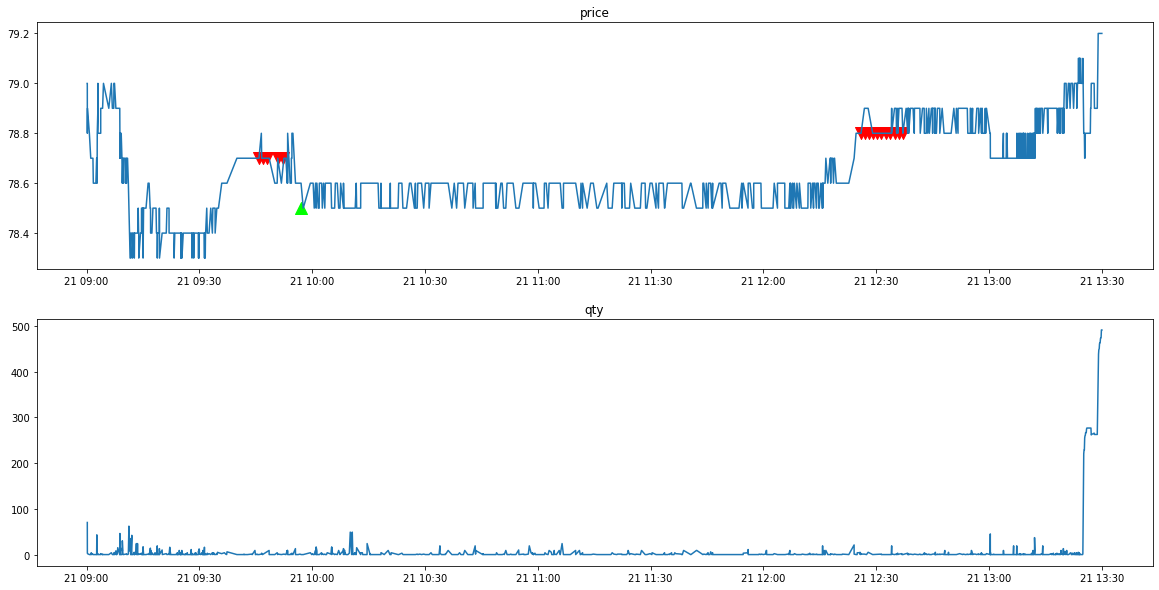

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90011329
clear_position:  0.0
position:  []
tick_row_price 78.8
----------Result Report--------------
profit:  0.0


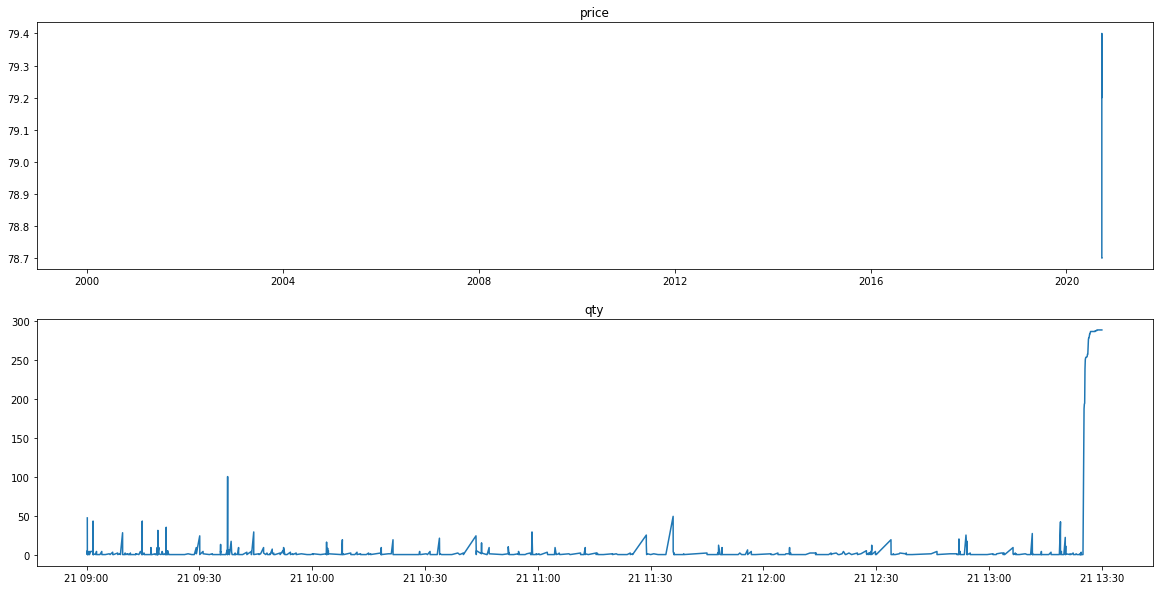

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90013368
*** bid1_p:  78.8
*** weighted_p:  78.54943396226415
ask1_p:  78.9
進場時間： 113623438 
  sell price at  78.8
stop profit
出場時間： 113647200
POSITION(pre):  [78.8]
Order_p(pre):  [78.6]
tick_row price:  78.6
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 78.3
----------Result Report--------------
profit:  0.20000000000000284


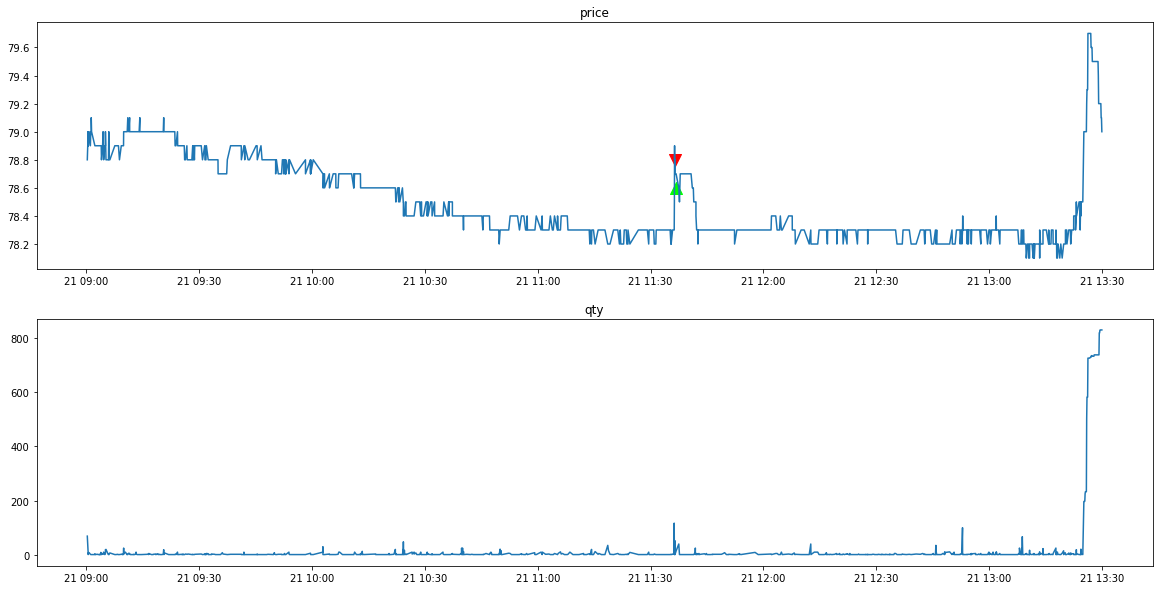

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90012136
*** bid1_p:  79.2
*** weighted_p:  78.96880552813431
ask1_p:  79.3
進場時間： 102425756 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.99291628334872
ask1_p:  79.3
進場時間： 102526275 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.99319852941183
ask1_p:  79.3
進場時間： 102633297 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.9964545454546
ask1_p:  79.3
進場時間： 102733318 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.9964545454546
ask1_p:  79.3
進場時間： 102833392 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.99718948322761
ask1_p:  79.3
進場時間： 102940907 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  79.00008976660688
ask1_p:  79.3
進場時間： 103043138 
  sell

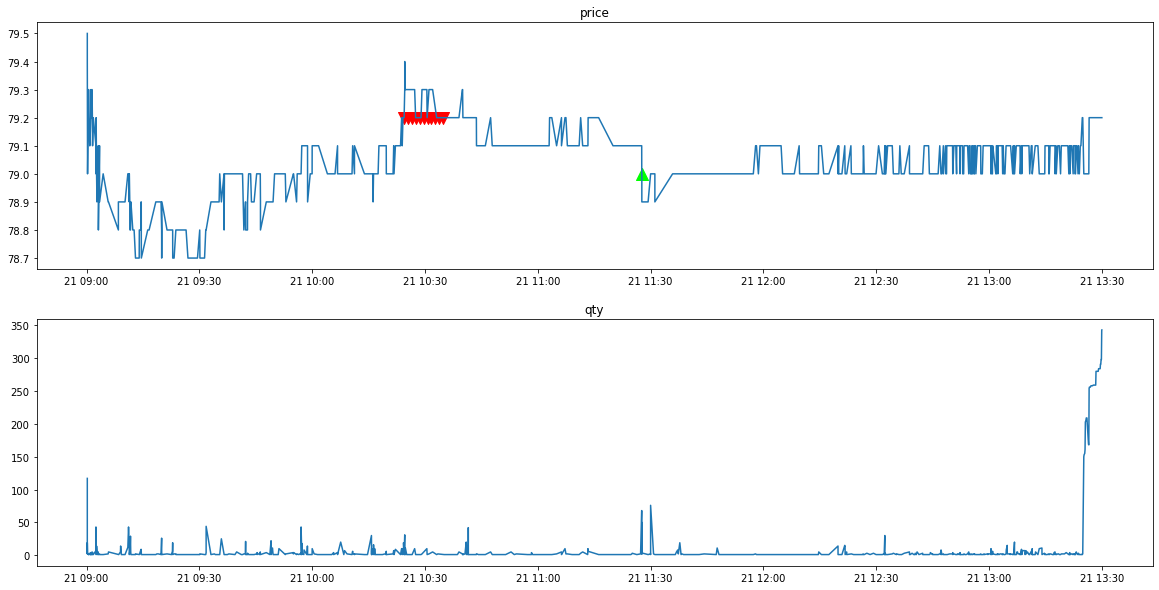

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90012290
*** bid1_p:  79.1
*** weighted_p:  0
ask1_p:  79.3
進場時間： 90202145 
  sell price at  79.1
stop profit
出場時間： 91135134
POSITION(pre):  [79.1]
Order_p(pre):  [78.9]
tick_row price:  78.9
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 78.8
----------Result Report--------------
profit:  0.19999999999998863


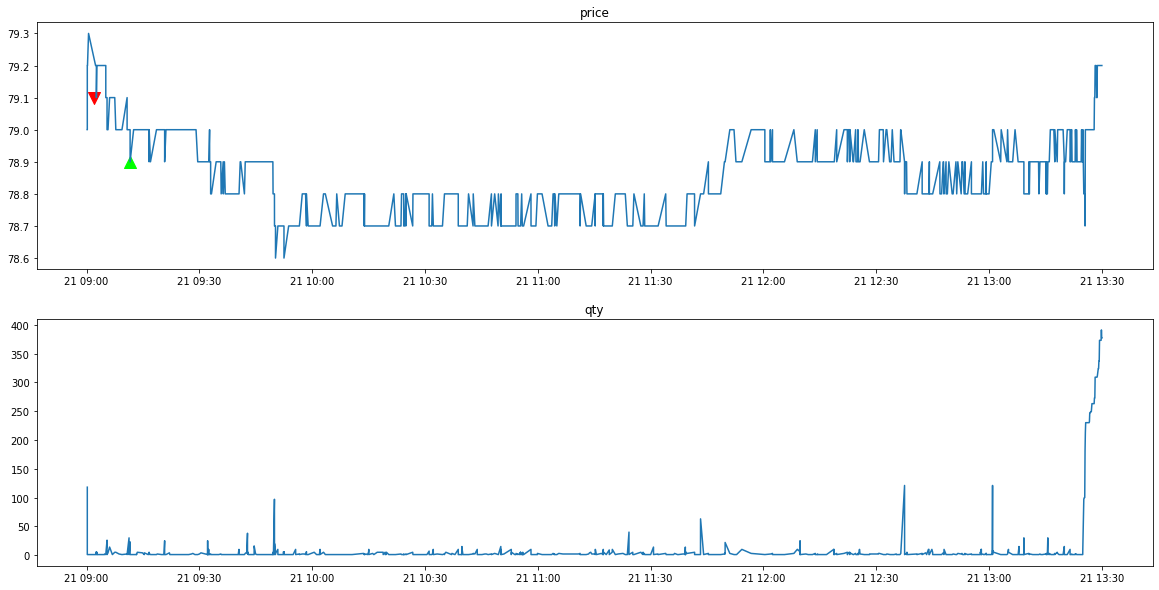

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90012153
clear_position:  0.0
position:  []
tick_row_price 79.0
----------Result Report--------------
profit:  0.0


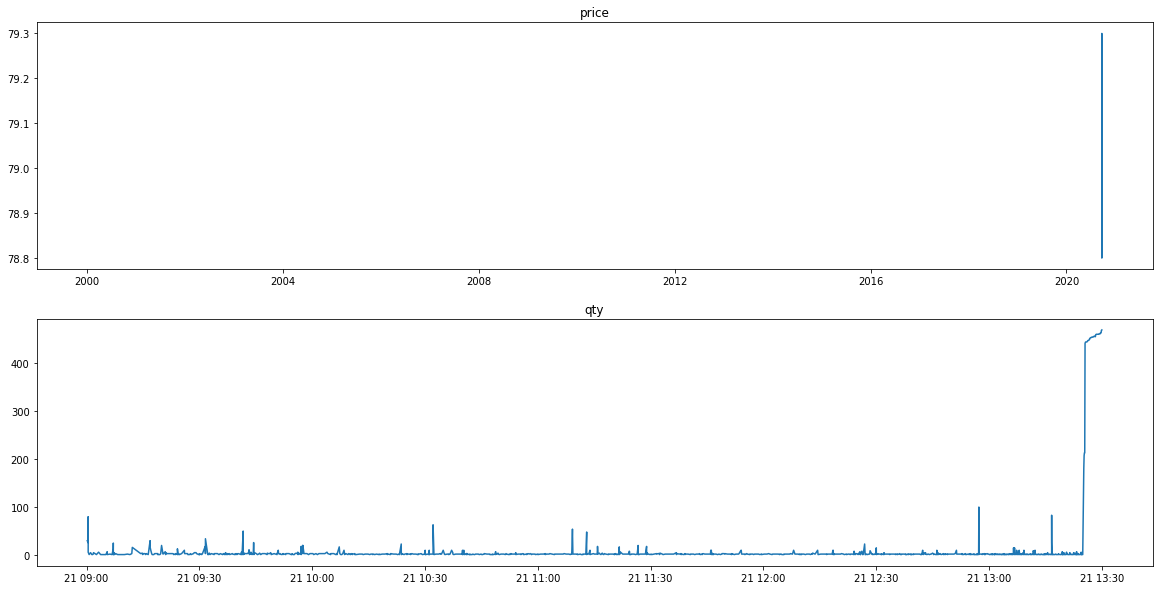

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90011031
*** bid1_p:  79.1
*** weighted_p:  78.85220385674937
ask1_p:  79.2
進場時間： 93907970 
  sell price at  79.1
*** bid1_p:  79.1
*** weighted_p:  78.8532235939644
ask1_p:  79.2
進場時間： 94008267 
  sell price at  79.1
stop profit
出場時間： 94303846
POSITION(pre):  [79.1 79.1]
Order_p(pre):  [78.9 78.9]
tick_row price:  78.9
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 78.3
----------Result Report--------------
profit:  0.39999999999997726


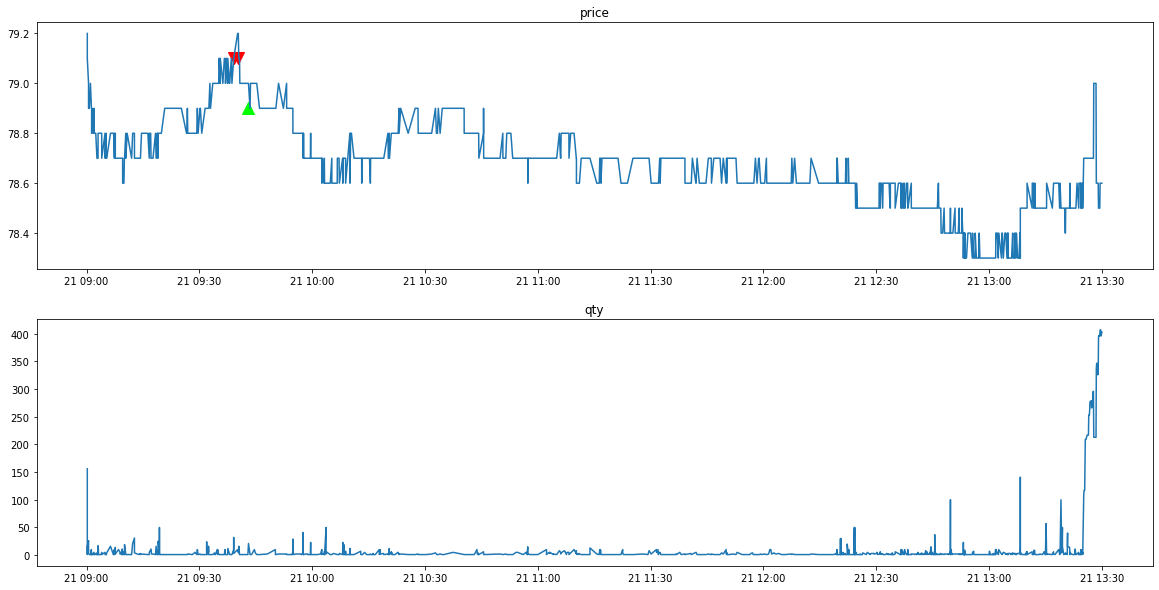

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90012499
*** bid1_p:  79.9
*** weighted_p:  79.69585635359122
ask1_p:  80.0
進場時間： 90203530 
  sell price at  79.9
*** bid1_p:  80.1
*** weighted_p:  79.85919610231429
ask1_p:  80.2
進場時間： 90305202 
  sell price at  80.1
*** bid1_p:  80.8
*** weighted_p:  80.11777603758803
ask1_p:  80.9
進場時間： 90405208 
  sell price at  80.8
------Weird price!!!!!---------
At time:  90429722
tick_row_price 81.0
ask_1_p 81.1
bid_1_p 80.9
*** bid1_p:  81.0
*** weighted_p:  80.42680965147457
ask1_p:  81.1
進場時間： 90505292 
  sell price at  81.0
stop profit
出場時間： 90600943
POSITION(pre):  [79.9 80.1 80.8 81. ]
Order_p(pre):  [79.7 79.9 80.5 80.8]
tick_row price:  80.8
qualified index:  [[3]]
POSITION(post):  [79.9 80.1 80.8]
Order_p(post):  [79.7 79.

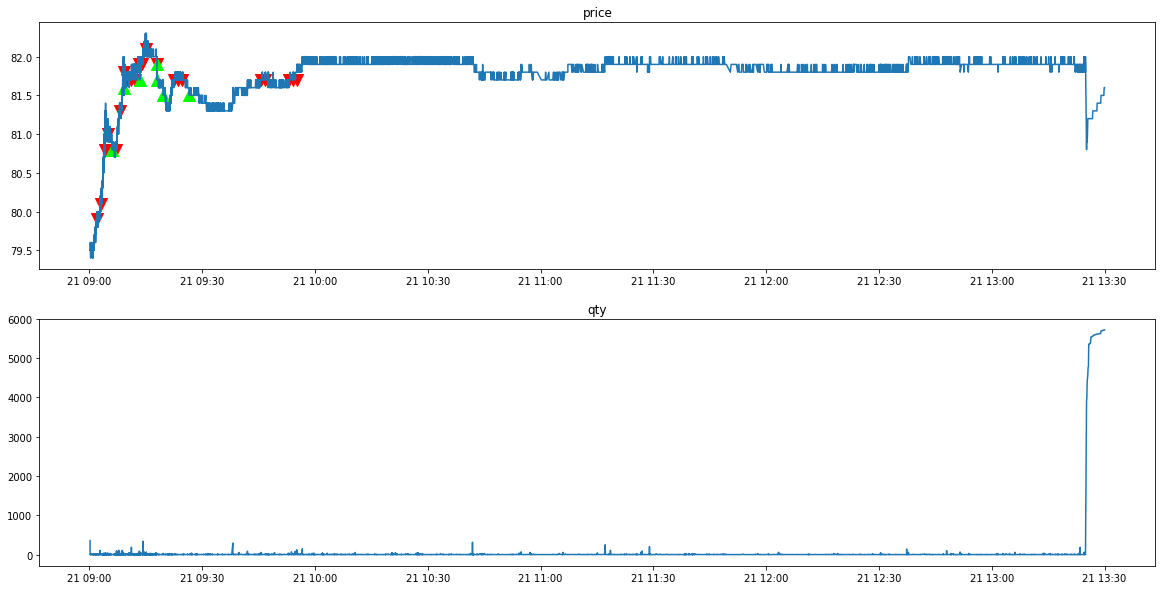

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90001766
*** bid1_p:  82.7
*** weighted_p:  82.44560117302046
ask1_p:  82.8
進場時間： 90332061 
  sell price at  82.7
*** bid1_p:  82.8
*** weighted_p:  82.55675403225817
ask1_p:  82.9
進場時間： 90441989 
  sell price at  82.8
stop profit
出場時間： 91239979
POSITION(pre):  [82.7 82.8]
Order_p(pre):  [82.5 82.6]
tick_row price:  82.6
qualified index:  [[1]]
POSITION(post):  [82.7]
Order_p(post):  [82.5]

stop profit
出場時間： 91439233
POSITION(pre):  [82.7]
Order_p(pre):  [82.5]
tick_row price:  82.5
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 83.0
----------Result Report--------------
profit:  0.4000000000000057


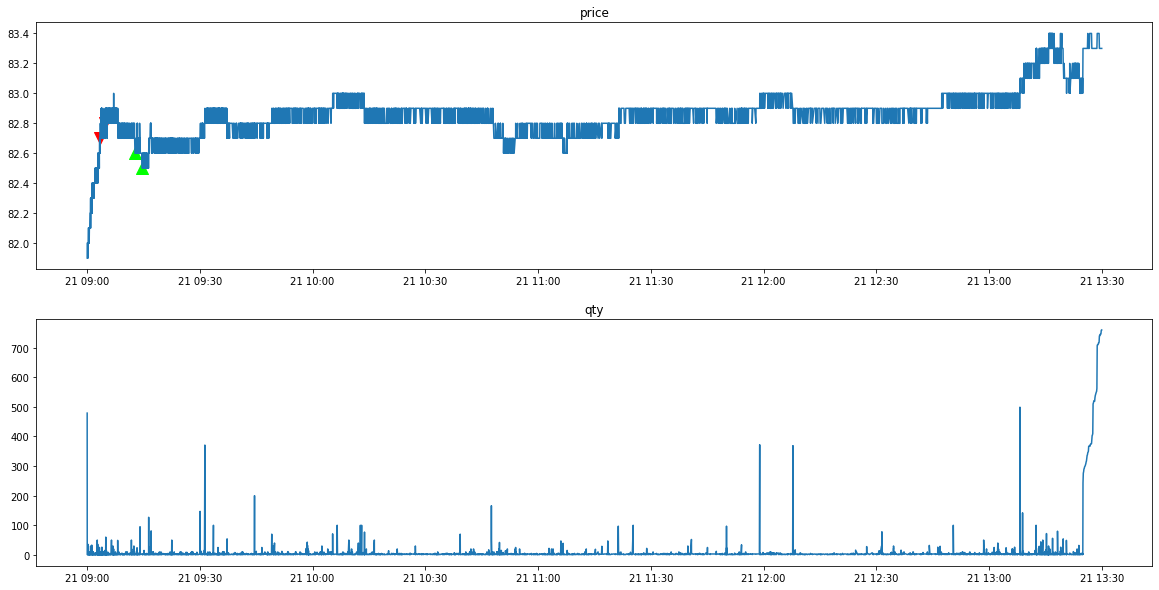

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90003619
*** bid1_p:  82.8
*** weighted_p:  82.53658536585364
ask1_p:  82.9
進場時間： 90557949 
  sell price at  82.8
stop profit
出場時間： 90701016
POSITION(pre):  [82.8]
Order_p(pre):  [82.5]
tick_row price:  82.5
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 81.3
----------Result Report--------------
profit:  0.29999999999999716


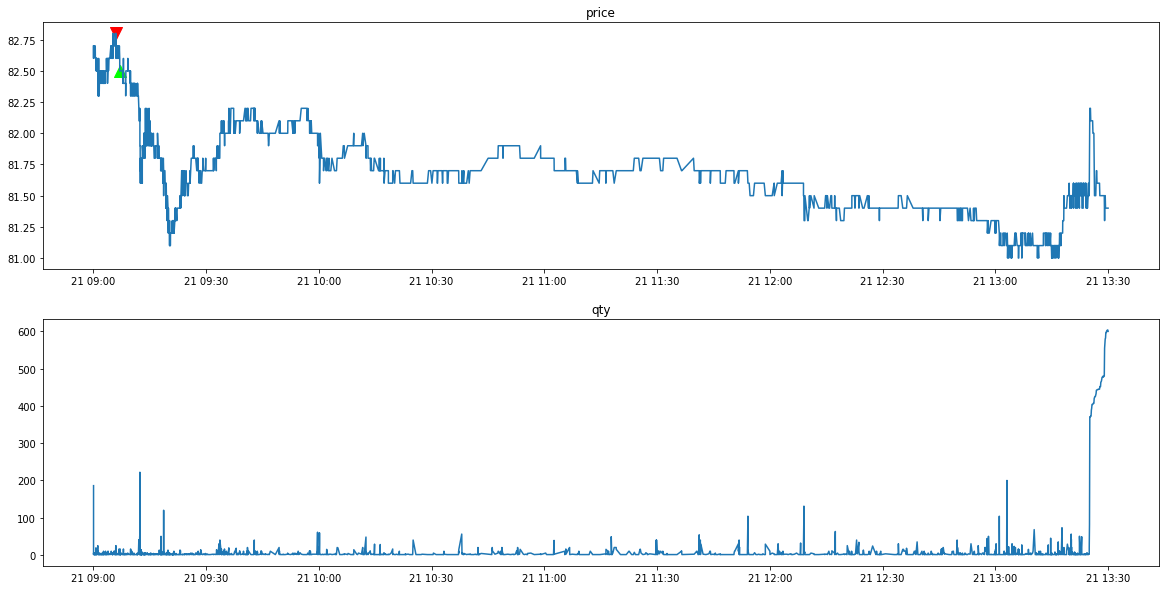

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90005586
clear_position:  0.0
position:  []
tick_row_price 80.3
----------Result Report--------------
profit:  0.0


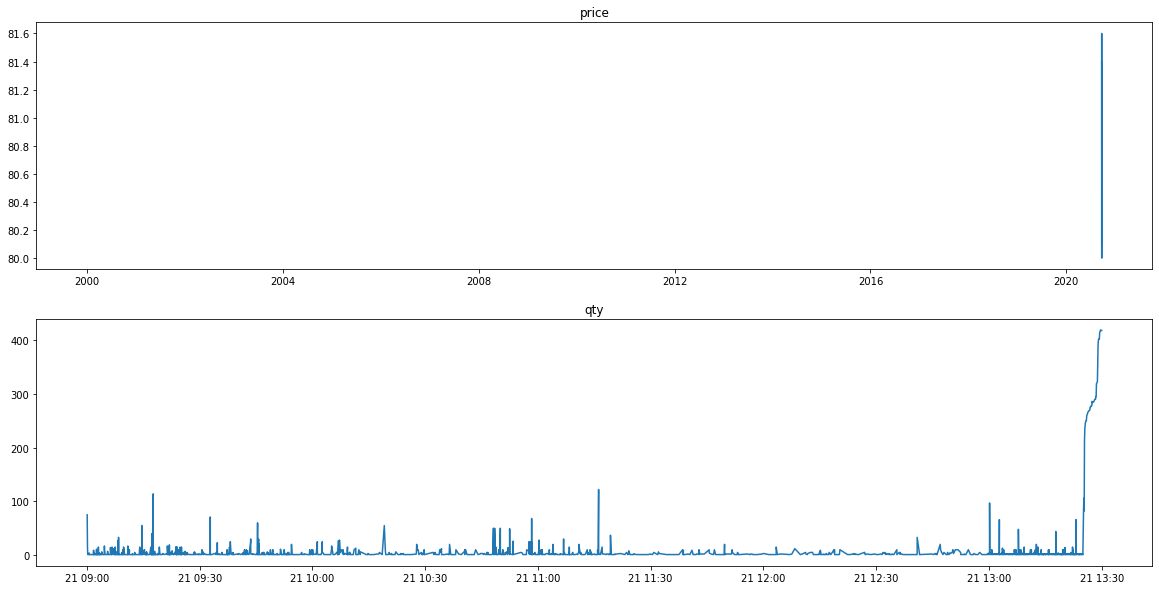

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90008320
*** bid1_p:  79.0
*** weighted_p:  78.79247810407009
ask1_p:  79.1
進場時間： 92345932 
  sell price at  79.0
*** bid1_p:  79.0
*** weighted_p:  78.79375000000003
ask1_p:  79.1
進場時間： 92446229 
  sell price at  79.0
*** bid1_p:  79.1
*** weighted_p:  78.79974912192677
ask1_p:  79.2
進場時間： 92546486 
  sell price at  79.1
*** bid1_p:  79.2
*** weighted_p:  78.80781710914464
ask1_p:  79.3
進場時間： 92650549 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.81515004840278
ask1_p:  79.3
進場時間： 92751094 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.8334741784038
ask1_p:  79.3
進場時間： 92851986 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.83568425969179
ask1_p:  79.3
進場時間： 92958876 
  sell price

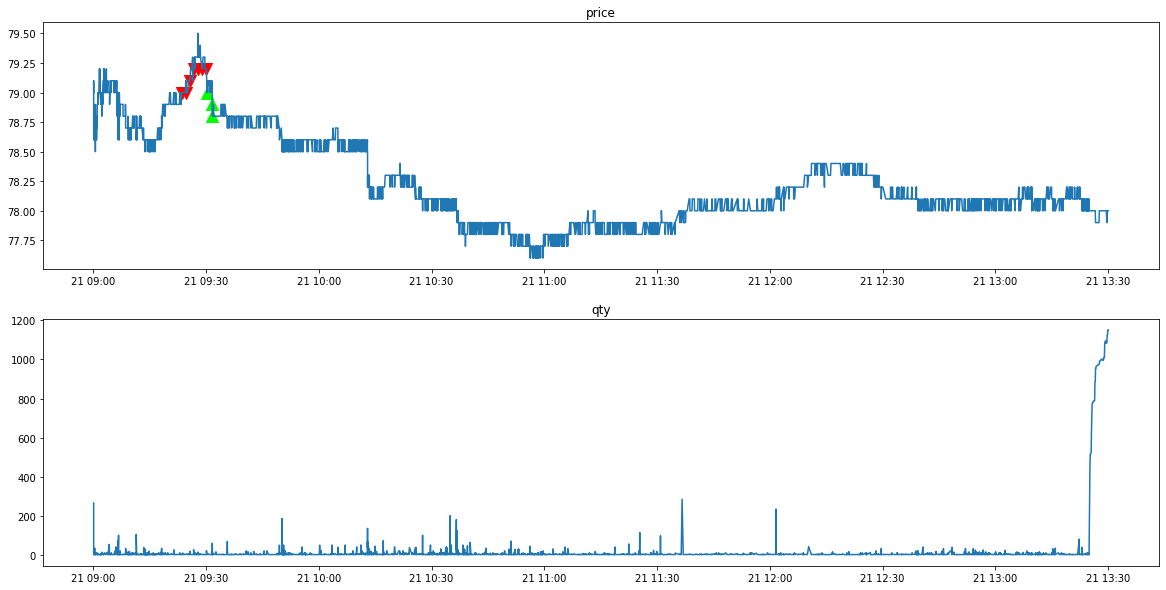

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/1301/tse_lob_1301.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/1301/tse_tick_1301.csv' mode='r' encoding='UTF-8'>
90005328
*** bid1_p:  78.8
*** weighted_p:  78.52635135135134
ask1_p:  78.9
進場時間： 91903370 
  sell price at  78.8
*** bid1_p:  78.8
*** weighted_p:  78.5404220779221
ask1_p:  78.9
進場時間： 92003559 
  sell price at  78.8
*** bid1_p:  78.8
*** weighted_p:  78.55318818040439
ask1_p:  78.9
進場時間： 92104540 
  sell price at  78.8
*** bid1_p:  78.8
*** weighted_p:  78.58527777777785
ask1_p:  78.9
進場時間： 92252047 
  sell price at  78.8
*** bid1_p:  78.8
*** weighted_p:  78.58919288645697
ask1_p:  78.9
進場時間： 92353546 
  sell price at  78.8
*** bid1_p:  78.8
*** weighted_p:  78.5939678284183
ask1_p:  78.9
進場時間： 92454684 
  sell price at  78.8
*** bid1_p:  78.9
*** weighted_p:  78.62254545454556
ask1_p:  79.0
進場時間： 92732047 
  sell price 

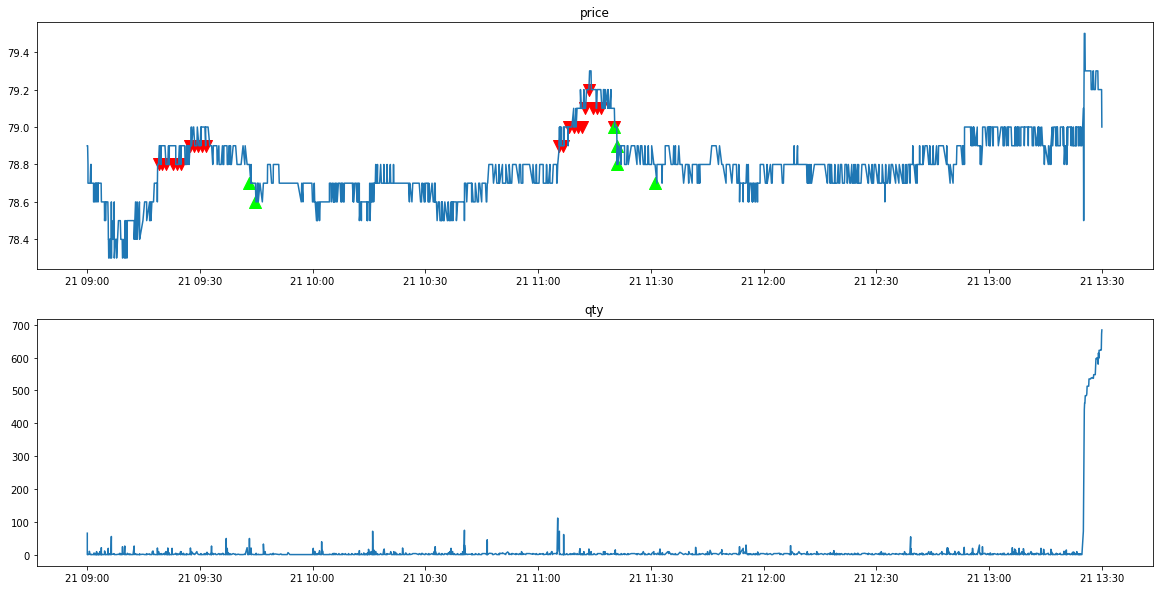

In [ ]:
res_1301 = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), "1301")

In [ ]:
profit_1301, cost_1301 = calculate_profit(res_1301)

In [ ]:
profit_1301

4.3999999999999915

In [ ]:
cost_1301

6938.5

#### 2002


<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90003631
*** bid1_p:  20.7
*** weighted_p:  20.63255033557043
ask1_p:  20.75
進場時間： 93812409 
  sell price at  20.7
*** bid1_p:  20.7
*** weighted_p:  20.633233807992607
ask1_p:  20.75
進場時間： 93913120 
  sell price at  20.7
*** bid1_p:  20.7
*** weighted_p:  20.6342434584755
ask1_p:  20.75
進場時間： 94014071 
  sell price at  20.7
*** bid1_p:  20.7
*** weighted_p:  20.634588342027627
ask1_p:  20.75
進場時間： 94114652 
  sell price at  20.7
*** bid1_p:  20.7
*** weighted_p:  20.637893809209032
ask1_p:  20.75
進場時間： 94215733 
  sell price at  20.7
*** bid1_p:  20.7
*** weighted_p:  20.638439623054964
ask1_p:  20.75
進場時間： 94315948 
  sell price at  20.7
*** bid1_p:  20.7
*** weighted_p:  20.639124293785265
ask1_p:  20.75
進場時間： 94416617 


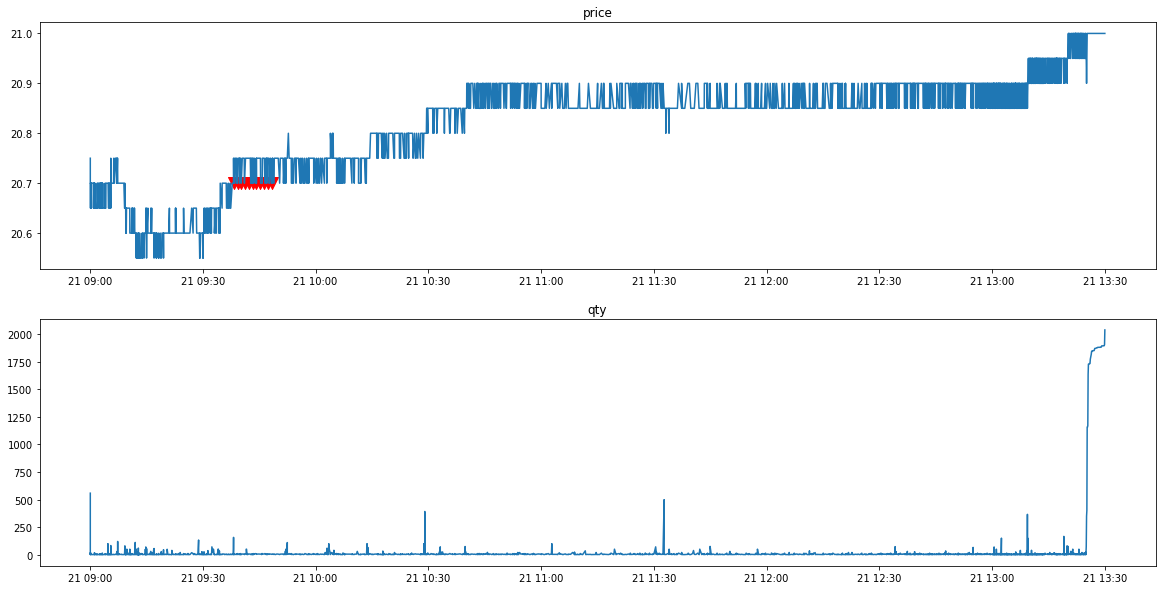

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90005464
*** bid1_p:  20.9
*** weighted_p:  20.804013777590374
ask1_p:  20.95
進場時間： 104518657 
  sell price at  20.9
stop profit
出場時間： 105741098
POSITION(pre):  [20.9]
Order_p(pre):  [20.8]
tick_row price:  20.8
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.09999999999999787


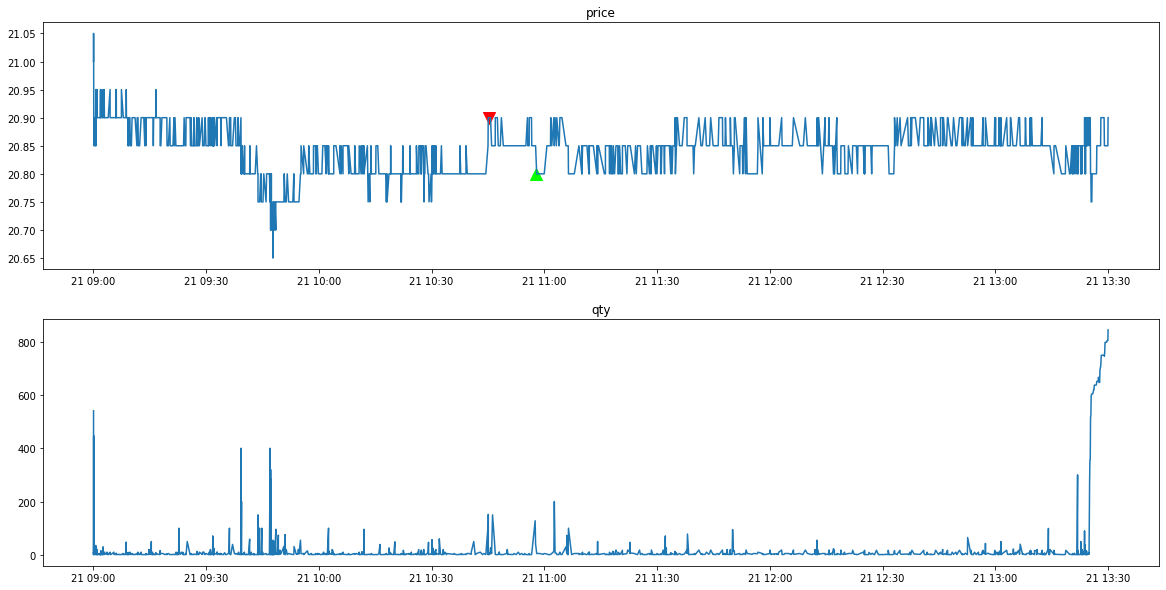

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90007198
clear_position:  0.0
position:  []
tick_row_price 20.85
----------Result Report--------------
profit:  0.0


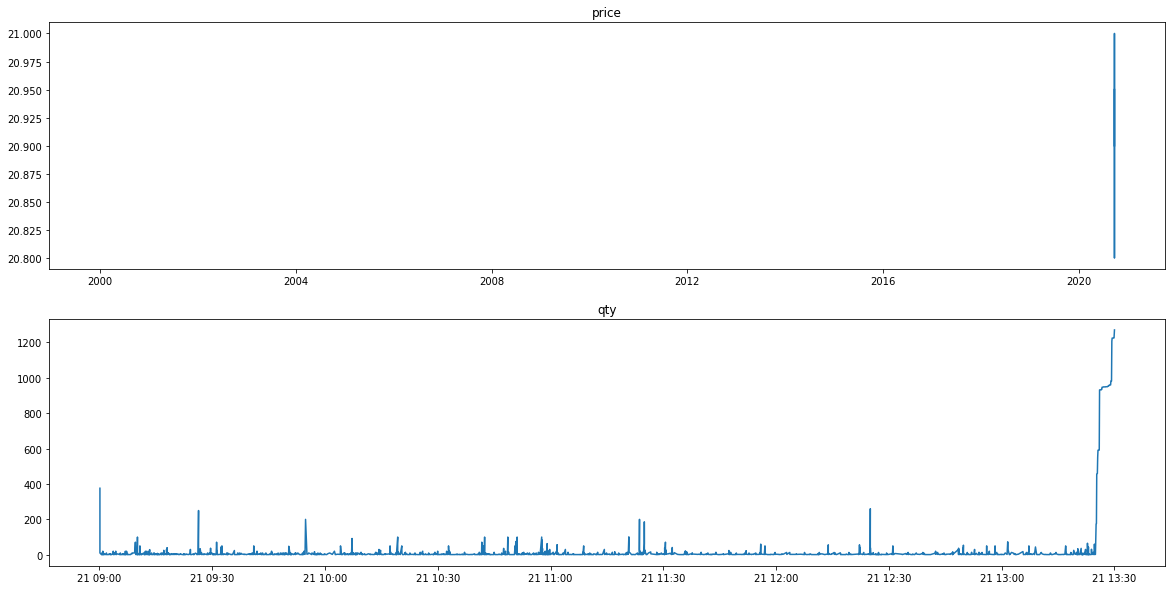

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90005711
clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.0


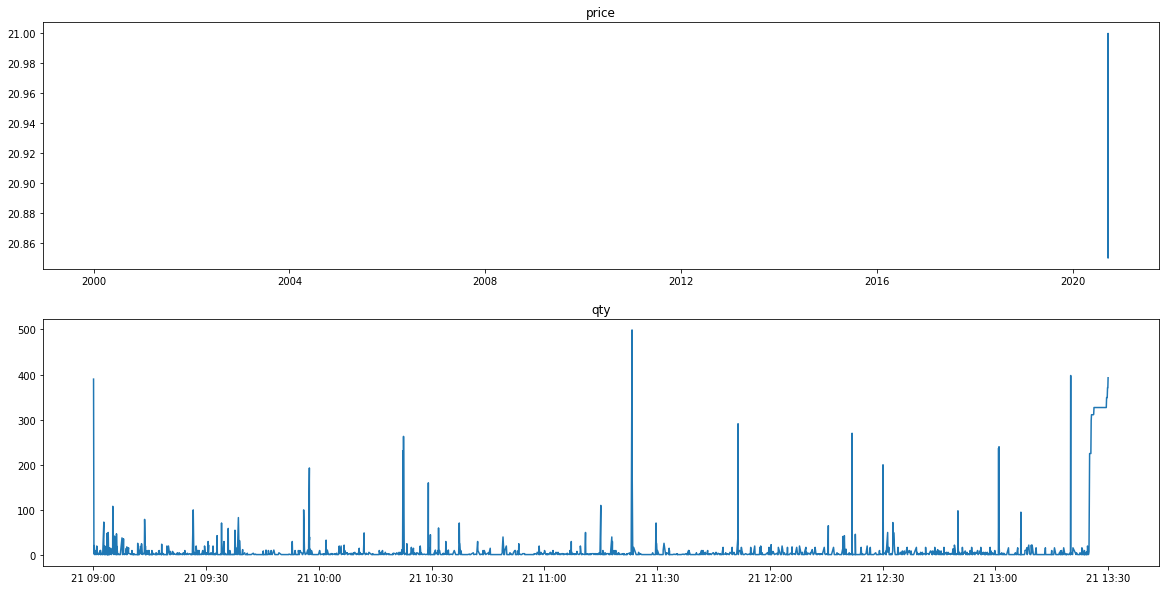

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90005269
clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.0


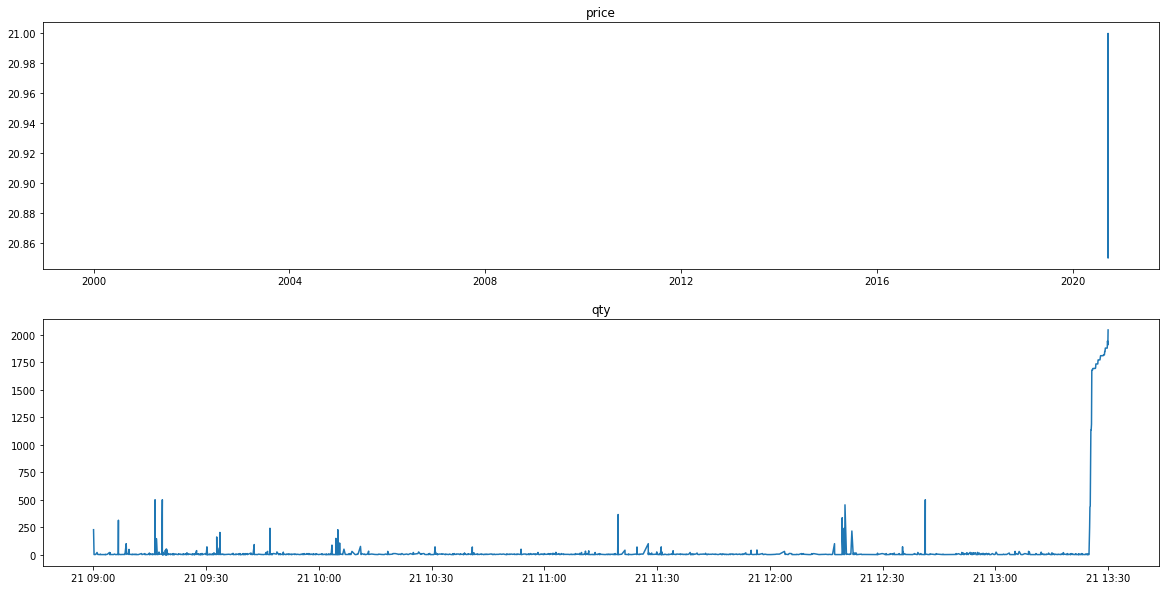

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90005515
clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.0


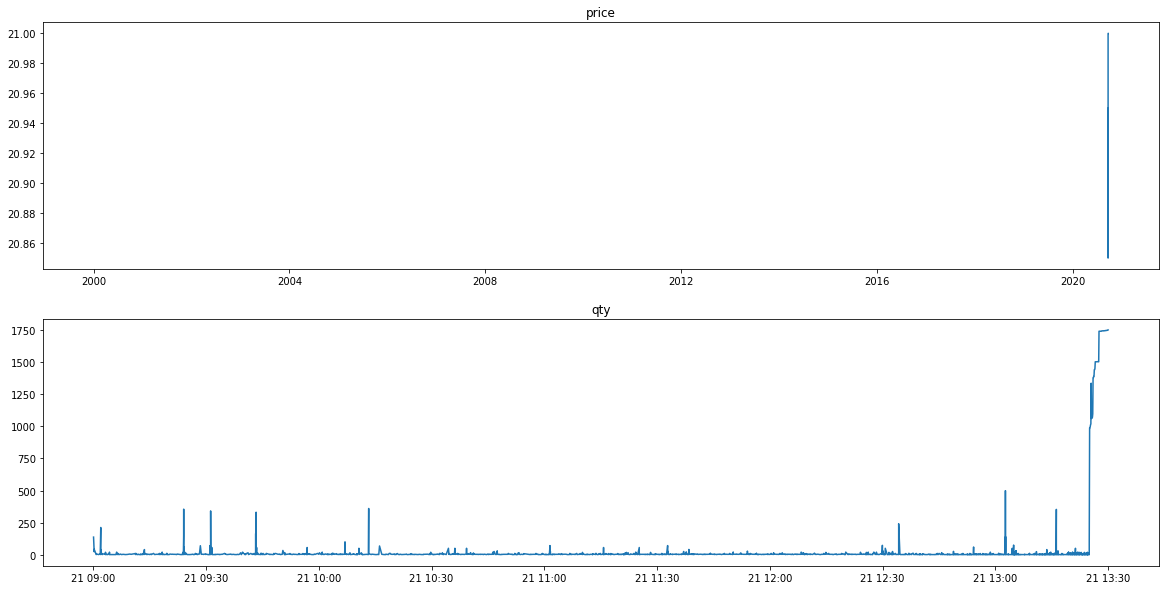

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90006154
clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.0


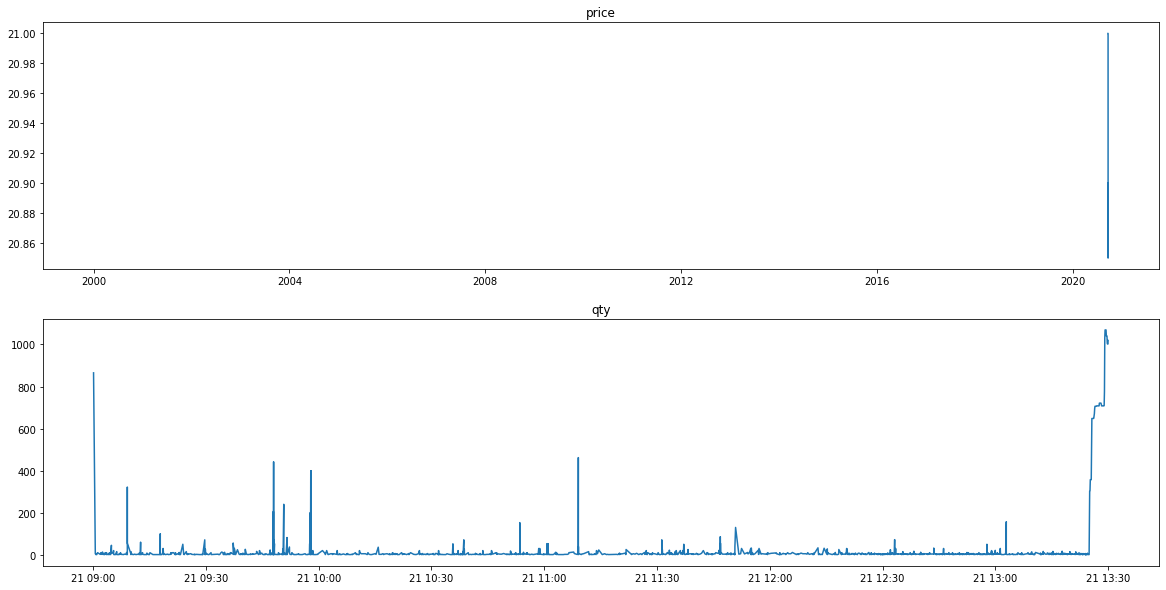

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90007479
clear_position:  0.0
position:  []
tick_row_price 20.9
----------Result Report--------------
profit:  0.0


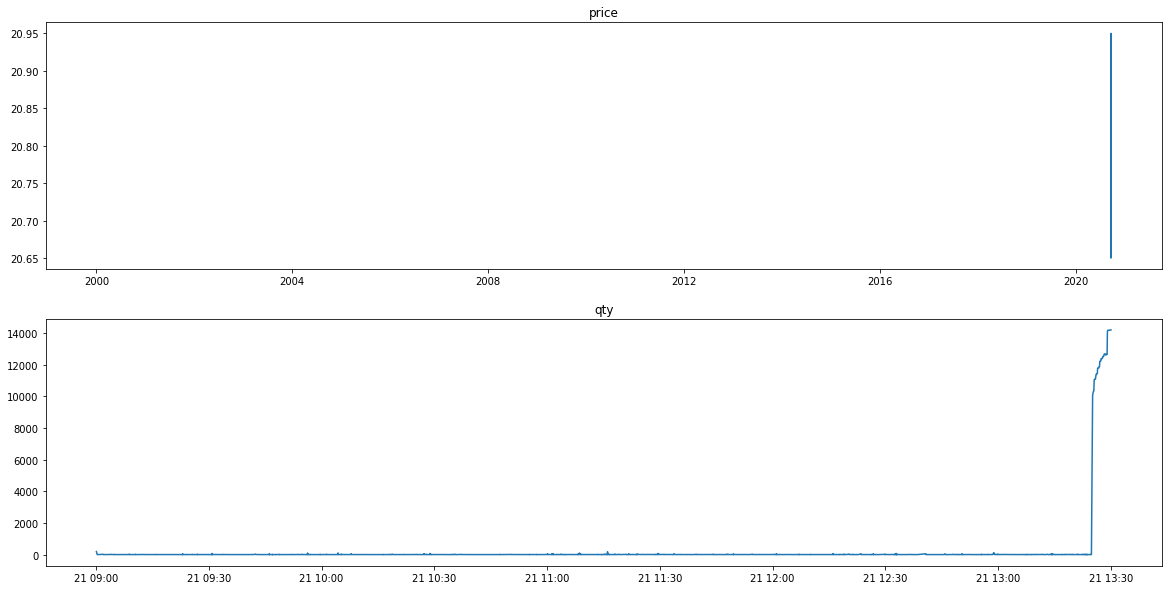

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90006780
clear_position:  0.0
position:  []
tick_row_price 20.75
----------Result Report--------------
profit:  0.0


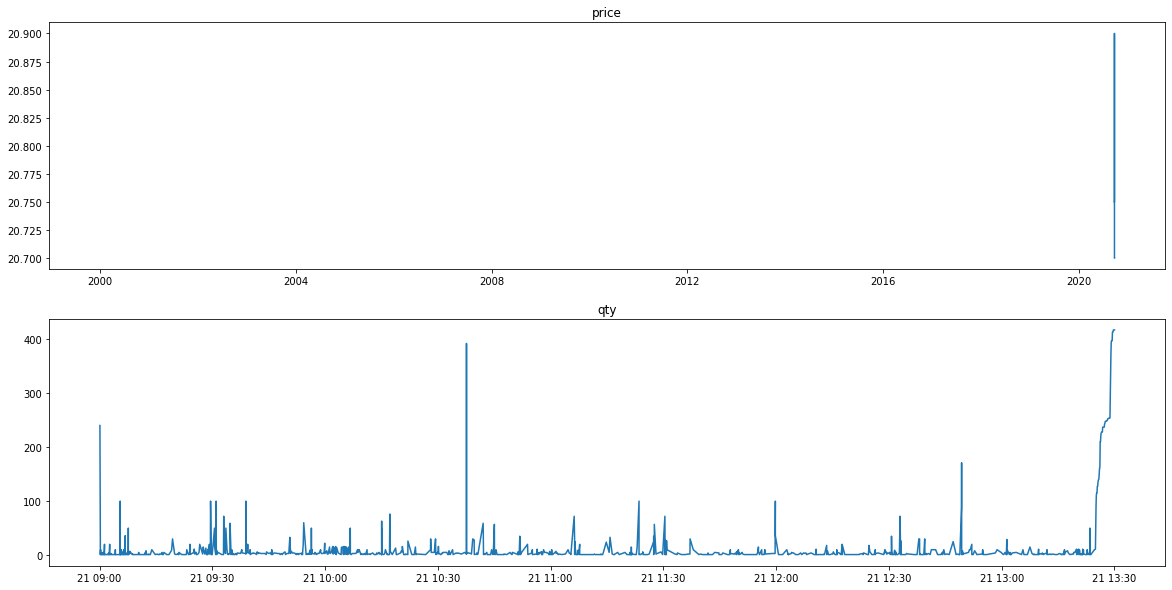

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90008840
clear_position:  0.0
position:  []
tick_row_price 20.7
----------Result Report--------------
profit:  0.0


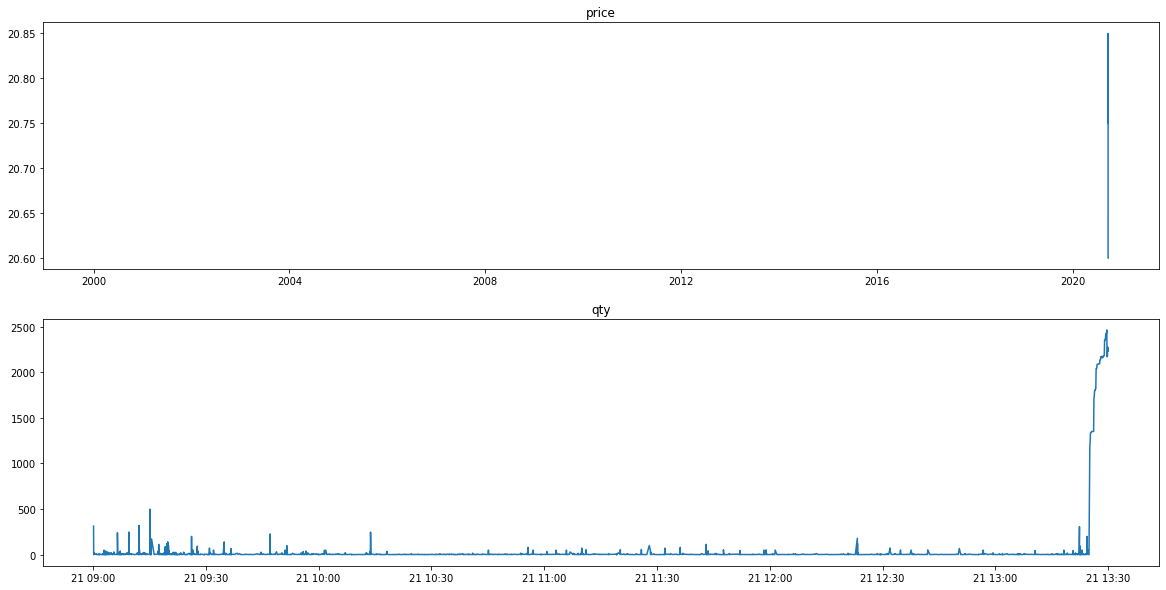

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90006388
clear_position:  0.0
position:  []
tick_row_price 20.5
----------Result Report--------------
profit:  0.0


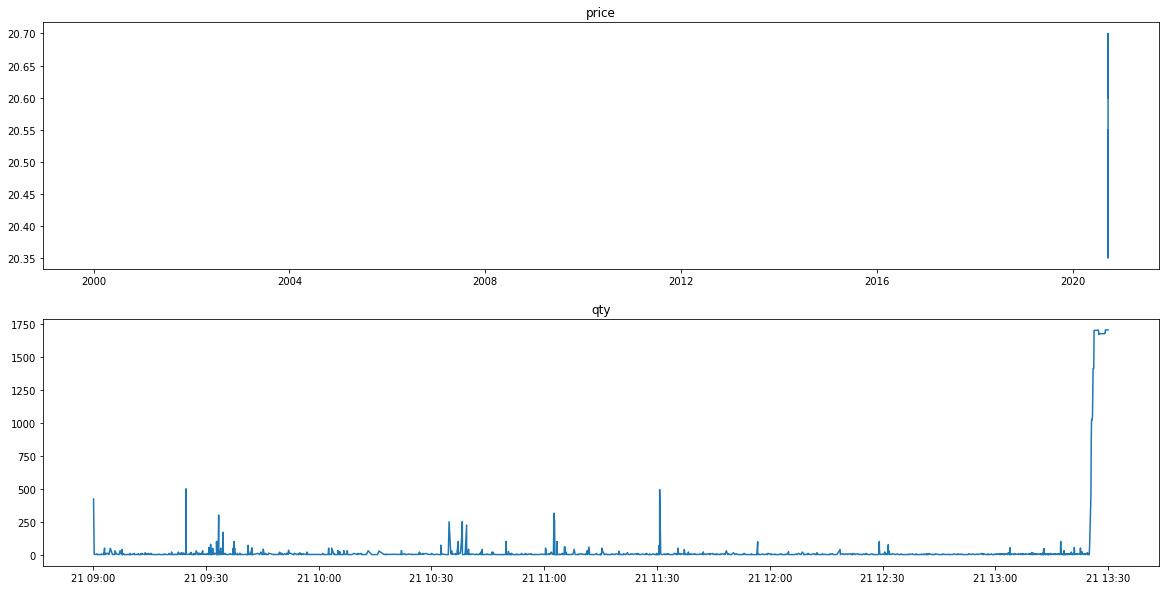

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90007316
clear_position:  0.0
position:  []
tick_row_price 20.05
----------Result Report--------------
profit:  0.0


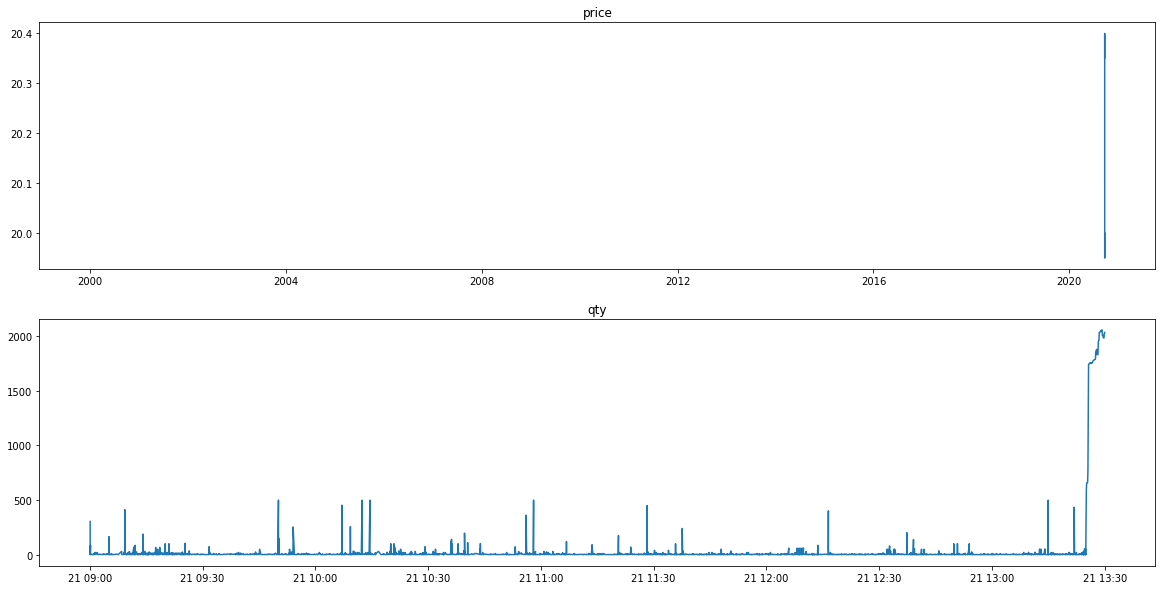

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2002/tse_lob_2002.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2002/tse_tick_2002.csv' mode='r' encoding='UTF-8'>
90005859
clear_position:  0.0
position:  []
tick_row_price 20.15
----------Result Report--------------
profit:  0.0


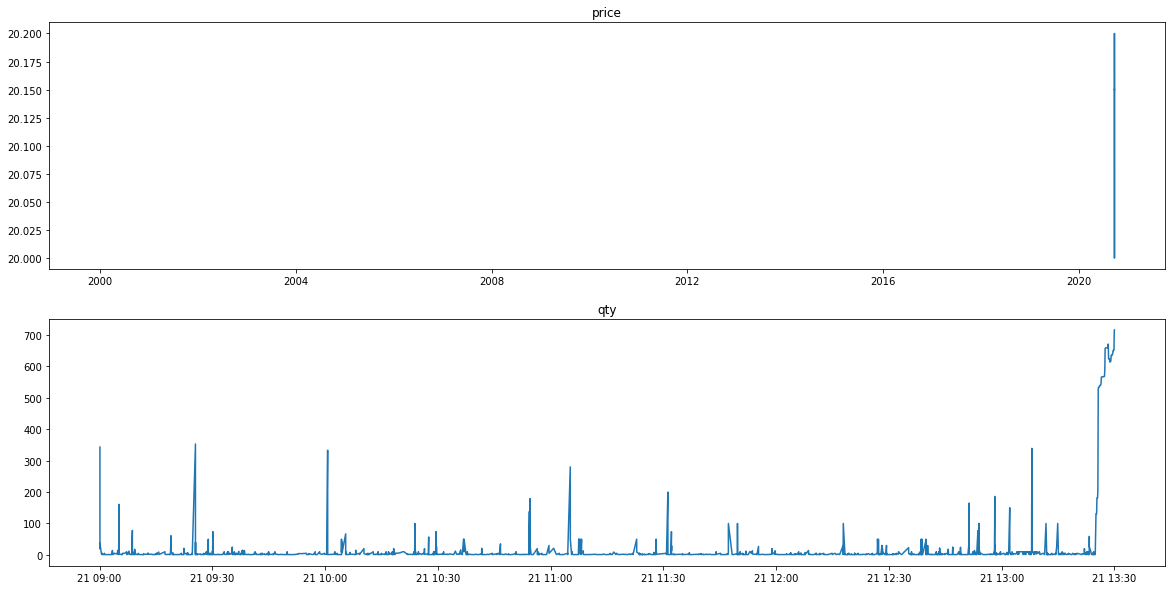

In [ ]:
para = {"sid": "2002", "beta":2, "time_out": 2000000, "gamma": 0.75, "cool_down_min": 100000, "stop_loss_factor": 1.02, "theta": 1.0025, "position_max_q": 10}
res_2002 = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), **para)
profit_2002, cost_2002 = calculate_profit(res_2002)

In [ ]:
profit_2002

-1.5500000000000256

In [ ]:
cost_2002

248.59999999999997

#### 2454


<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90004434
*** bid1_p:  597.0
*** weighted_p:  595.4411764705883
ask1_p:  598.0
進場時間： 90257394 
  sell price at  597.0
stop profit
出場時間： 90646295
POSITION(pre):  [597.]
Order_p(pre):  [595.]
tick_row price:  595.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  593.0
*** weighted_p:  591.4943269365457
ask1_p:  594.0
進場時間： 121946885 
  sell price at  593.0
*** bid1_p:  593.0
*** weighted_p:  591.5070344059061
ask1_p:  594.0
進場時間： 122048732 
  sell price at  593.0
*** bid1_p:  593.0
*** weighted_p:  591.5086302895323
ask1_p:  594.0
進場時間： 122149514 
  sell price at  593.0
*** bid1_p:  594.0
*** weighted_p:  591.5926414347883
ask1_p:  595.0
進場時間： 123830300 
  sell price at  594.0
*** bid1_p:  594.0
**

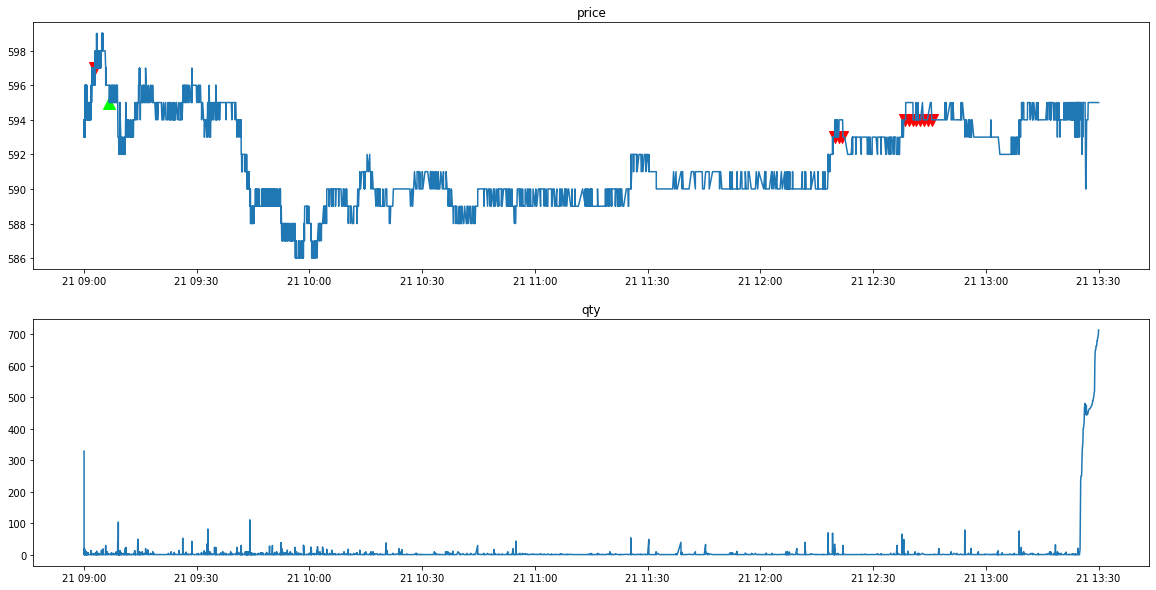

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90003858
*** bid1_p:  606.0
*** weighted_p:  604.1397637795276
ask1_p:  607.0
進場時間： 90451581 
  sell price at  606.0
stop profit
出場時間： 90655041
POSITION(pre):  [606.]
Order_p(pre):  [604.]
tick_row price:  604.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 599.0
----------Result Report--------------
profit:  2.0


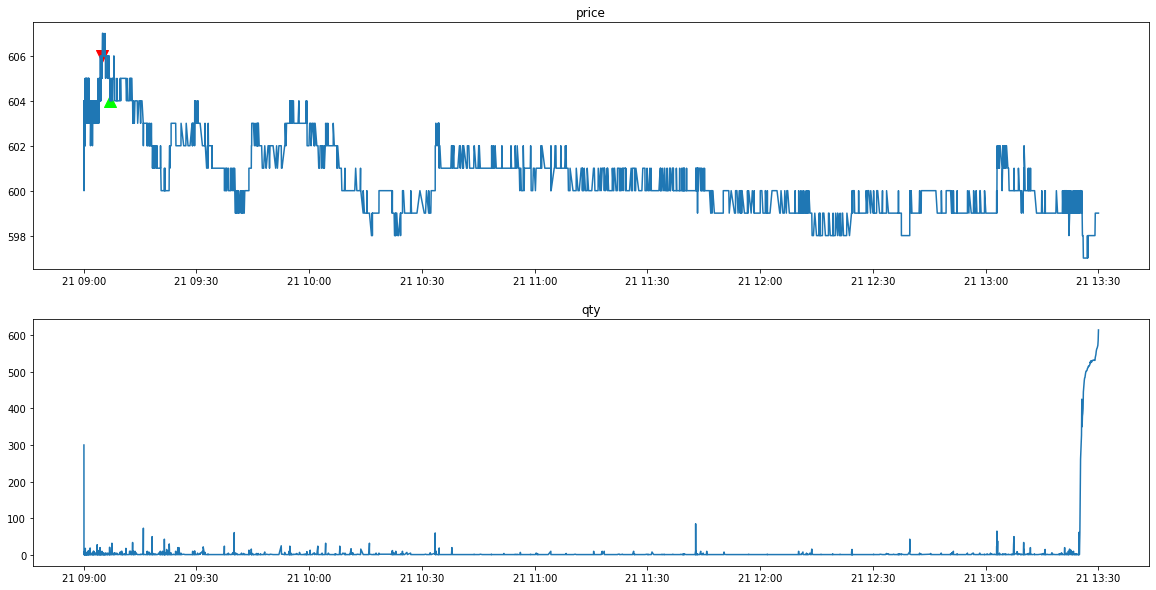

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90004186
*** bid1_p:  595.0
*** weighted_p:  592.8688524590164
ask1_p:  596.0
進場時間： 102355856 
  sell price at  595.0
*** bid1_p:  595.0
*** weighted_p:  592.8950304259635
ask1_p:  596.0
進場時間： 102455961 
  sell price at  595.0
*** bid1_p:  595.0
*** weighted_p:  592.9309743334164
ask1_p:  596.0
進場時間： 102814802 
  sell price at  595.0
*** bid1_p:  595.0
*** weighted_p:  592.9531442663379
ask1_p:  596.0
進場時間： 103019515 
  sell price at  595.0
*** bid1_p:  595.0
*** weighted_p:  592.959163591636
ask1_p:  596.0
進場時間： 103121915 
  sell price at  595.0
*** bid1_p:  595.0
*** weighted_p:  592.9614060963619
ask1_p:  596.0
進場時間： 103224966 
  sell price at  595.0
*** bid1_p:  595.0
*** weighted_p:  592.9641453831041
ask1_p:  596.0
進場

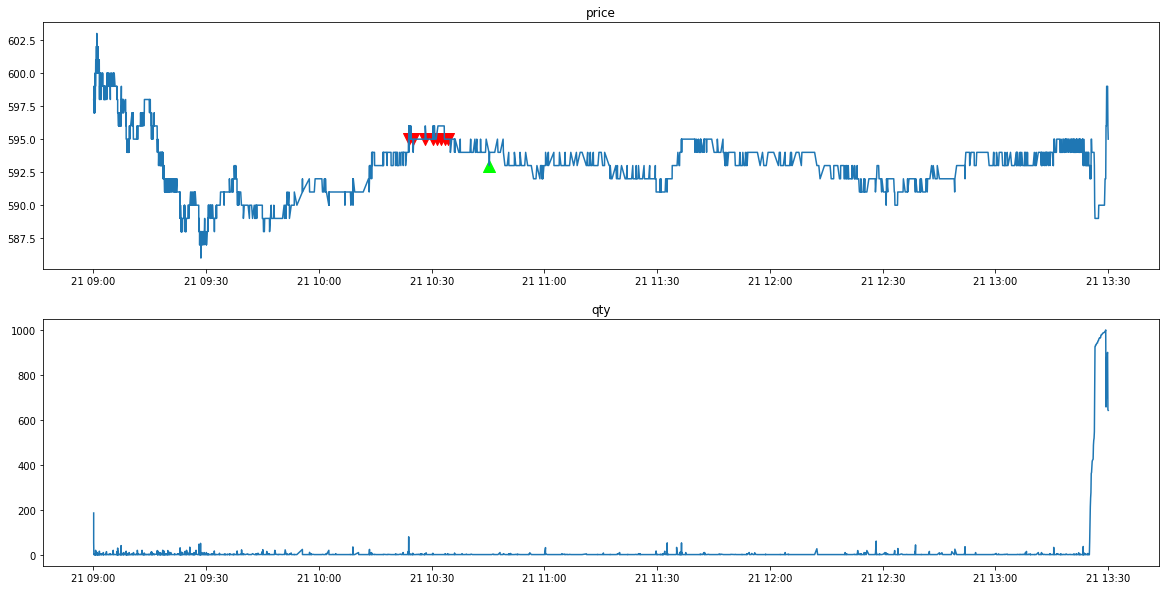

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90003530
*** bid1_p:  594.0
*** weighted_p:  592.2511111111111
ask1_p:  595.0
進場時間： 91011278 
  sell price at  594.0
*** bid1_p:  594.0
*** weighted_p:  592.323340471092
ask1_p:  595.0
進場時間： 91111621 
  sell price at  594.0
*** bid1_p:  594.0
*** weighted_p:  592.4412635735439
ask1_p:  595.0
進場時間： 91228222 
  sell price at  594.0
*** bid1_p:  596.0
*** weighted_p:  592.9878542510121
ask1_p:  597.0
進場時間： 91329227 
  sell price at  596.0
*** bid1_p:  595.0
*** weighted_p:  593.0600790513834
ask1_p:  596.0
進場時間： 91429399 
  sell price at  595.0
*** bid1_p:  595.0
*** weighted_p:  593.1192873741286
ask1_p:  597.0
進場時間： 91529712 
  sell price at  595.0
*** bid1_p:  599.0
*** weighted_p:  593.6668965517241
ask1_p:  600.0
進場時間： 91

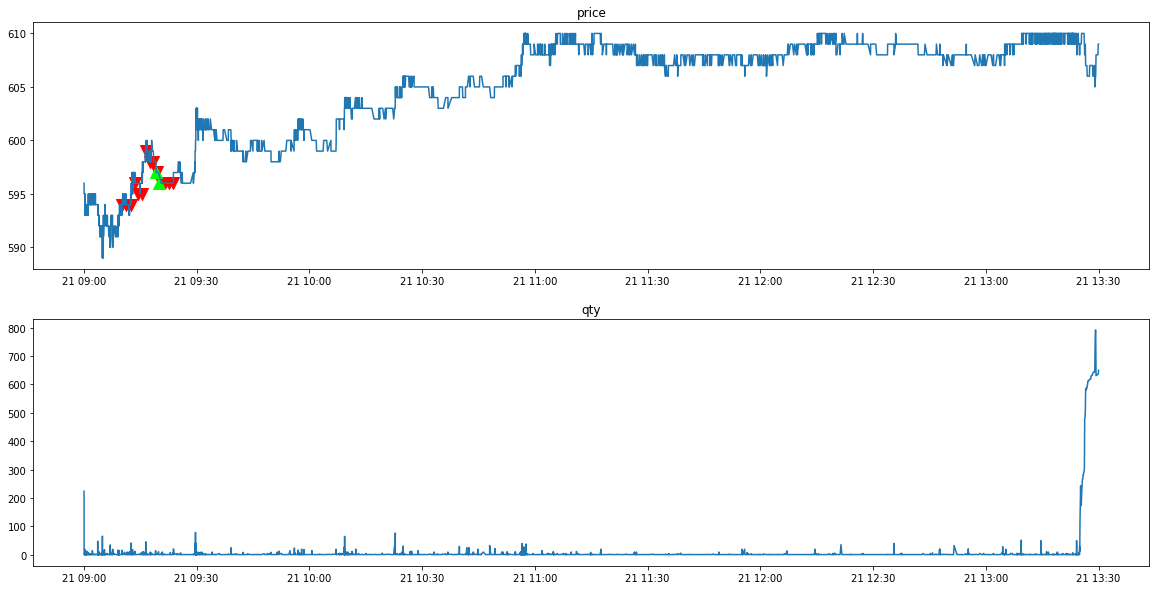

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90003263
*** bid1_p:  609.0
*** weighted_p:  606.8036809815951
ask1_p:  610.0
進場時間： 91643955 
  sell price at  609.0
*** bid1_p:  610.0
*** weighted_p:  607.09963099631
ask1_p:  611.0
進場時間： 91744416 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  607.4040574809806
ask1_p:  611.0
進場時間： 91844925 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  607.6677042801556
ask1_p:  611.0
進場時間： 91945129 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  607.8133828996282
ask1_p:  612.0
進場時間： 92045170 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  608.0200668896321
ask1_p:  611.0
進場時間： 92635737 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  608.101935483871
ask1_p:  611.0
進場時間： 9273

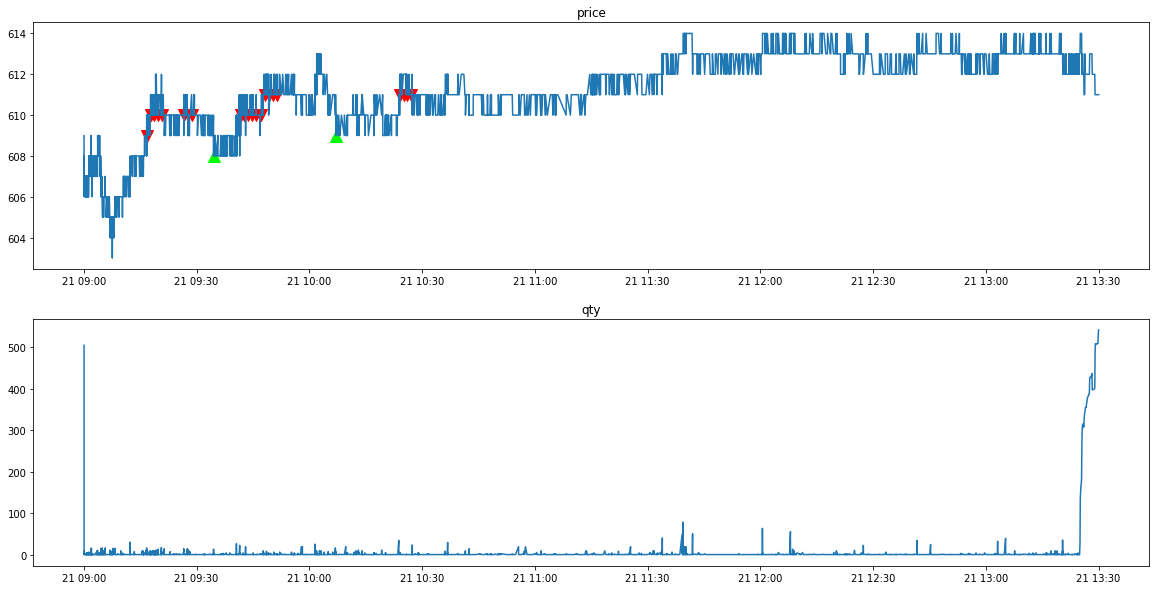

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90002919
*** bid1_p:  620.0
*** weighted_p:  618.132860040568
ask1_p:  621.0
進場時間： 90655030 
  sell price at  620.0
*** bid1_p:  621.0
*** weighted_p:  618.8692913385827
ask1_p:  622.0
進場時間： 90755673 
  sell price at  621.0
stop profit
出場時間： 90943729
POSITION(pre):  [620. 621.]
Order_p(pre):  [618. 619.]
tick_row price:  619.0
qualified index:  [[1]]
POSITION(post):  [620.]
Order_p(post):  [618.]

stop profit
出場時間： 91058802
POSITION(pre):  [620.]
Order_p(pre):  [618.]
tick_row price:  618.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  621.0
*** weighted_p:  619.170613562971
ask1_p:  622.0
進場時間： 91856845 
  sell price at  621.0
*** bid1_p:  621.0
*** weighted_p:  619.2784874808381
ask1_p:  622

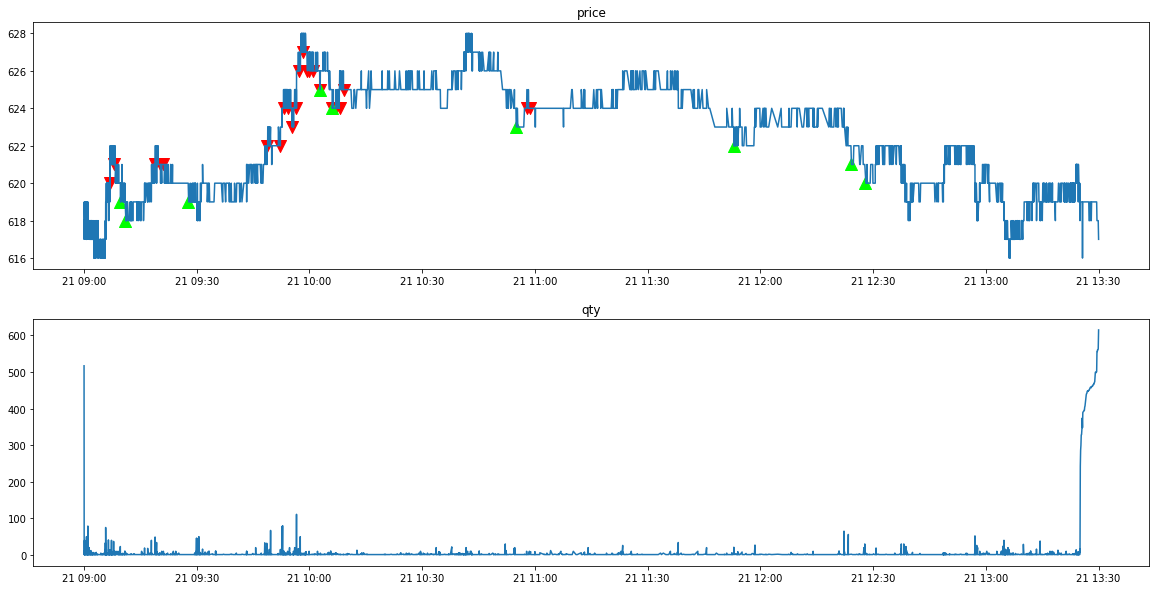

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90002544
*** bid1_p:  605.0
*** weighted_p:  603.1389380530974
ask1_p:  606.0
進場時間： 91506803 
  sell price at  605.0
stop profit
出場時間： 91700419
POSITION(pre):  [605.]
Order_p(pre):  [603.]
tick_row price:  603.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 596.0
----------Result Report--------------
profit:  2.0


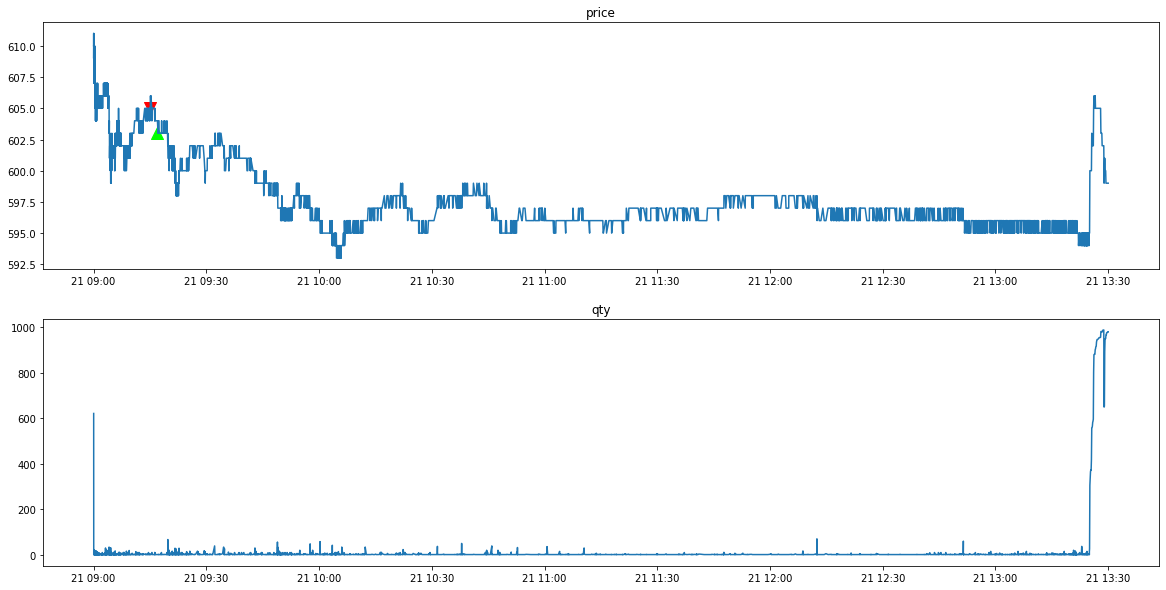

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90002257
*** bid1_p:  599.0
*** weighted_p:  597.3789808917197
ask1_p:  600.0
進場時間： 90304422 
  sell price at  599.0
stop profit
出場時間： 90620138
POSITION(pre):  [599.]
Order_p(pre):  [597.]
tick_row price:  597.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  597.0
*** weighted_p:  594.970222513089
ask1_p:  598.0
進場時間： 101321718 
  sell price at  597.0
*** bid1_p:  597.0
*** weighted_p:  594.9860026041666
ask1_p:  598.0
進場時間： 101422600 
  sell price at  597.0
*** bid1_p:  597.0
*** weighted_p:  595.0320102432778
ask1_p:  598.0
進場時間： 101528151 
  sell price at  597.0
*** bid1_p:  598.0
*** weighted_p:  595.1148922884795
ask1_p:  599.0
進場時間： 101628604 
  sell price at  598.0
*** bid1_p:  599.0
***

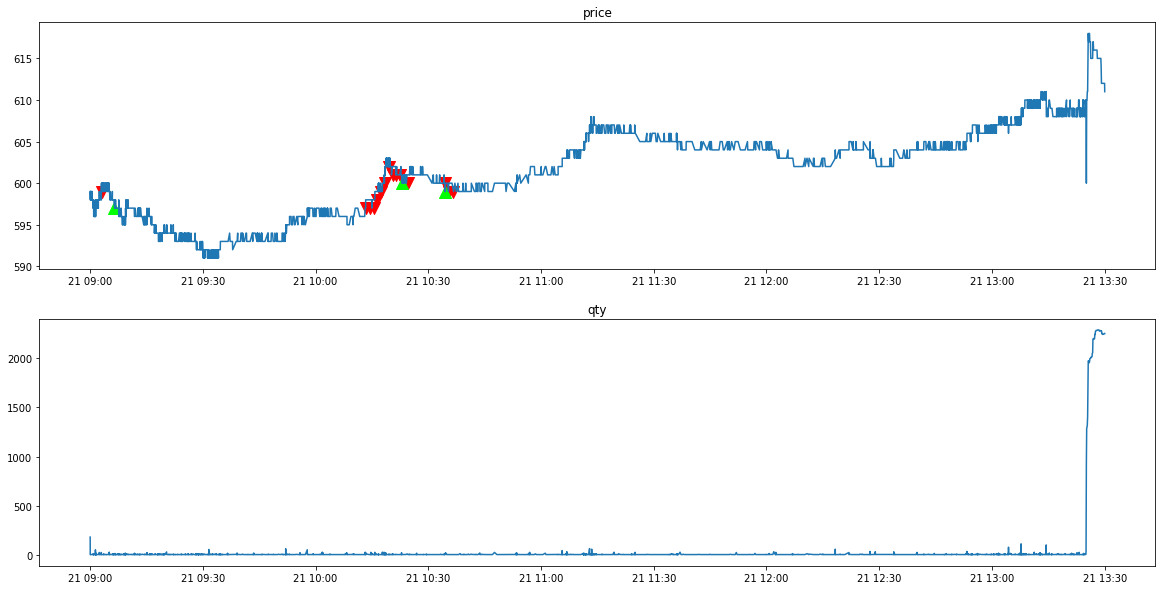

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90002456
*** bid1_p:  616.0
*** weighted_p:  614.3571428571429
ask1_p:  617.0
進場時間： 90331748 
  sell price at  616.0
stop profit
出場時間： 90458693
POSITION(pre):  [616.]
Order_p(pre):  [614.]
tick_row price:  614.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  617.0
*** weighted_p:  615.3099787685775
ask1_p:  618.0
進場時間： 90708965 
  sell price at  617.0
*** bid1_p:  617.0
*** weighted_p:  615.4036326942482
ask1_p:  618.0
進場時間： 90809665 
  sell price at  617.0
*** bid1_p:  618.0
*** weighted_p:  615.712134632418
ask1_p:  619.0
進場時間： 90909855 
  sell price at  618.0
*** bid1_p:  618.0
*** weighted_p:  616.0412371134021
ask1_p:  619.0
進場時間： 91010800 
  sell price at  618.0
*** bid1_p:  619.0
*** wei

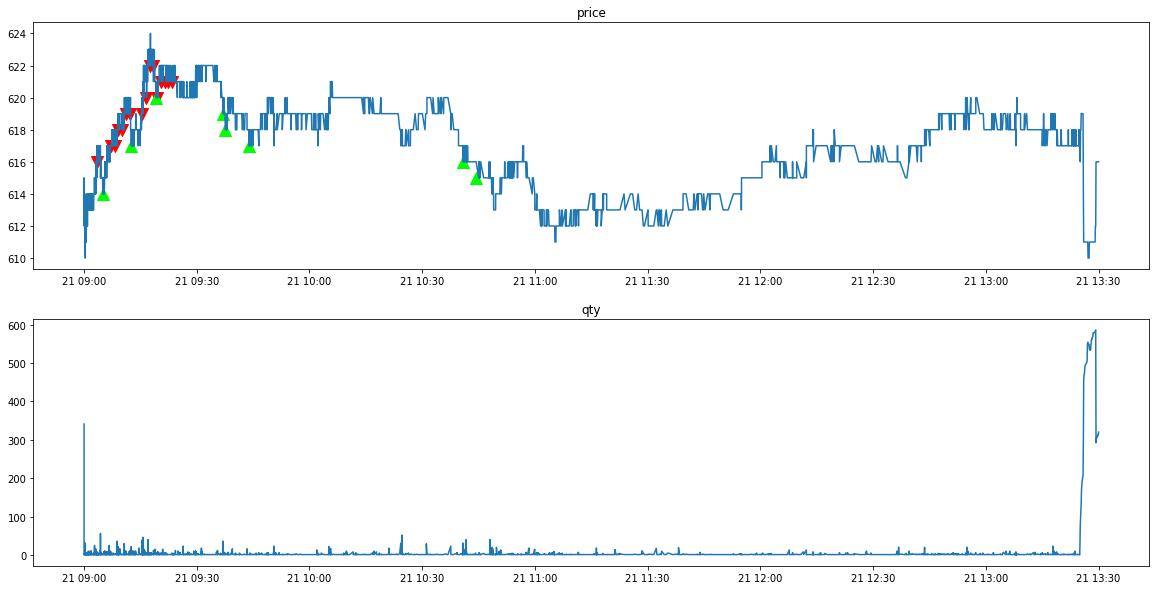

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90002610
*** bid1_p:  610.0
*** weighted_p:  608.2793209876543
ask1_p:  611.0
進場時間： 95107633 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  608.2907066052227
ask1_p:  611.0
進場時間： 95208034 
  sell price at  610.0
*** bid1_p:  610.0
*** weighted_p:  608.299272866437
ask1_p:  611.0
進場時間： 95310770 
  sell price at  610.0
*** bid1_p:  611.0
*** weighted_p:  608.3442437923251
ask1_p:  612.0
進場時間： 95410924 
  sell price at  611.0
*** bid1_p:  611.0
*** weighted_p:  608.3730454206999
ask1_p:  612.0
進場時間： 95510978 
  sell price at  611.0
*** bid1_p:  611.0
*** weighted_p:  608.3876945885842
ask1_p:  612.0
進場時間： 95611178 
  sell price at  611.0
*** bid1_p:  611.0
*** weighted_p:  608.3957871396896
ask1_p:  612.0
進場時間： 95

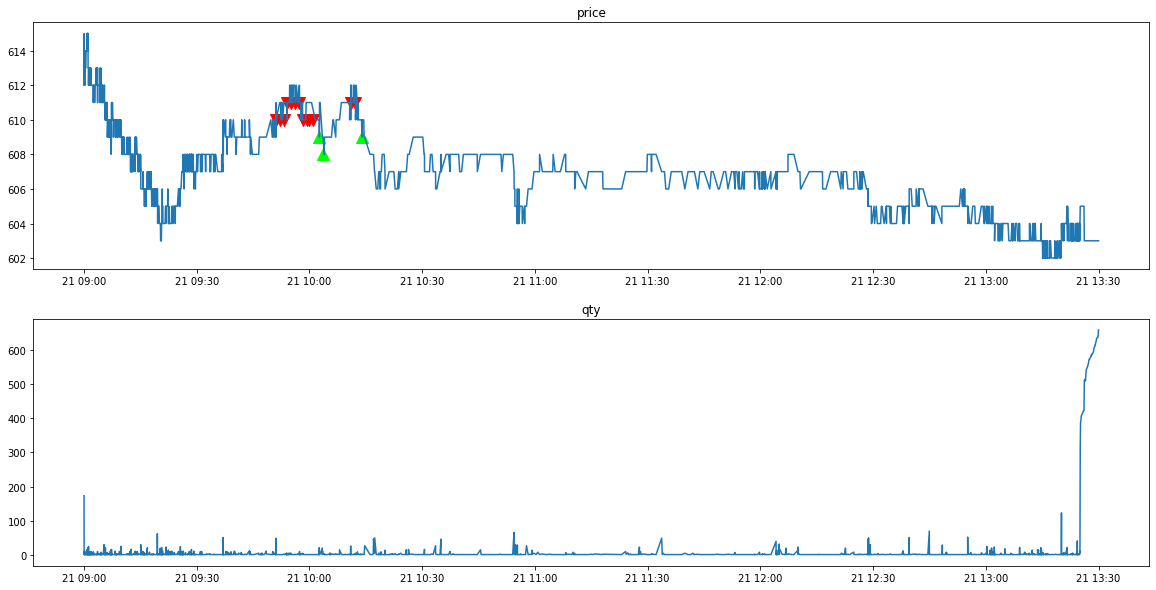

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90003781
*** bid1_p:  616.0
*** weighted_p:  614.3451957295374
ask1_p:  617.0
進場時間： 90445657 
  sell price at  616.0
stop profit
出場時間： 90543817
POSITION(pre):  [616.]
Order_p(pre):  [614.]
tick_row price:  614.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  616.0
*** weighted_p:  614.0377412849323
ask1_p:  617.0
進場時間： 104904848 
  sell price at  616.0
*** bid1_p:  617.0
*** weighted_p:  614.1513888888888
ask1_p:  618.0
進場時間： 105005109 
  sell price at  617.0
*** bid1_p:  616.0
*** weighted_p:  614.167310877968
ask1_p:  617.0
進場時間： 105107079 
  sell price at  616.0
*** bid1_p:  616.0
*** weighted_p:  614.1698841698842
ask1_p:  617.0
進場時間： 105207196 
  sell price at  616.0
*** bid1_p:  616.0
***

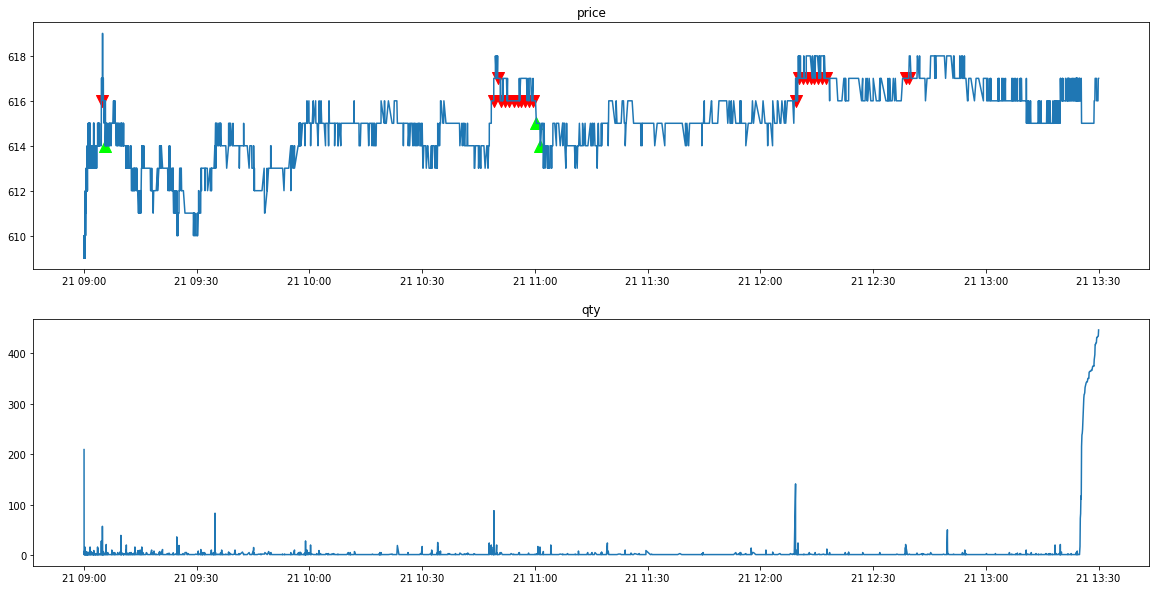

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90003676
*** bid1_p:  611.0
*** weighted_p:  609.3384615384615
ask1_p:  613.0
進場時間： 90220505 
  sell price at  611.0
*** bid1_p:  612.0
*** weighted_p:  609.7349397590361
ask1_p:  613.0
進場時間： 90321621 
  sell price at  612.0
*** bid1_p:  612.0
*** weighted_p:  610.285
ask1_p:  613.0
進場時間： 90422167 
  sell price at  612.0
*** bid1_p:  613.0
*** weighted_p:  610.9251439539347
ask1_p:  614.0
進場時間： 90522225 
  sell price at  613.0
*** bid1_p:  613.0
*** weighted_p:  611.2676282051282
ask1_p:  614.0
進場時間： 90628217 
  sell price at  613.0
stop profit
出場時間： 90650313
POSITION(pre):  [611. 612. 612. 613. 613.]
Order_p(pre):  [608. 610. 610. 611. 611.]
tick_row price:  611.0
qualified index:  [[3]
 [4]]
POSITION(post):  [611. 612. 61

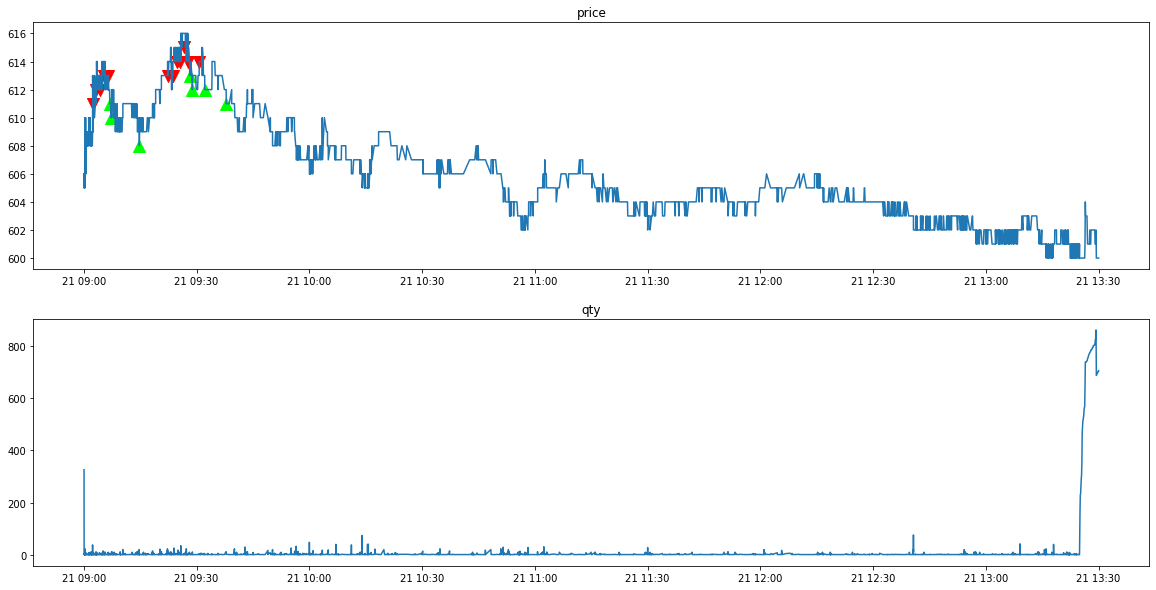

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2454/tse_lob_2454.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2454/tse_tick_2454.csv' mode='r' encoding='UTF-8'>
90004455
clear_position:  0.0
position:  []
tick_row_price 588.0
----------Result Report--------------
profit:  0.0


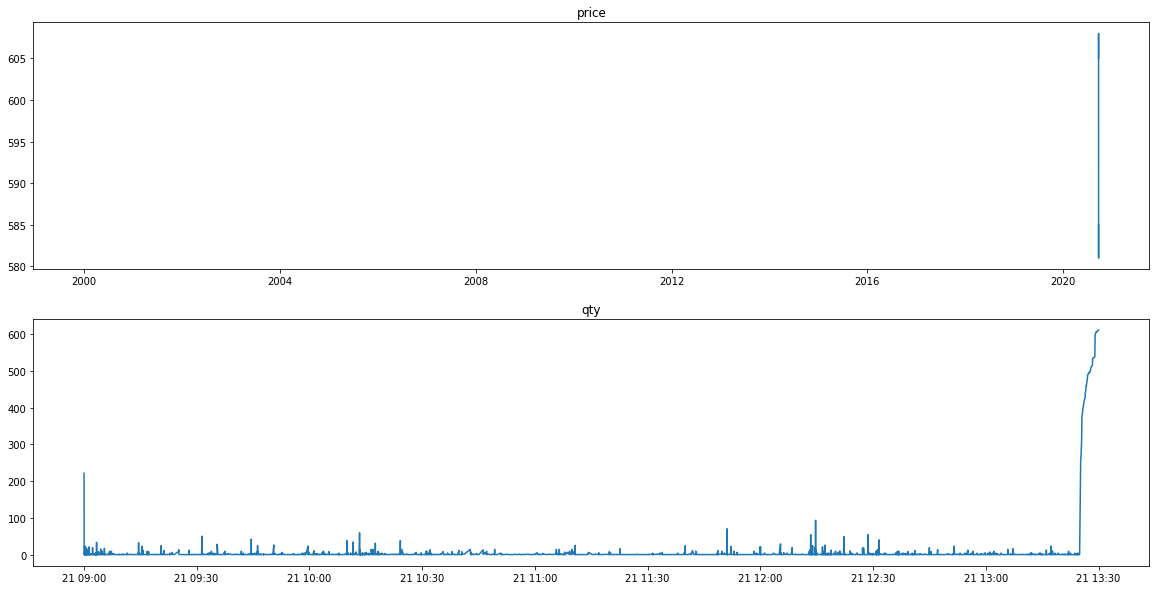

In [ ]:
para = {"sid": "2454", "beta":2, "time_out": 2000000, "gamma": 0.75, "cool_down_min": 100000, "stop_loss_factor": 1.02, "theta": 1.0025, "position_max_q": 10}

res_2454 = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), **para)
profit_2454, cost_2454 = calculate_profit(res_2454)

In [ ]:
profit_2454

-18.0

In [ ]:
cost_2454

98188.0

#### 2317



<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002287
*** bid1_p:  77.1
*** weighted_p:  76.90485422949925
ask1_p:  77.2
進場時間： 93928946 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.90527598566351
ask1_p:  77.2
進場時間： 94029154 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.90615626339131
ask1_p:  77.2
進場時間： 94129344 
  sell price at  77.1
stop profit
出場時間： 94653751
POSITION(pre):  [77.1 77.1 77.1]
Order_p(pre):  [76.9 76.9 76.9]
tick_row price:  76.9
qualified index:  [[0]
 [1]
 [2]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  77.2
*** weighted_p:  76.94970059880264
ask1_p:  77.3
進場時間： 124324606 
  sell price at  77.2
*** bid1_p:  77.3
*** weighted_p:  76.95797212543576
ask1_p:  77.4
進場時間： 124425595 
  sell price at  77.3
*** bid1_

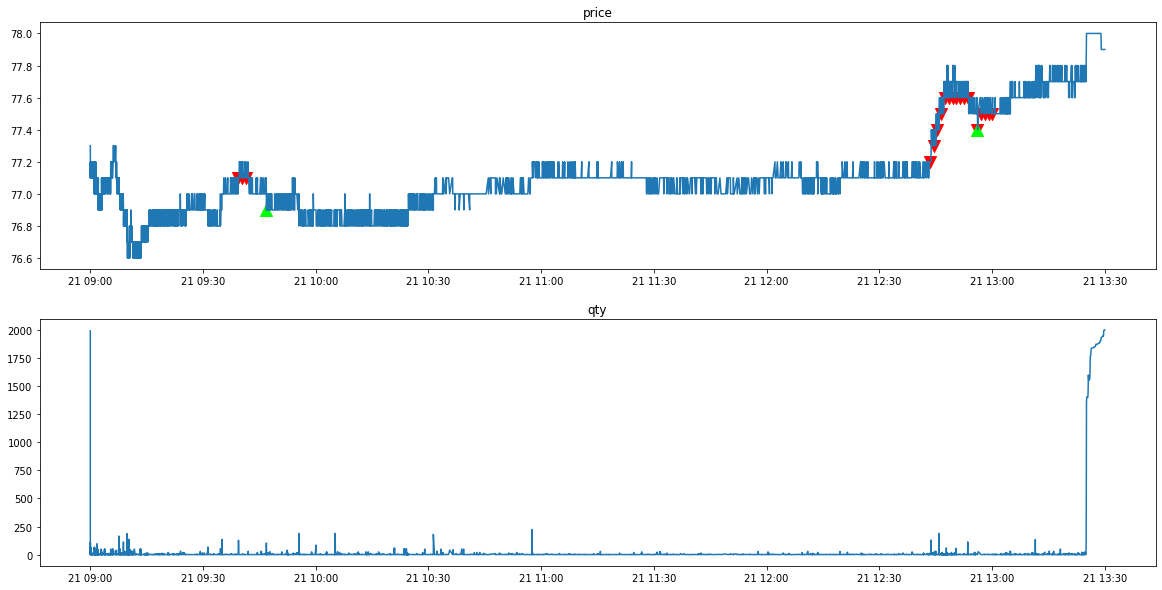

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002496
*** bid1_p:  78.6
*** weighted_p:  78.37324635241323
ask1_p:  78.7
進場時間： 91458274 
  sell price at  78.6
*** bid1_p:  78.6
*** weighted_p:  78.38567785234902
ask1_p:  78.7
進場時間： 91558293 
  sell price at  78.6
stop profit
出場時間： 91755639
POSITION(pre):  [78.6 78.6]
Order_p(pre):  [78.4 78.4]
tick_row price:  78.4
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 78.2
----------Result Report--------------
profit:  0.39999999999997726


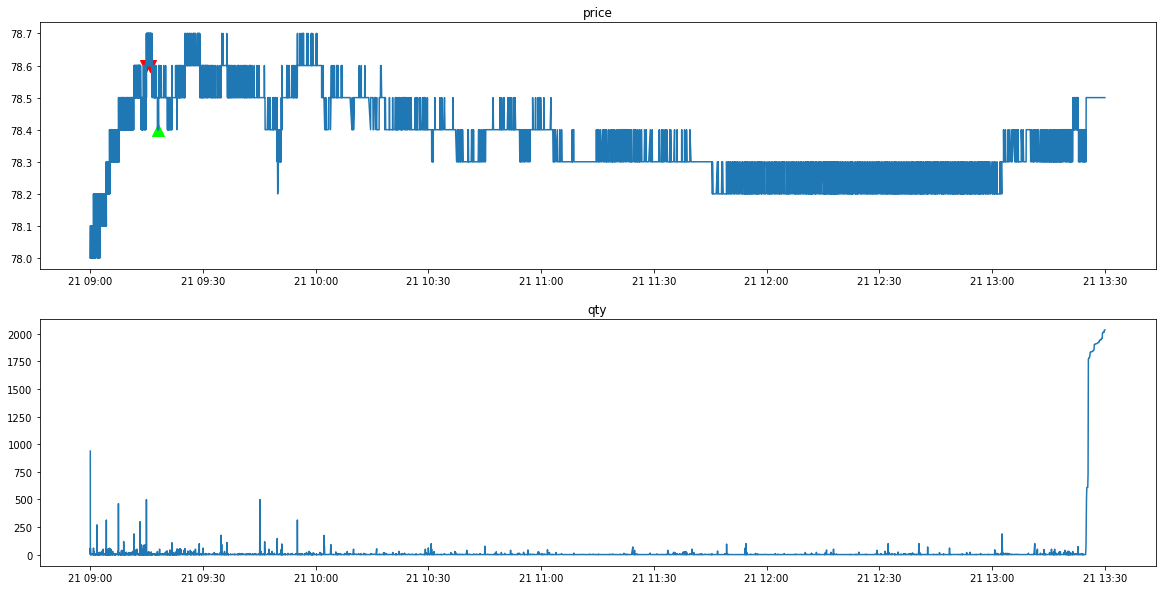

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002380
clear_position:  0.0
position:  []
tick_row_price 78.3
----------Result Report--------------
profit:  0.0


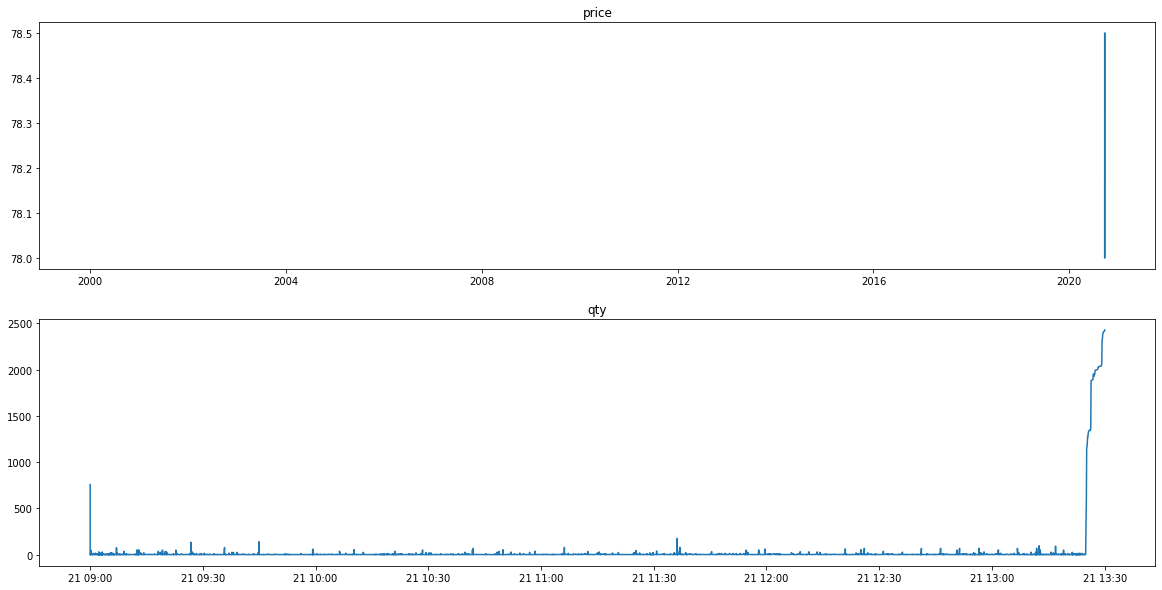

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90003102
*** bid1_p:  79.1
*** weighted_p:  78.88535104364328
ask1_p:  79.2
進場時間： 95600610 
  sell price at  79.1
*** bid1_p:  79.1
*** weighted_p:  78.88907458219003
ask1_p:  79.2
進場時間： 95700801 
  sell price at  79.1
*** bid1_p:  79.2
*** weighted_p:  78.93116797900268
ask1_p:  79.3
進場時間： 95800896 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.94083953241233
ask1_p:  79.3
進場時間： 95902041 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.94367161977026
ask1_p:  79.3
進場時間： 100000362 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.94814391182281
ask1_p:  79.3
進場時間： 100101039 
  sell price at  79.2
*** bid1_p:  79.2
*** weighted_p:  78.9504639175257
ask1_p:  79.3
進場時間： 100201202 
  sell pr

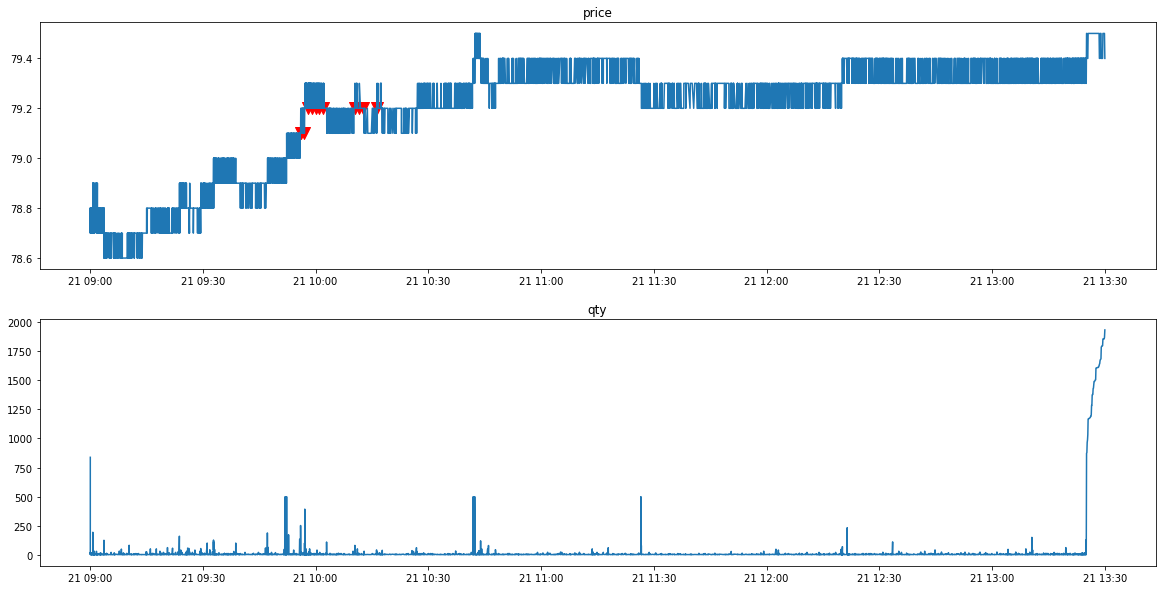

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90001658
clear_position:  0.0
position:  []
tick_row_price 79.1
----------Result Report--------------
profit:  0.0


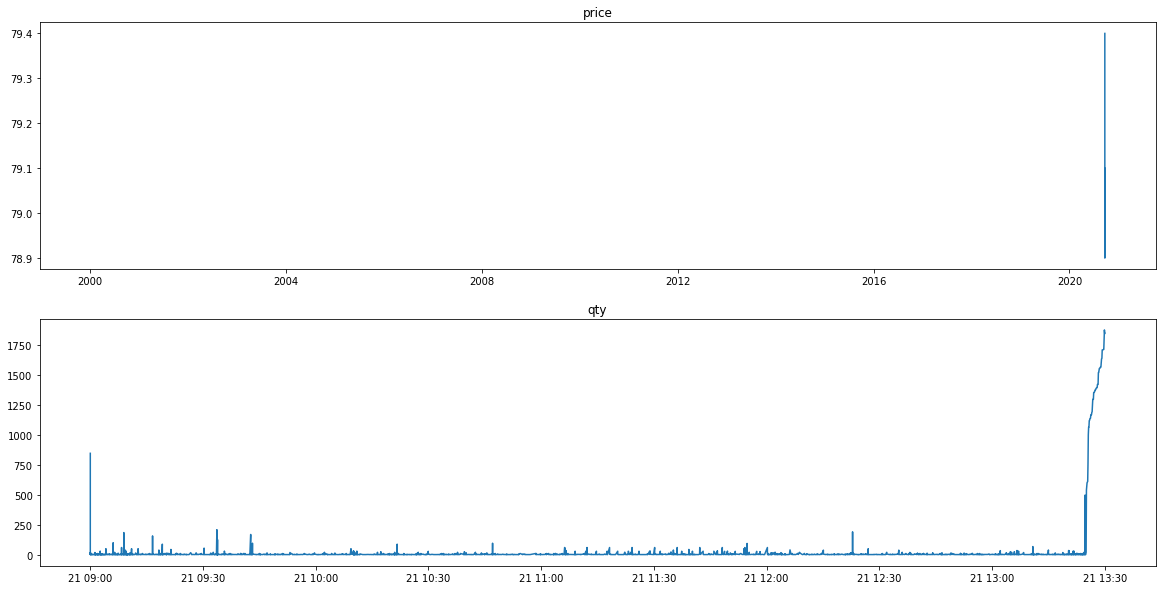

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002705
clear_position:  0.0
position:  []
tick_row_price 78.7
----------Result Report--------------
profit:  0.0


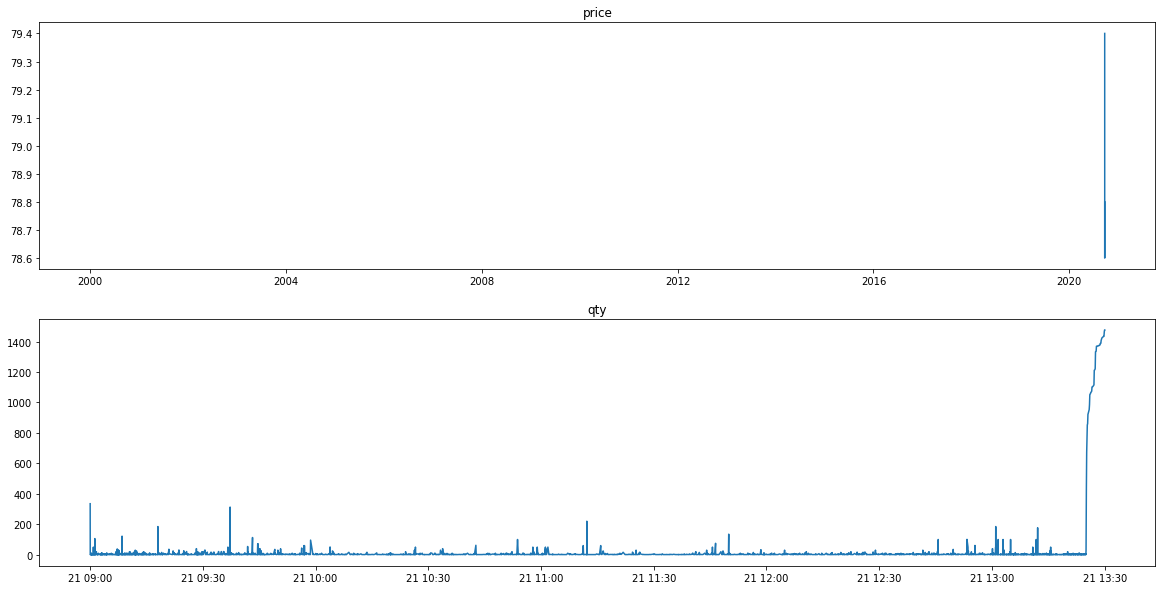

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002344
------Weird price!!!!!---------
At time:  90108814
tick_row_price 78.6
ask_1_p 78.7
bid_1_p 78.5
clear_position:  0.0
position:  []
tick_row_price 78.0
----------Result Report--------------
profit:  0.0


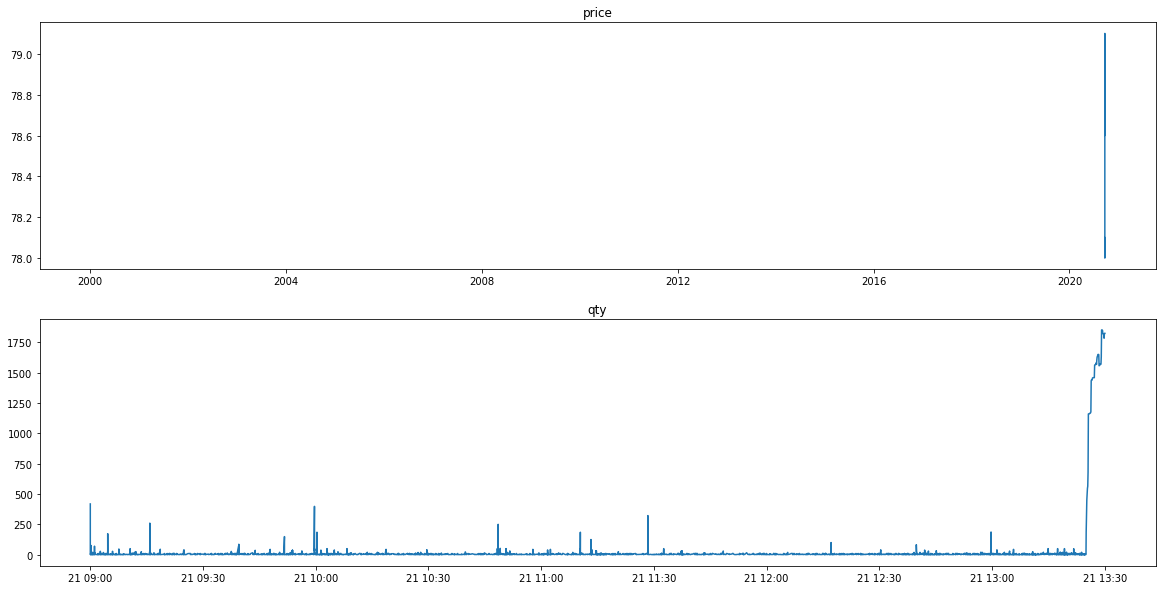

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002663
*** bid1_p:  78.0
*** weighted_p:  77.79932342388588
ask1_p:  78.1
進場時間： 110556774 
  sell price at  78.0
*** bid1_p:  78.0
*** weighted_p:  77.79984667280044
ask1_p:  78.1
進場時間： 110658751 
  sell price at  78.0
*** bid1_p:  78.0
*** weighted_p:  77.801413319777
ask1_p:  78.1
進場時間： 110759385 
  sell price at  78.0
*** bid1_p:  78.0
*** weighted_p:  77.80299292214424
ask1_p:  78.1
進場時間： 110900208 
  sell price at  78.0
*** bid1_p:  78.1
*** weighted_p:  77.80569138276617
ask1_p:  78.2
進場時間： 111002460 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.80600720865101
ask1_p:  78.2
進場時間： 111103257 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.80686245130416
ask1_p:  78.2
進場時間： 111203801 
  sell

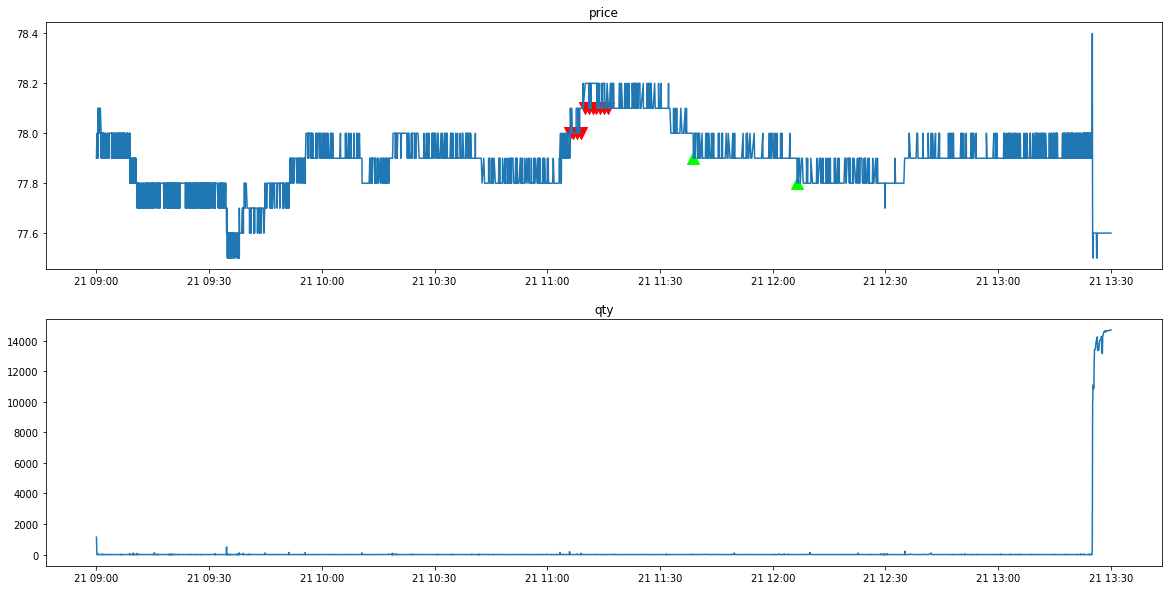

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002368
*** bid1_p:  78.0
*** weighted_p:  77.80462165835961
ask1_p:  78.1
進場時間： 92423580 
  sell price at  78.0
*** bid1_p:  78.1
*** weighted_p:  77.82755314714453
ask1_p:  78.2
進場時間： 92524773 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.862495274102
ask1_p:  78.2
進場時間： 92625229 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.87106038291603
ask1_p:  78.2
進場時間： 92725286 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.88060714285716
ask1_p:  78.2
進場時間： 92825518 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.88563400070254
ask1_p:  78.2
進場時間： 92926636 
  sell price at  78.1
*** bid1_p:  78.1
*** weighted_p:  77.88967428967435
ask1_p:  78.2
進場時間： 93027136 
  sell price 

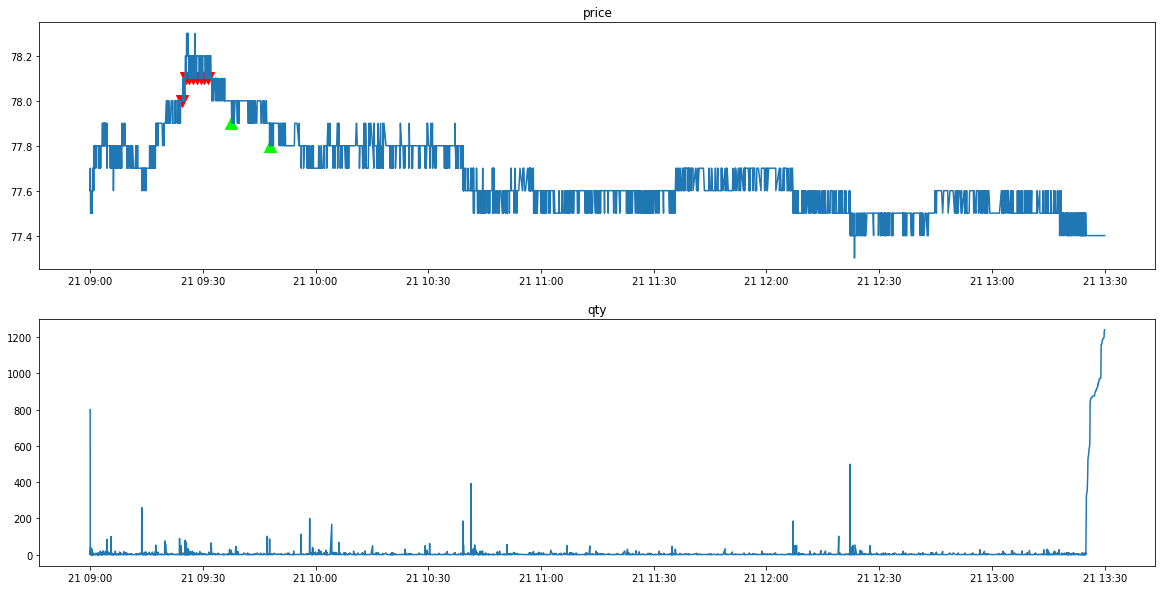

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002615
*** bid1_p:  77.1
*** weighted_p:  76.88265975144313
ask1_p:  77.2
進場時間： 94933756 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88321780728273
ask1_p:  77.2
進場時間： 95035801 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88353319684087
ask1_p:  77.2
進場時間： 95137051 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88371164149991
ask1_p:  77.2
進場時間： 95238670 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88463480963445
ask1_p:  77.2
進場時間： 95341953 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88474905348959
ask1_p:  77.2
進場時間： 95442507 
  sell price at  77.1
*** bid1_p:  77.1
*** weighted_p:  76.88507028599089
ask1_p:  77.2
進場時間： 95546436 
  sell pric

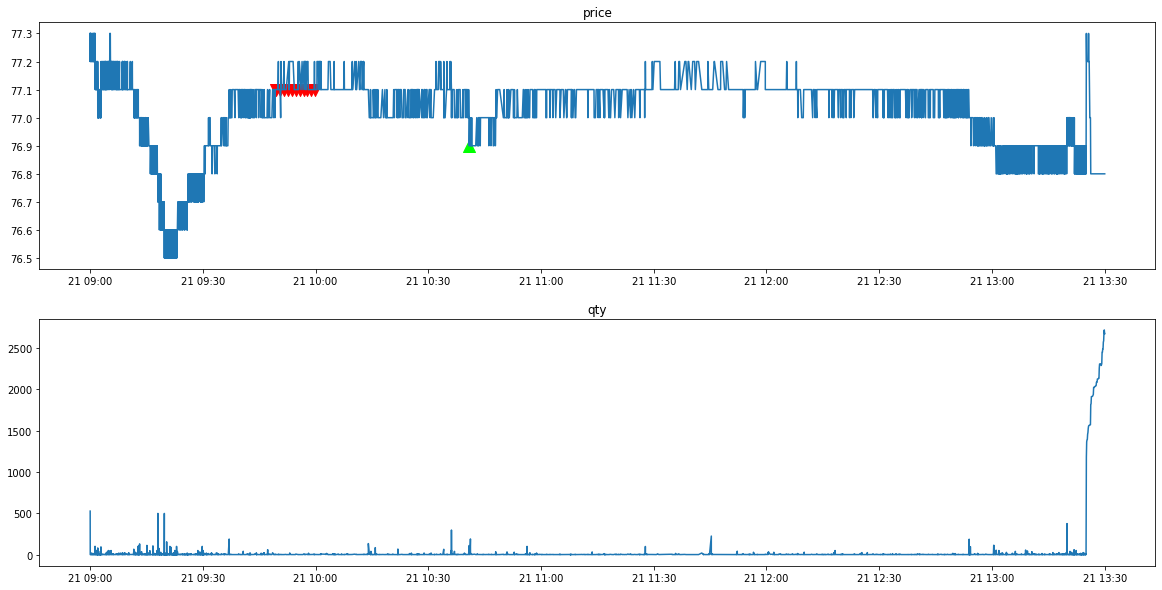

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002377
clear_position:  0.0
position:  []
tick_row_price 76.9
----------Result Report--------------
profit:  0.0


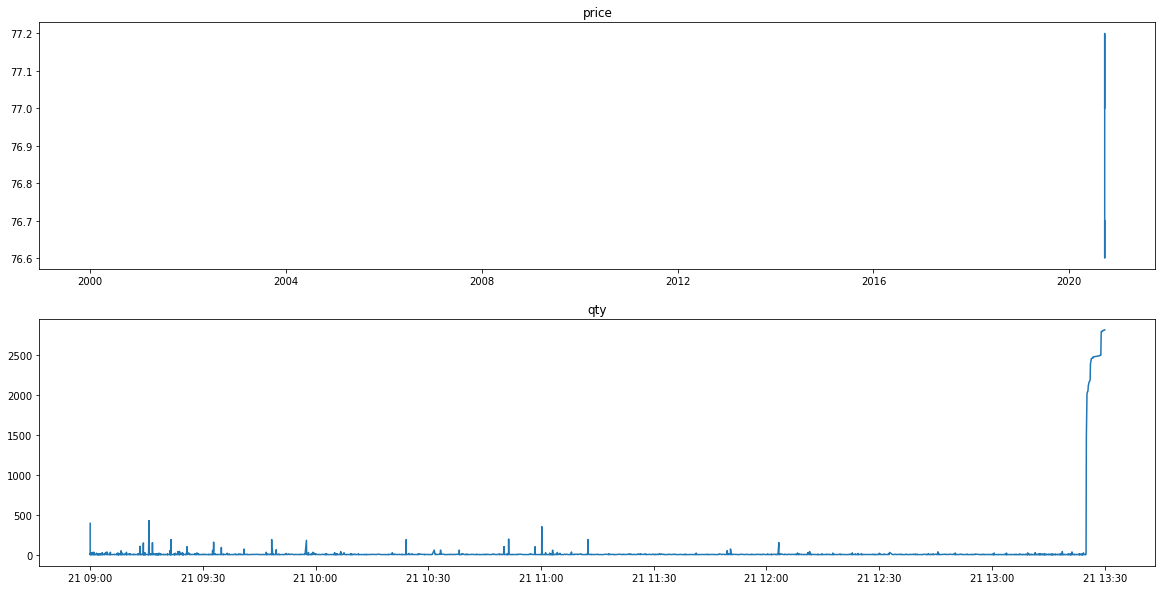

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90002699
clear_position:  0.0
position:  []
tick_row_price 75.0
----------Result Report--------------
profit:  0.0


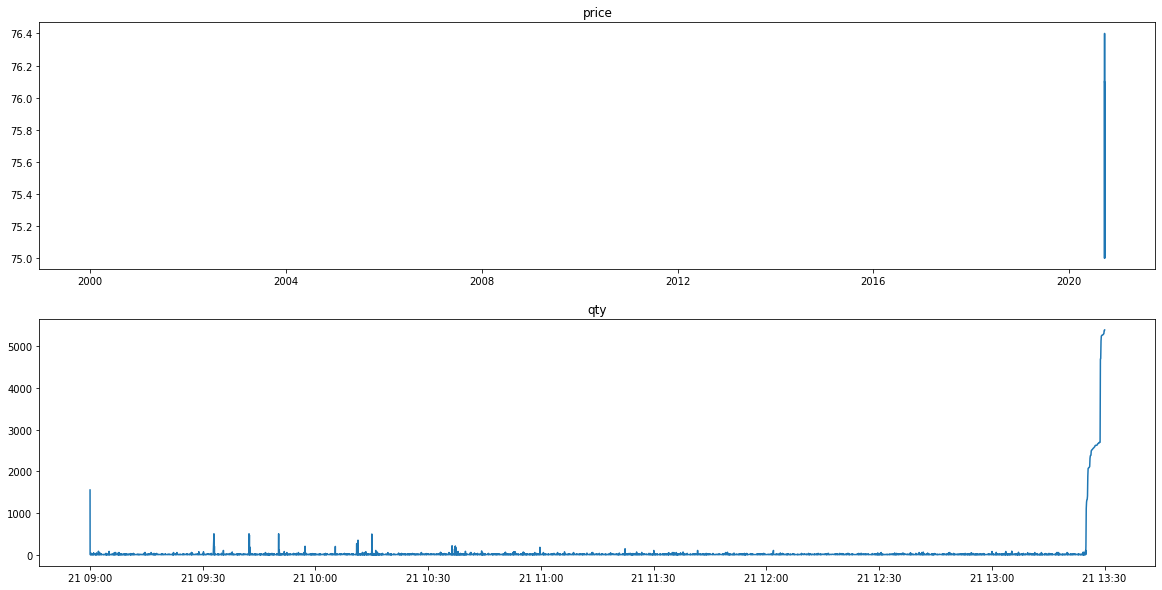

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2317/tse_lob_2317.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2317/tse_tick_2317.csv' mode='r' encoding='UTF-8'>
90001647
clear_position:  0.0
position:  []
tick_row_price 74.3
----------Result Report--------------
profit:  0.0


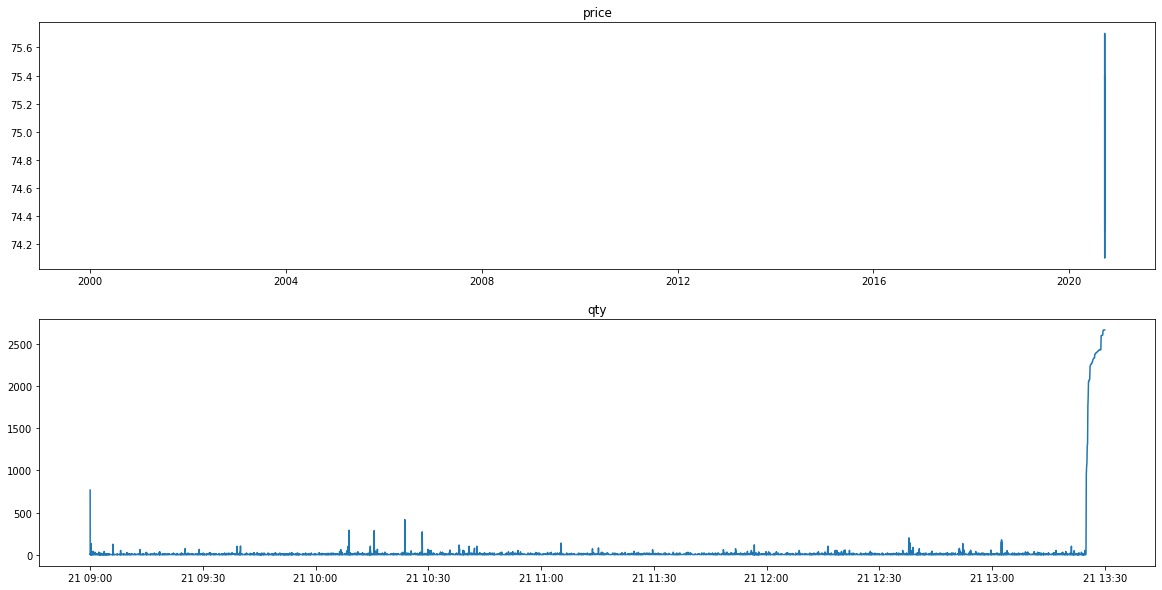

In [ ]:
para = {"sid": "2317", "beta":2, "time_out": 2000000, "gamma": 0.75, "cool_down_min": 100000, "stop_loss_factor": 1.02, "theta": 1.0025, "position_max_q": 10}

res_2317 = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), **para)
profit_2317, cost_2317 = calculate_profit(res_2317)

In [ ]:
profit_2317

5.299999999999557

In [ ]:
cost_2317

4831.000000000001

### 2912

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90019533
clear_position:  0.0
position:  []
tick_row_price 266.0
----------Result Report--------------
profit:  0.0


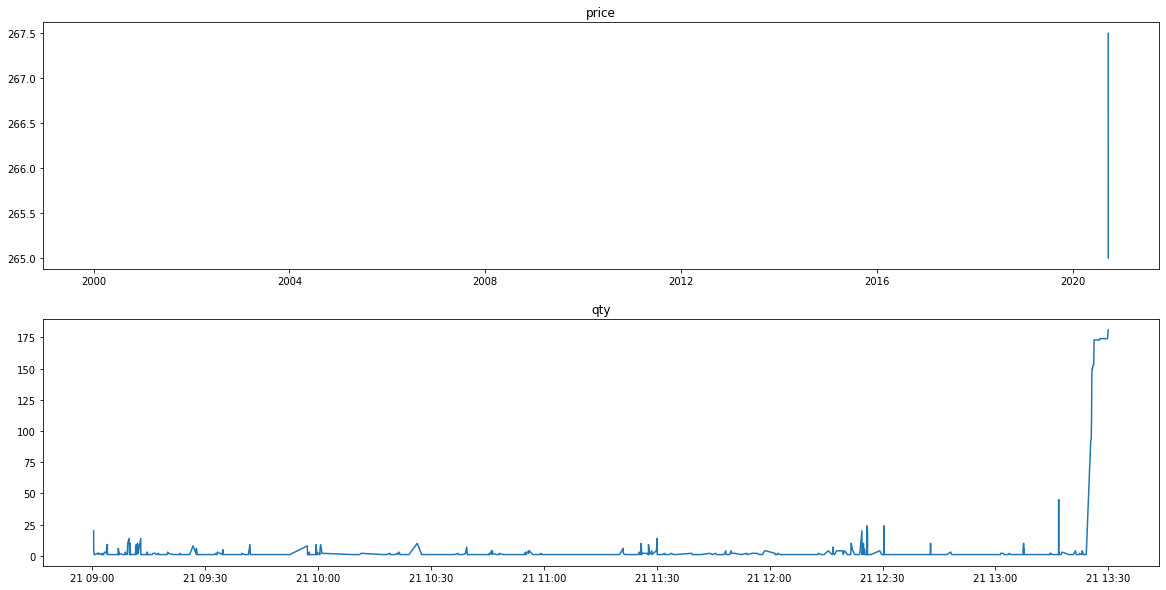

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90016905
*** bid1_p:  265.0
*** weighted_p:  264.1326714801444
ask1_p:  265.5
進場時間： 105850986 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.14132379248656
ask1_p:  265.5
進場時間： 110419509 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.14285714285717
ask1_p:  265.5
進場時間： 110521801 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.14285714285717
ask1_p:  265.5
進場時間： 110627229 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.14285714285717
ask1_p:  265.5
進場時間： 110738392 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.14285714285717
ask1_p:  265.5
進場時間： 110901175 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.14285714285717
ask1_p:  2

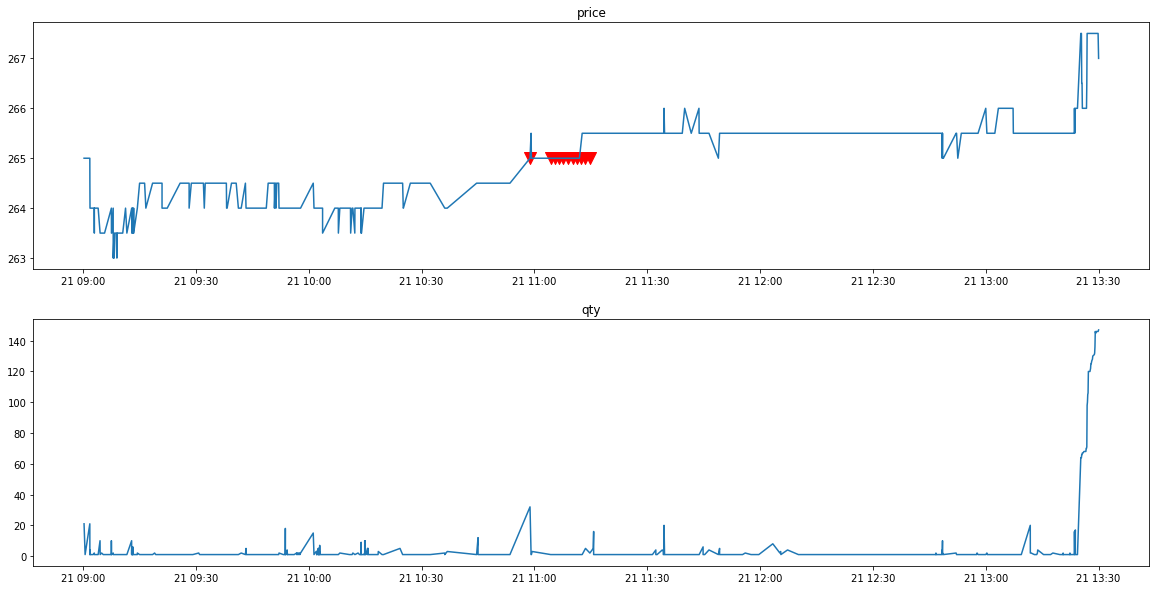

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90020184
*** bid1_p:  266.0
*** weighted_p:  0
ask1_p:  266.5
進場時間： 90210177 
  sell price at  266.0
stop profit
出場時間： 94527650
POSITION(pre):  [266.]
Order_p(pre):  [265.]
tick_row price:  265.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 265.5
----------Result Report--------------
profit:  1.0


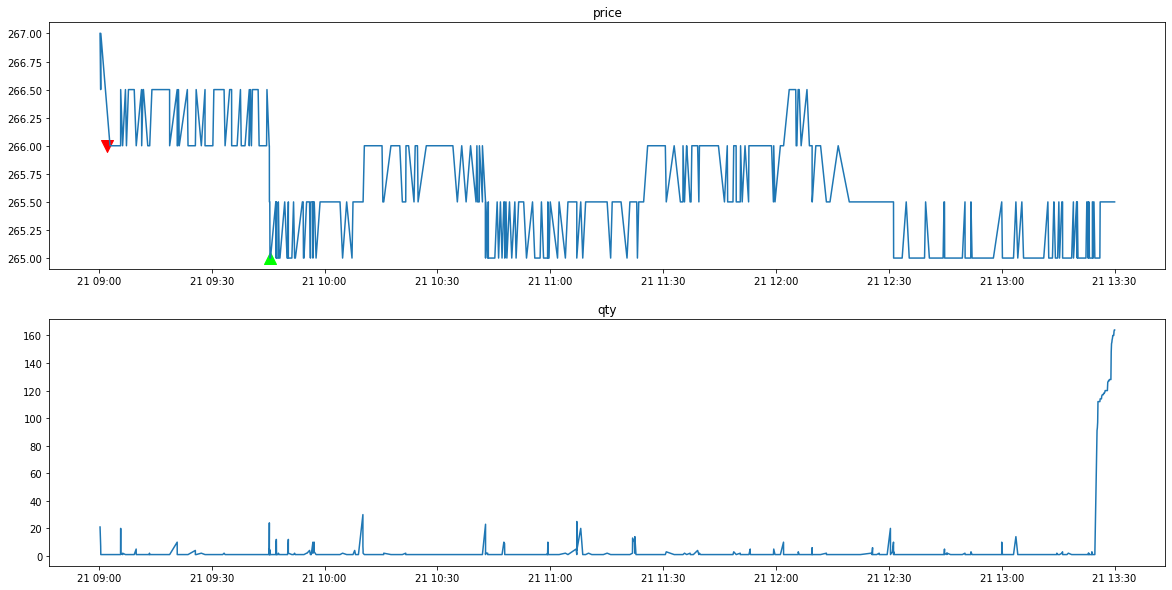

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90019794
clear_position:  0.0
position:  []
tick_row_price 267.0
----------Result Report--------------
profit:  0.0


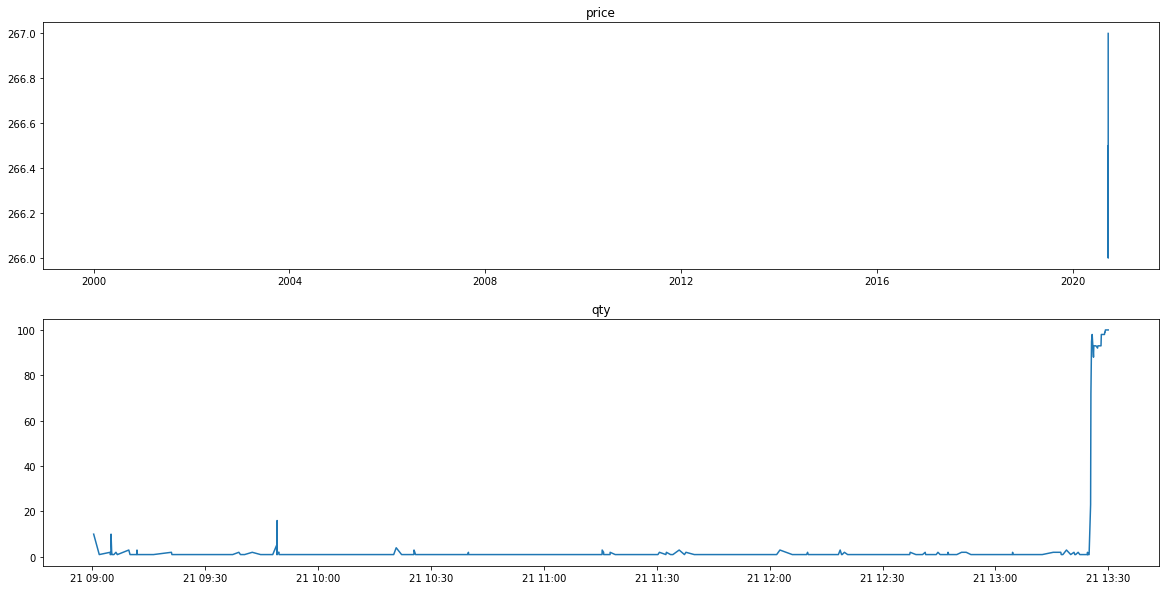

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90023121
*** bid1_p:  265.5
*** weighted_p:  0
ask1_p:  266.5
進場時間： 90207163 
  sell price at  265.5
clear_position:  -0.5
position:  [265.5]
tick_row_price 266.0
----------Result Report--------------
profit:  -0.5


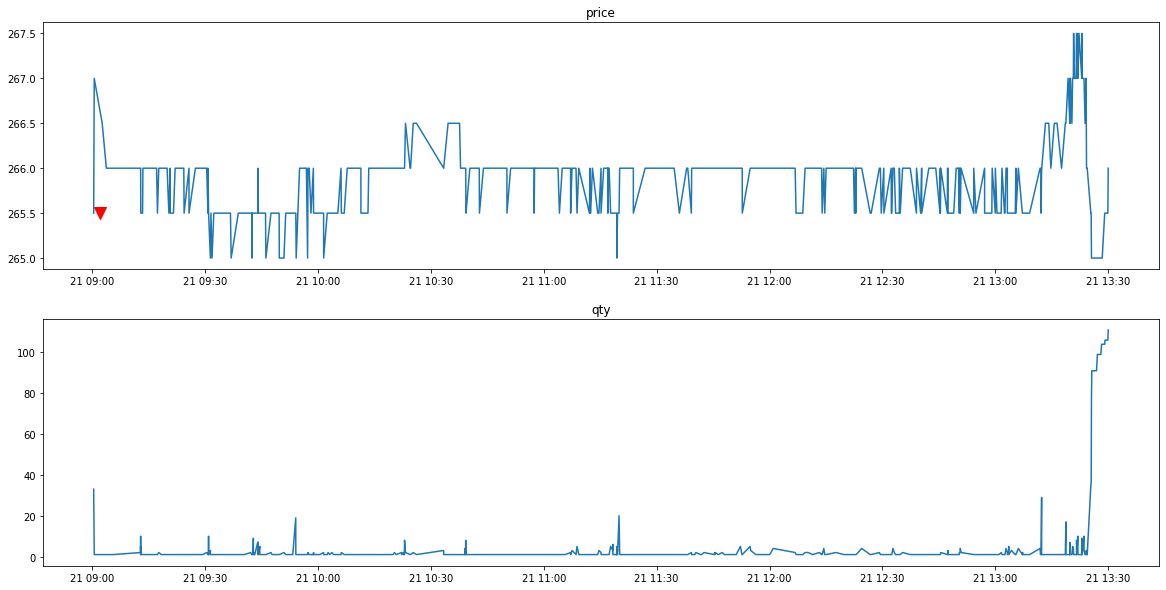

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90018175
*** bid1_p:  266.0
*** weighted_p:  265.15384615384613
ask1_p:  266.5
進場時間： 94548927 
  sell price at  266.0
*** bid1_p:  266.0
*** weighted_p:  265.1758957654723
ask1_p:  266.5
進場時間： 94651152 
  sell price at  266.0
*** bid1_p:  266.0
*** weighted_p:  265.18284789644014
ask1_p:  266.5
進場時間： 94751415 
  sell price at  266.0
*** bid1_p:  266.0
*** weighted_p:  265.18709677419355
ask1_p:  266.5
進場時間： 94851527 
  sell price at  266.0
*** bid1_p:  266.0
*** weighted_p:  265.1980830670926
ask1_p:  266.5
進場時間： 94951544 
  sell price at  266.0
stop profit
出場時間： 95456124
POSITION(pre):  [266. 266. 266. 266. 266.]
Order_p(pre):  [265. 265. 265. 265. 265.]
tick_row price:  265.0
qualified index:  [[0]
 [1]
 [2]
 [3]
 [4]]
PO

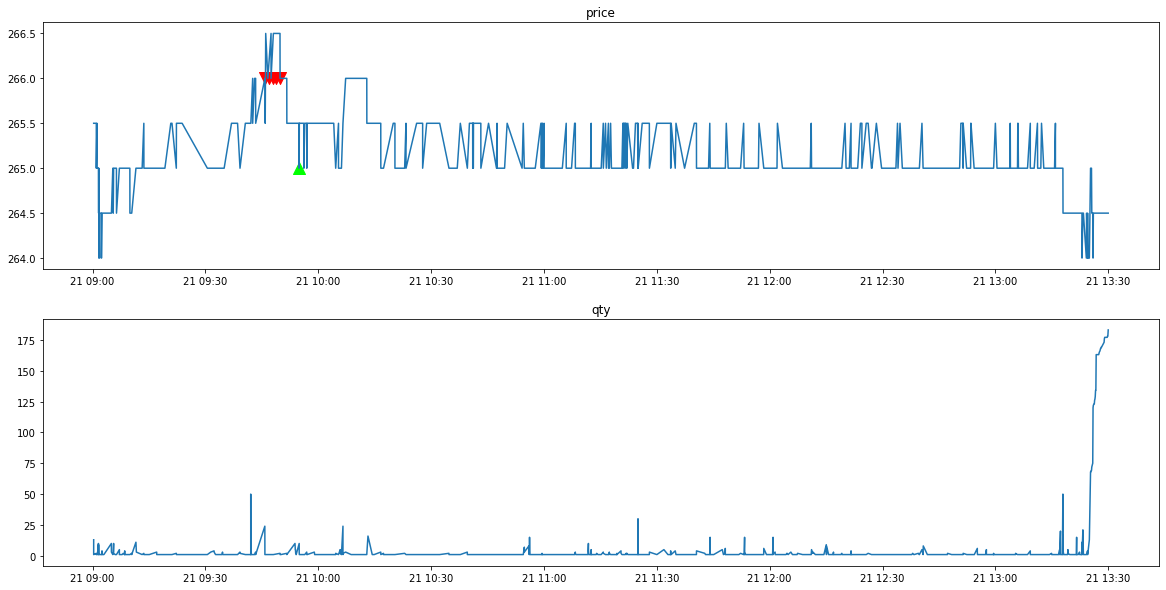

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90017851
clear_position:  0.0
position:  []
tick_row_price 264.0
----------Result Report--------------
profit:  0.0


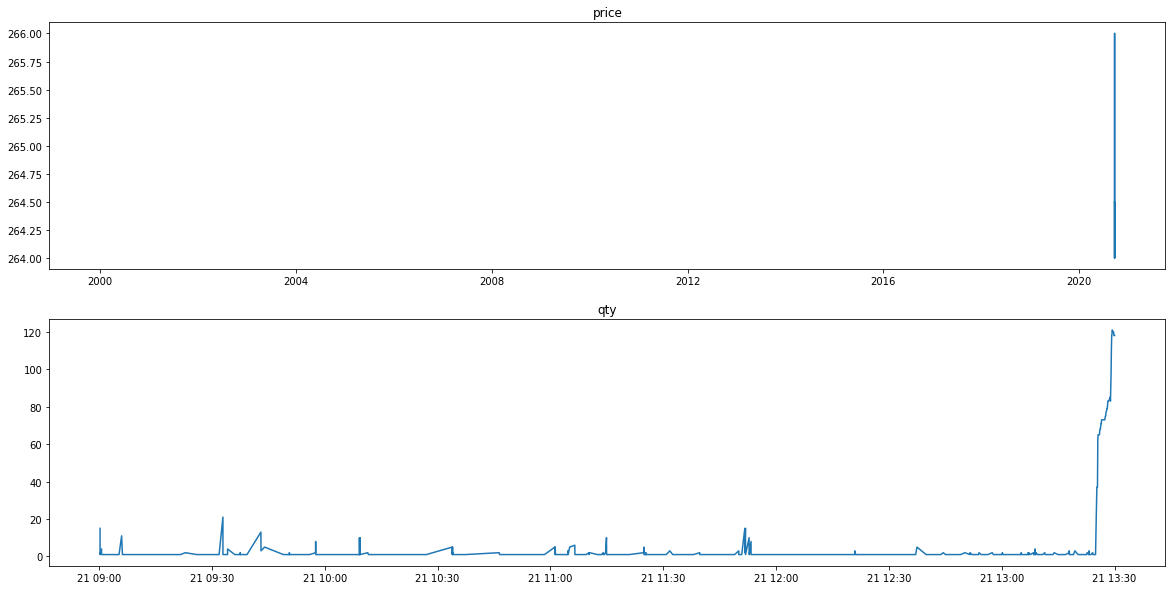

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90020530
*** bid1_p:  265.0
*** weighted_p:  0
ask1_p:  265.5
進場時間： 90207067 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  0
ask1_p:  265.5
進場時間： 90309186 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  0
ask1_p:  265.5
進場時間： 90412827 
  sell price at  265.0
stop profit
出場時間： 101622446
POSITION(pre):  [265. 265. 265.]
Order_p(pre):  [264. 264. 264.]
tick_row price:  264.0
qualified index:  [[0]
 [1]
 [2]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 264.5
----------Result Report--------------
profit:  3.0


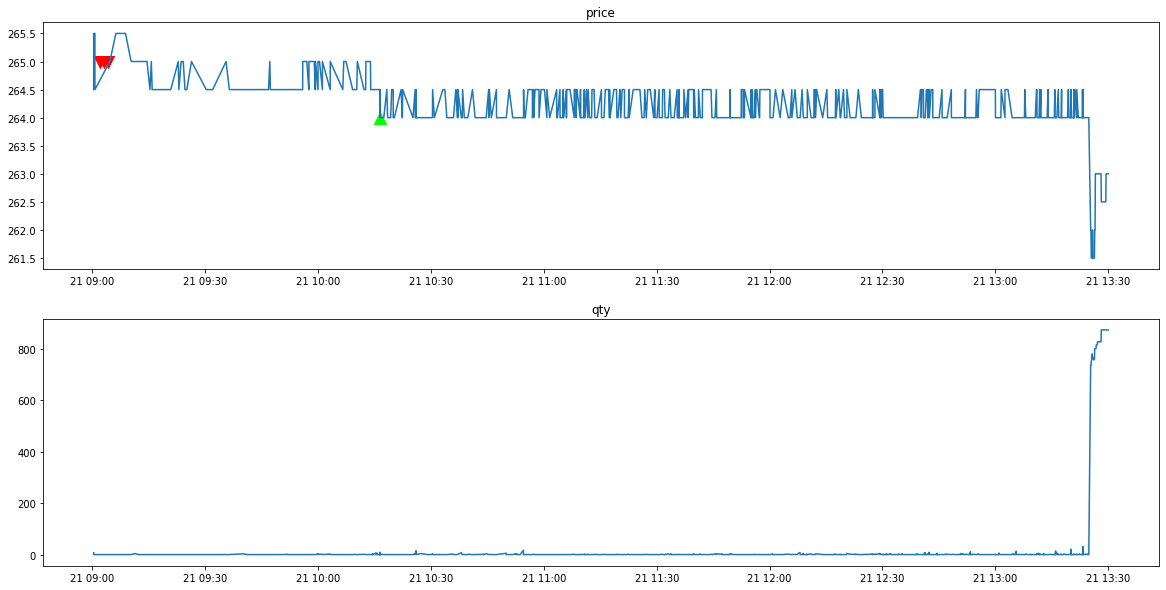

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90019505
*** bid1_p:  264.0
*** weighted_p:  263.2242647058824
ask1_p:  264.5
進場時間： 93058237 
  sell price at  264.0
*** bid1_p:  264.0
*** weighted_p:  263.2427536231884
ask1_p:  264.5
進場時間： 93158324 
  sell price at  264.0
*** bid1_p:  264.0
*** weighted_p:  263.2695035460993
ask1_p:  264.5
進場時間： 93304023 
  sell price at  264.0
*** bid1_p:  264.0
*** weighted_p:  263.2695035460993
ask1_p:  264.5
進場時間： 93407825 
  sell price at  264.0
*** bid1_p:  264.0
*** weighted_p:  263.31164383561645
ask1_p:  264.5
進場時間： 93517259 
  sell price at  264.0
*** bid1_p:  264.0
*** weighted_p:  263.33557046979865
ask1_p:  264.5
進場時間： 93624124 
  sell price at  264.0
*** bid1_p:  264.5
*** weighted_p:  263.4610778443114
ask1_p:  265.0
進場時間：

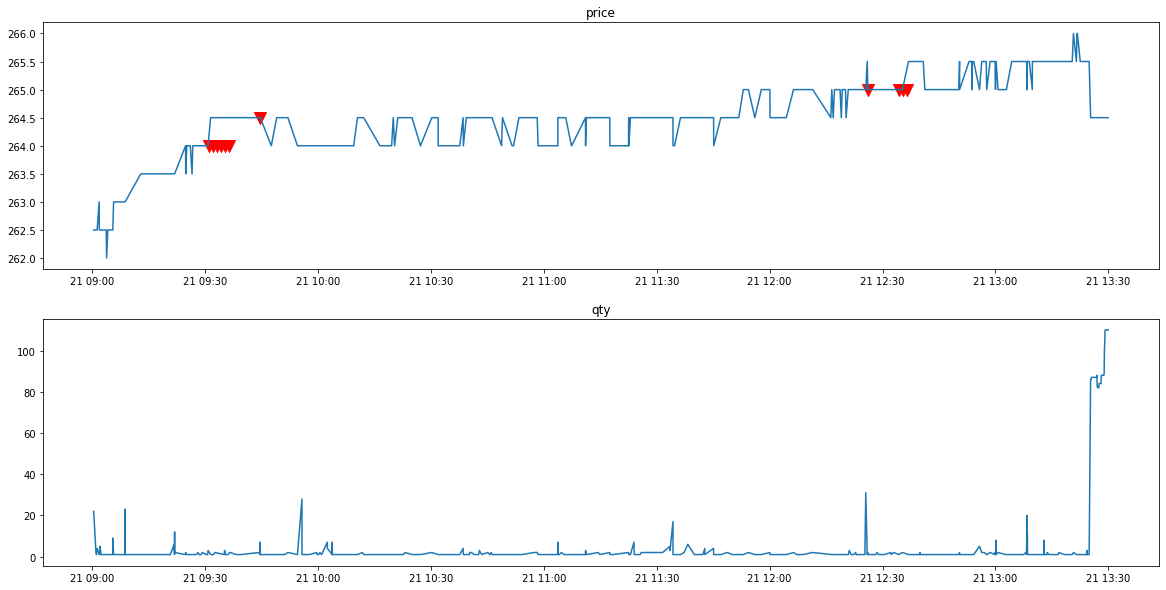

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90020075
*** bid1_p:  265.0
*** weighted_p:  263.99444444444447
ask1_p:  265.5
進場時間： 91053558 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.010989010989
ask1_p:  265.5
進場時間： 91157703 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.0833333333333
ask1_p:  265.5
進場時間： 91258267 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.1485148514852
ask1_p:  266.0
進場時間： 91359083 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.2056074766355
ask1_p:  265.5
進場時間： 91500975 
  sell price at  265.0
*** bid1_p:  265.0
*** weighted_p:  264.22727272727275
ask1_p:  265.5
進場時間： 91701705 
  sell price at  265.0
stop profit
出場時間： 92301222
POSITION(pre):  [265. 265. 265. 265. 265. 265.]


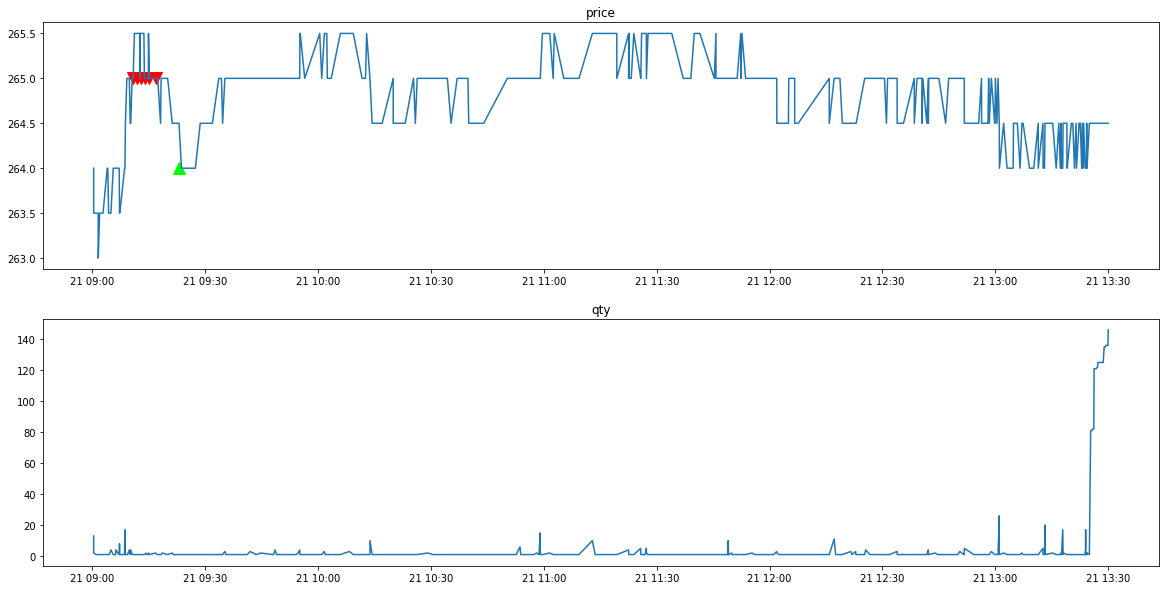

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90019430
clear_position:  0.0
position:  []
tick_row_price 261.5
----------Result Report--------------
profit:  0.0


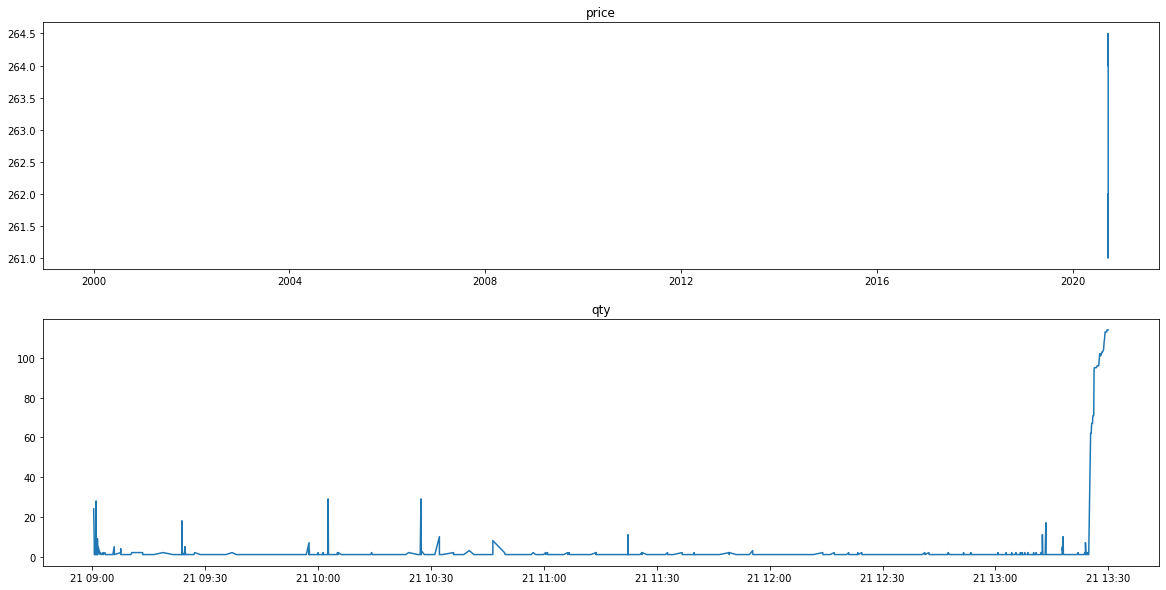

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90016123
clear_position:  0.0
position:  []
tick_row_price 254.0
----------Result Report--------------
profit:  0.0


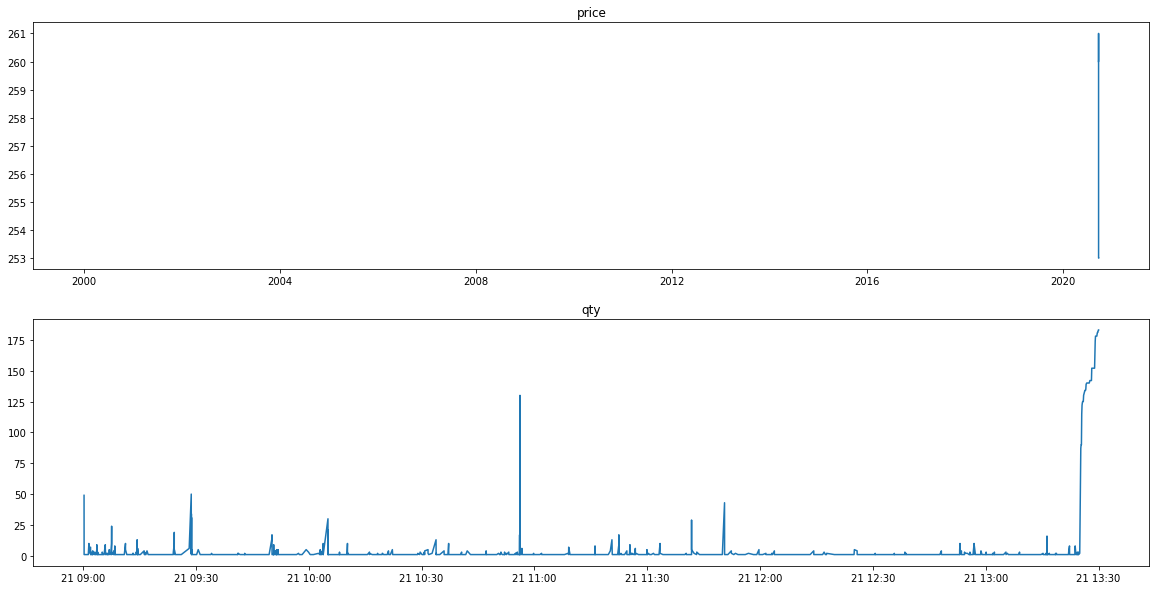

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2912/tse_lob_2912.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/2912/tse_tick_2912.csv' mode='r' encoding='UTF-8'>
90011747
*** bid1_p:  258.0
*** weighted_p:  256.6197632058288
ask1_p:  258.5
進場時間： 123643873 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.6552795031056
ask1_p:  258.5
進場時間： 123746086 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.65647163120565
ask1_p:  258.5
進場時間： 123847110 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.6597345132743
ask1_p:  258.5
進場時間： 123951083 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.6625441696113
ask1_p:  258.5
進場時間： 124052604 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.6880973066898
ask1_p:  258.5
進場時間： 124200211 
  sell price at  258.0
*** bid1_p:  258.0
*** weighted_p:  256.6974935177182
ask1_p:  258.5


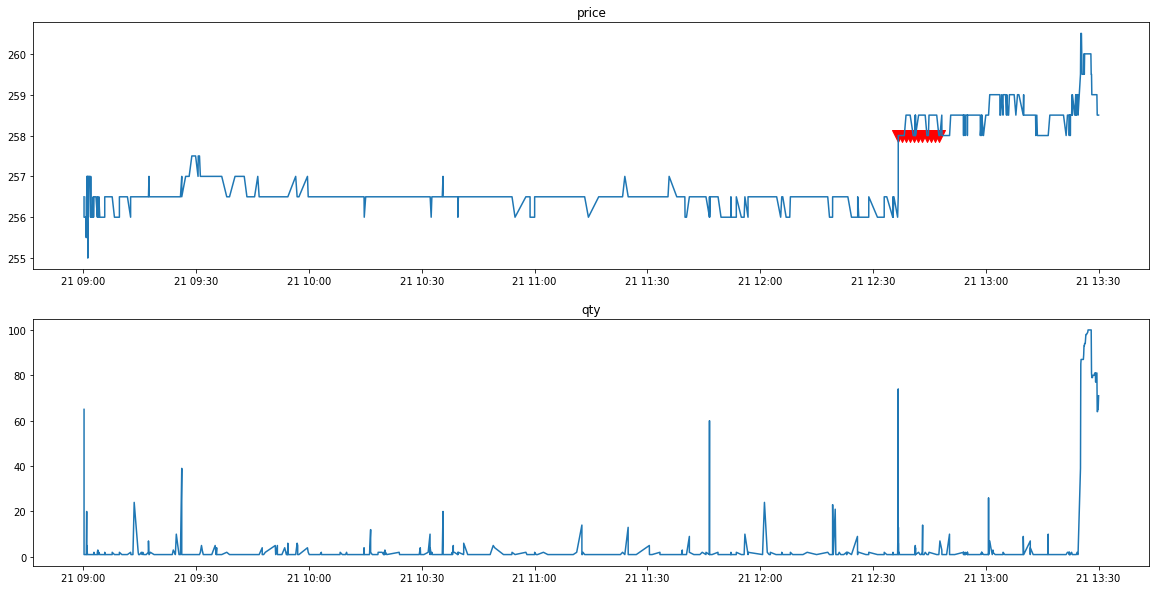

In [ ]:
para = {"sid": "2912", "beta":2, "time_out": 2000000, "gamma": 0.75, "cool_down_min": 100000, "stop_loss_factor": 1.02, "theta": 1.0025, "position_max_q": 10}

res_2912 = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), **para)
profit_2912, cost_2912 = calculate_profit(res_2912)

In [ ]:
profit_2912

-15.0

In [ ]:
cost_2912

12908.0

# Grid Search

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022778
*** bid1_p:  169.5
*** weighted_p:  169.0
ask1_p:  170.0
進場時間： 90324482 
  sell price at  169.5
stop profit
出場時間： 90324572
POSITION(pre):  [169.5]
Order_p(pre):  [169.]
tick_row price:  169.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  169.5
*** weighted_p:  169.08317757009345
ask1_p:  170.0
進場時間： 120800650 
  sell price at  169.5
*** bid1_p:  169.5
*** weighted_p:  169.08317757009345
ask1_p:  170.0
進場時間： 120838282 
  sell price at  169.5
*** bid1_p:  169.5
*** weighted_p:  169.08317757009345
ask1_p:  170.0
進場時間： 120942509 
  sell price at  169.5
*** bid1_p:  169.5
*** weighted_p:  169.08317757009345
ask1_p:  170.0
進場時間： 121038962 
  sell price at  169.5
*** bid1_p:  169.5
*** weigh

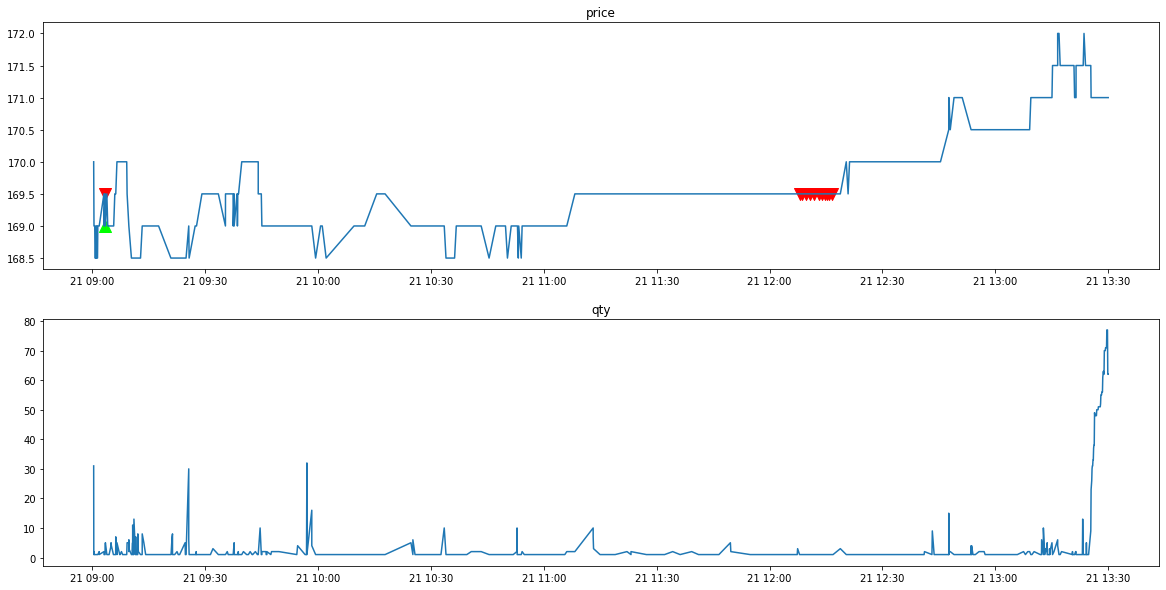

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022856
*** bid1_p:  174.0
*** weighted_p:  173.37078651685394
ask1_p:  174.5
進場時間： 90754787 
  sell price at  174.0
stop profit
出場時間： 90801863
POSITION(pre):  [174.]
Order_p(pre):  [173.5]
tick_row price:  173.5
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  174.5
*** weighted_p:  173.8257142857143
ask1_p:  175.0
進場時間： 91204022 
  sell price at  174.5
stop profit
出場時間： 91221851
POSITION(pre):  [174.5]
Order_p(pre):  [174.]
tick_row price:  174.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  174.5
*** weighted_p:  173.88717948717948
ask1_p:  175.0
進場時間： 91235178 
  sell price at  174.5
stop profit
出場時間： 91245100
POSITION(pre):  [174.5]
Order_p(pre):  [174.]
tick_

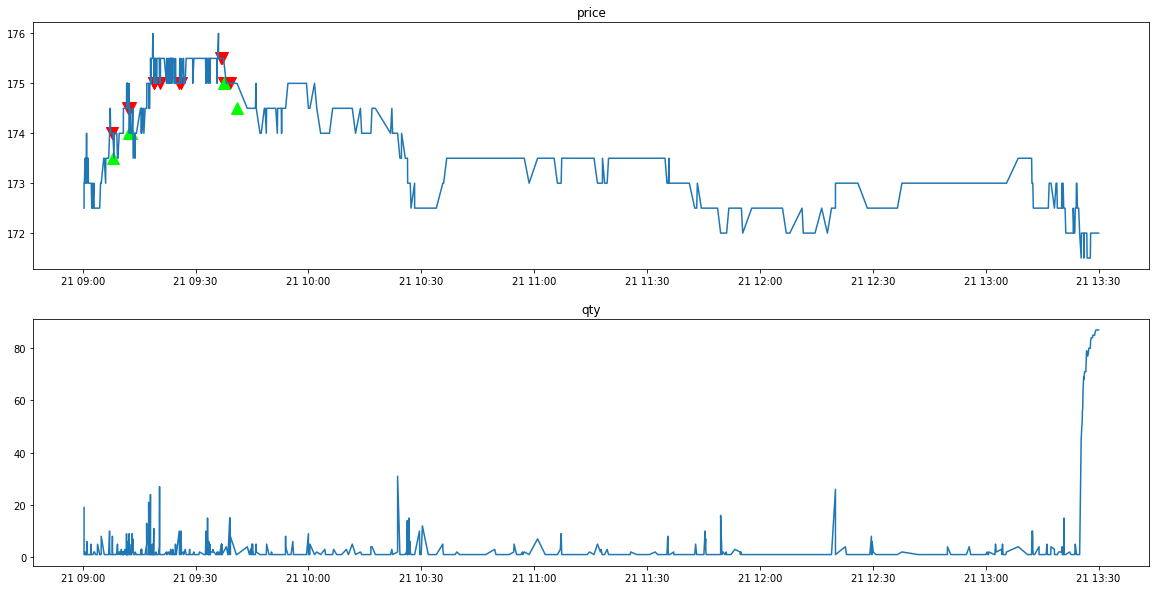

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022814
clear_position:  0.0
position:  []
tick_row_price 170.0
----------Result Report--------------
profit:  0.0


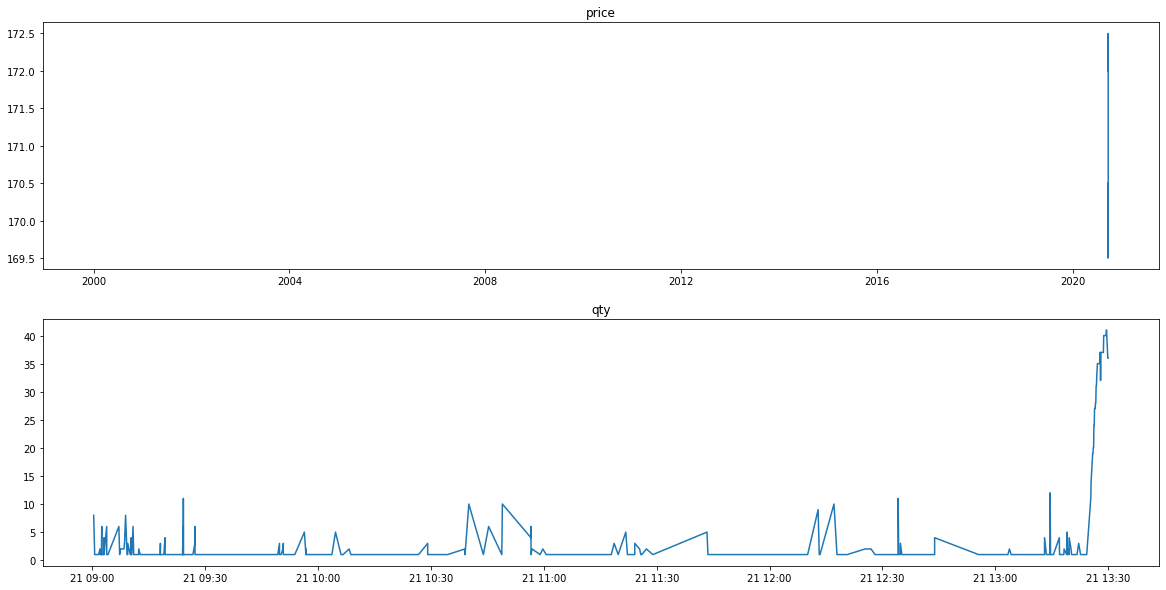

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-14/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022741
*** bid1_p:  173.0
*** weighted_p:  172.7087912087912
ask1_p:  173.5
進場時間： 91948046 
  sell price at  173.0
stop profit
出場時間： 91948046
POSITION(pre):  [173.]
Order_p(pre):  [172.5]
tick_row price:  172.5
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  173.0
*** weighted_p:  172.78494623655914
ask1_p:  173.5
進場時間： 110856654 
  sell price at  173.0
stop profit
出場時間： 112122770
POSITION(pre):  [173.]
Order_p(pre):  [172.5]
tick_row price:  172.5
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 172.0
----------Result Report--------------
profit:  1.0


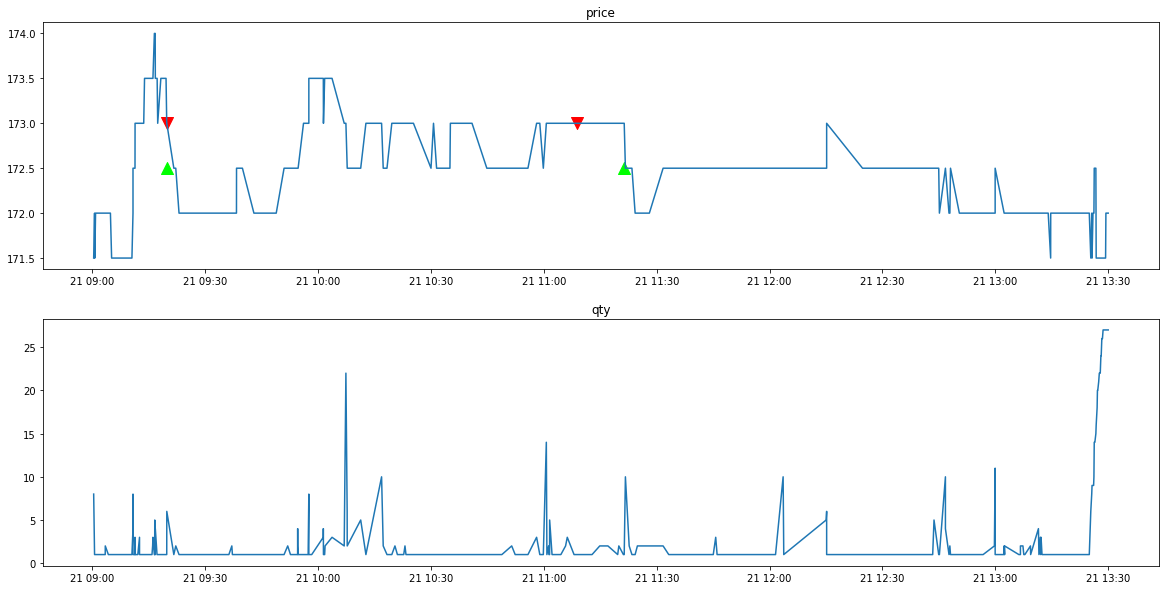

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-15/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022838
*** bid1_p:  175.0
*** weighted_p:  173.88492063492063
ask1_p:  175.5
進場時間： 95438253 
  sell price at  175.0
*** bid1_p:  175.0
*** weighted_p:  173.93560606060606
ask1_p:  175.5
進場時間： 95500700 
  sell price at  175.0
*** bid1_p:  175.0
*** weighted_p:  173.9630996309963
ask1_p:  175.5
進場時間： 95532219 
  sell price at  175.0
*** bid1_p:  174.5
*** weighted_p:  174.0174825174825
ask1_p:  175.0
進場時間： 95602511 
  sell price at  174.5
*** bid1_p:  175.0
*** weighted_p:  174.10223642172525
ask1_p:  175.5
進場時間： 95743326 
  sell price at  175.0
*** bid1_p:  175.0
*** weighted_p:  174.11356466876973
ask1_p:  175.5
進場時間： 95804745 
  sell price at  175.0
*** bid1_p:  175.0
*** weighted_p:  174.14329268292684
ask1_p:  175.5
進場

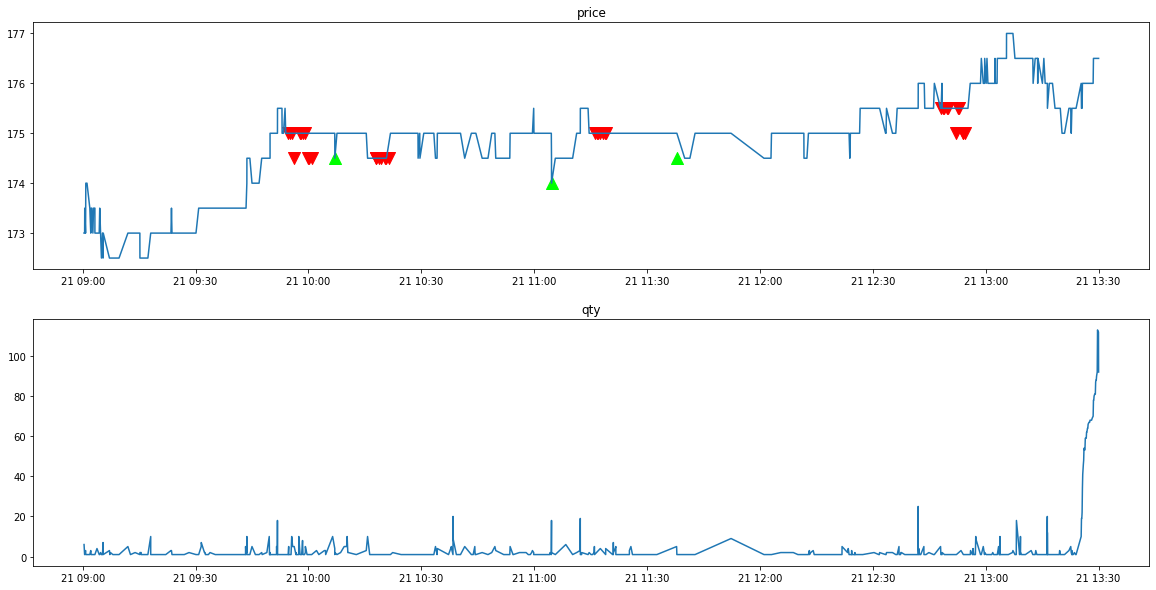

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-16/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022892
*** bid1_p:  179.5
*** weighted_p:  178.45484581497797
ask1_p:  180.0
進場時間： 104614295 
  sell price at  179.5
*** bid1_p:  179.5
*** weighted_p:  178.4914255091104
ask1_p:  180.0
進場時間： 105153051 
  sell price at  179.5
*** bid1_p:  179.0
*** weighted_p:  178.4978700745474
ask1_p:  180.0
進場時間： 105202139 
  sell price at  179.0
stop profit
出場時間： 105643754
POSITION(pre):  [179.5 179.5 179. ]
Order_p(pre):  [179.  179.  178.5]
tick_row price:  179.0
qualified index:  [[0]
 [1]]
POSITION(post):  [179.]
Order_p(post):  [178.5]

*** bid1_p:  180.5
*** weighted_p:  178.96064814814815
ask1_p:  181.0
進場時間： 112606356 
  sell price at  180.5
*** bid1_p:  180.0
*** weighted_p:  178.97164750957853
ask1_p:  181.0
進場時間： 112636785 

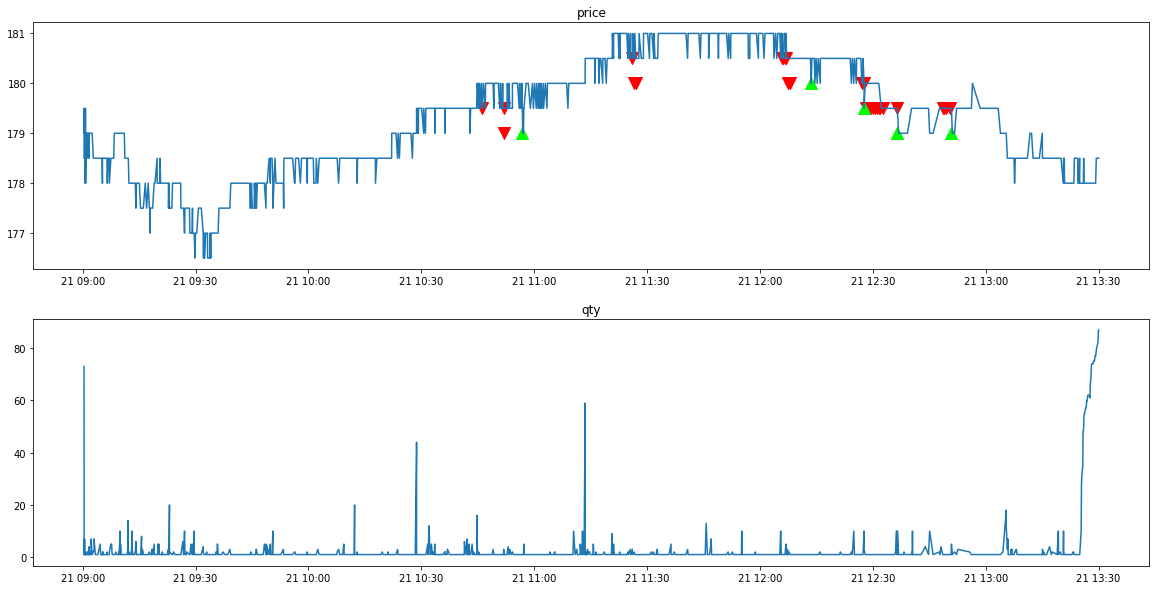

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-17/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022885
clear_position:  0.0
position:  []
tick_row_price 177.5
----------Result Report--------------
profit:  0.0


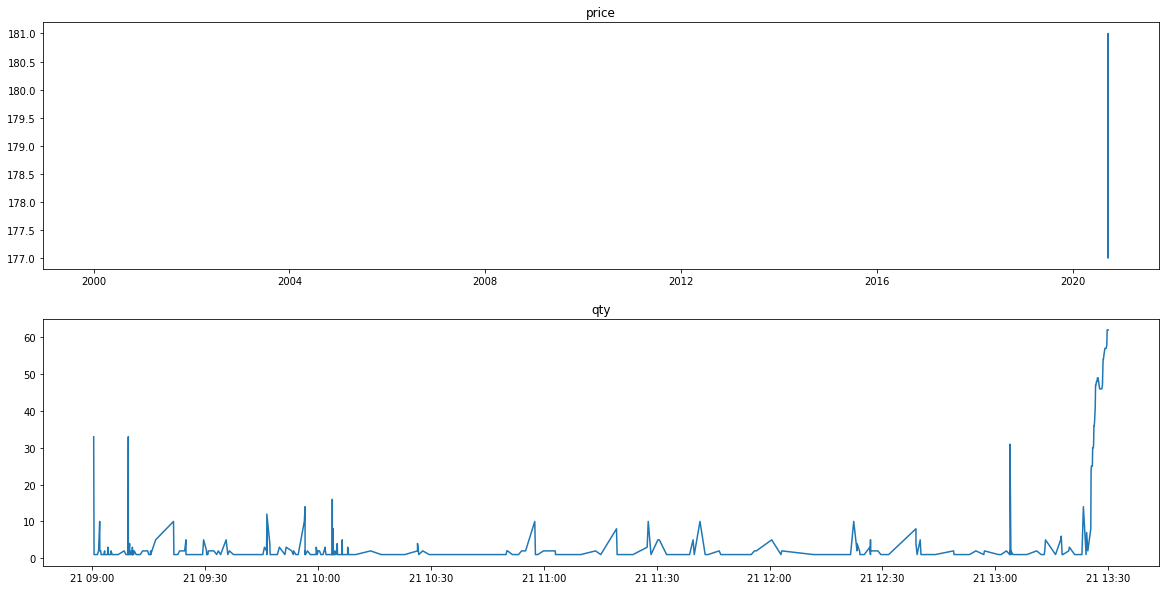

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-18/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022981
*** bid1_p:  179.0
*** weighted_p:  178.55978260869566
ask1_p:  179.5
進場時間： 120652146 
  sell price at  179.0
*** bid1_p:  179.0
*** weighted_p:  178.55978260869566
ask1_p:  179.5
進場時間： 120707399 
  sell price at  179.0
*** bid1_p:  179.0
*** weighted_p:  178.56263498920086
ask1_p:  179.5
進場時間： 120742338 
  sell price at  179.0
stop profit
出場時間： 120742338
POSITION(pre):  [179. 179. 179.]
Order_p(pre):  [178.5 178.5 178.5]
tick_row price:  178.5
qualified index:  [[0]
 [1]
 [2]]
POSITION(post):  []
Order_p(post):  []

clear_position:  0.0
position:  []
tick_row_price 178.0
----------Result Report--------------
profit:  1.5


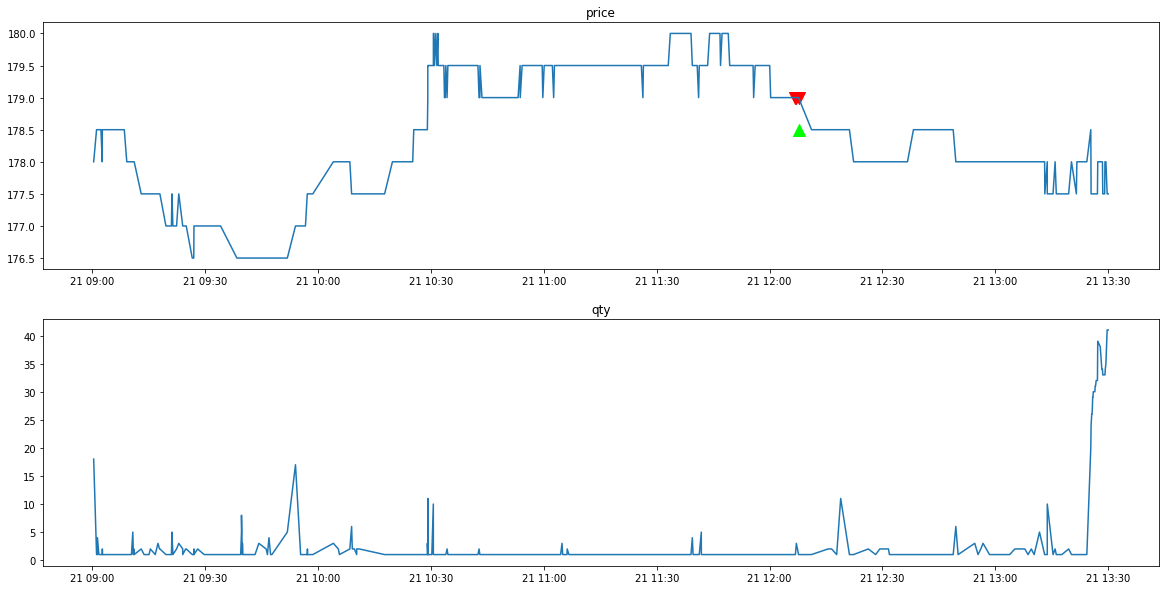

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-21/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022839
clear_position:  0.0
position:  []
tick_row_price 178.0
----------Result Report--------------
profit:  0.0


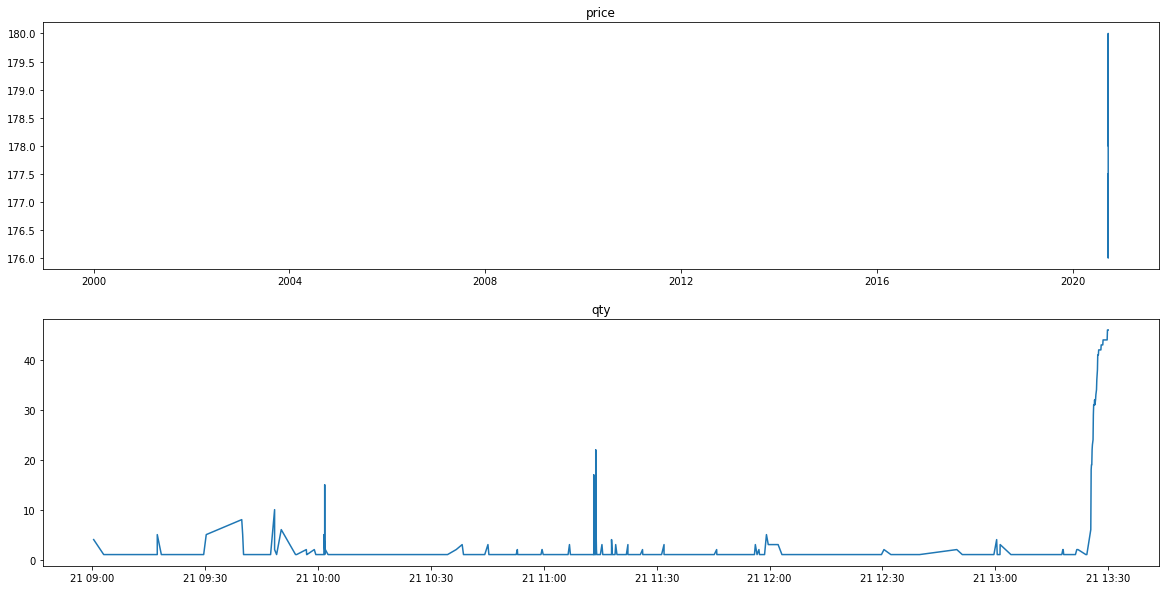

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-22/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022813
*** bid1_p:  178.0
*** weighted_p:  177.78971962616822
ask1_p:  178.5
進場時間： 93313604 
  sell price at  178.0
stop profit
出場時間： 93313604
POSITION(pre):  [178.]
Order_p(pre):  [177.5]
tick_row price:  177.5
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  178.0
*** weighted_p:  177.76793248945148
ask1_p:  178.5
進場時間： 93940254 
  sell price at  178.0
*** bid1_p:  178.0
*** weighted_p:  177.7689075630252
ask1_p:  178.5
進場時間： 94030480 
  sell price at  178.0
*** bid1_p:  178.0
*** weighted_p:  177.7689075630252
ask1_p:  178.5
進場時間： 94105732 
  sell price at  178.0
*** bid1_p:  178.0
*** weighted_p:  177.77822580645162
ask1_p:  178.5
進場時間： 94659271 
  sell price at  178.0
*** bid1_p:  178.0
**

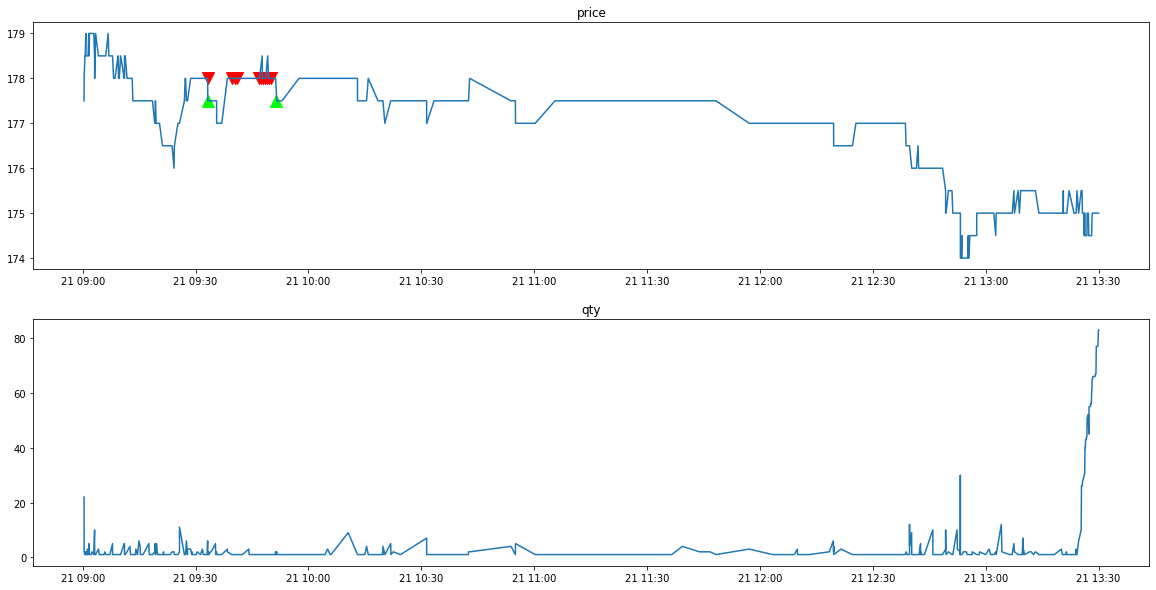

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-23/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90023033
*** bid1_p:  179.5
*** weighted_p:  178.78470254957506
ask1_p:  180.0
進場時間： 92354354 
  sell price at  179.5
*** bid1_p:  179.0
*** weighted_p:  178.7966573816156
ask1_p:  179.5
進場時間： 92400147 
  sell price at  179.0
*** bid1_p:  179.5
*** weighted_p:  178.9076354679803
ask1_p:  180.0
進場時間： 92811045 
  sell price at  179.5
stop profit
出場時間： 92838107
POSITION(pre):  [179.5 179.  179.5]
Order_p(pre):  [179.  178.5 179. ]
tick_row price:  179.0
qualified index:  [[0]
 [2]]
POSITION(post):  [179.]
Order_p(post):  [178.5]

*** bid1_p:  180.0
*** weighted_p:  179.43357142857144
ask1_p:  180.5
進場時間： 93418053 
  sell price at  180.0
*** bid1_p:  180.5
*** weighted_p:  179.46036161335186
ask1_p:  181.0
進場時間： 93520488 
  sel

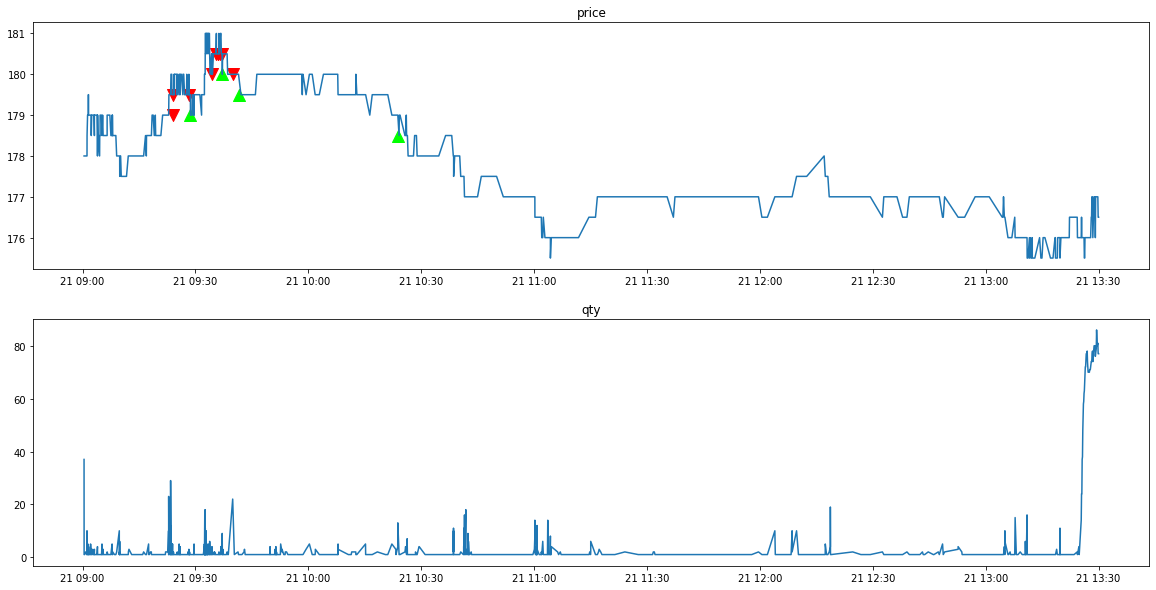

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-24/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90023035
*** bid1_p:  174.5
*** weighted_p:  174.3
ask1_p:  175.0
進場時間： 90811545 
  sell price at  174.5
stop profit
出場時間： 90823900
POSITION(pre):  [174.5]
Order_p(pre):  [174.]
tick_row price:  174.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  174.5
*** weighted_p:  174.20866141732284
ask1_p:  175.0
進場時間： 92012080 
  sell price at  174.5
*** bid1_p:  174.5
*** weighted_p:  174.20866141732284
ask1_p:  175.0
進場時間： 92106576 
  sell price at  174.5
*** bid1_p:  174.5
*** weighted_p:  174.20866141732284
ask1_p:  175.0
進場時間： 92139137 
  sell price at  174.5
*** bid1_p:  174.5
*** weighted_p:  174.21317829457365
ask1_p:  175.0
進場時間： 92214765 
  sell price at  174.5
*** bid1_p:  174.5
*** weighted_

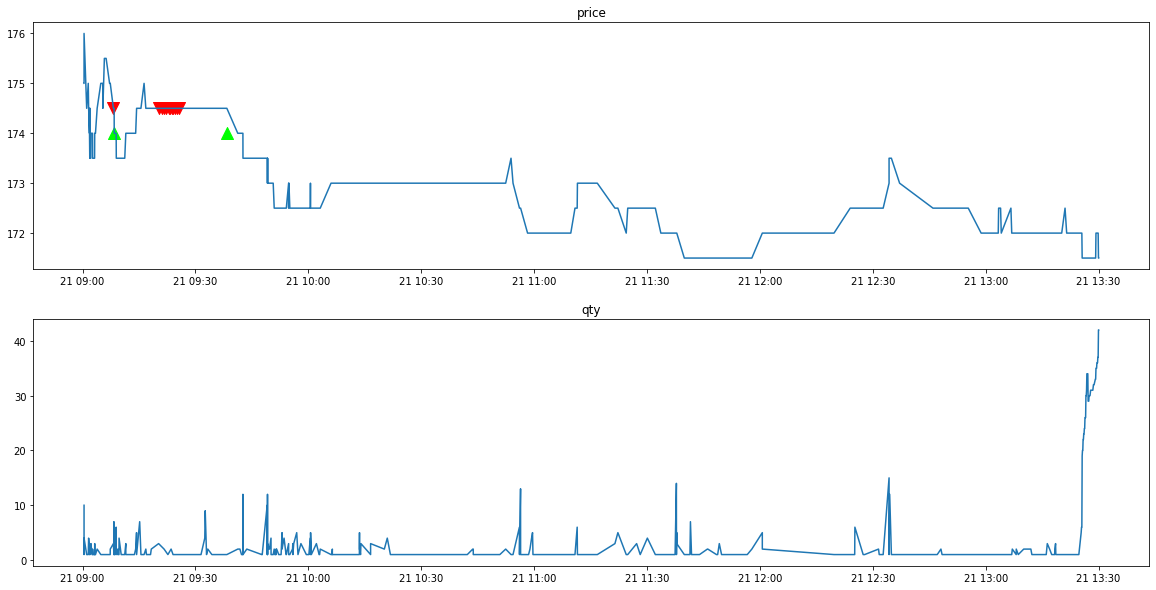

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/6462/otc_lob_6462.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-25/6462/otc_tick_6462.csv' mode='r' encoding='UTF-8'>
90022903
clear_position:  0.0
position:  []
tick_row_price 166.0
----------Result Report--------------
profit:  0.0


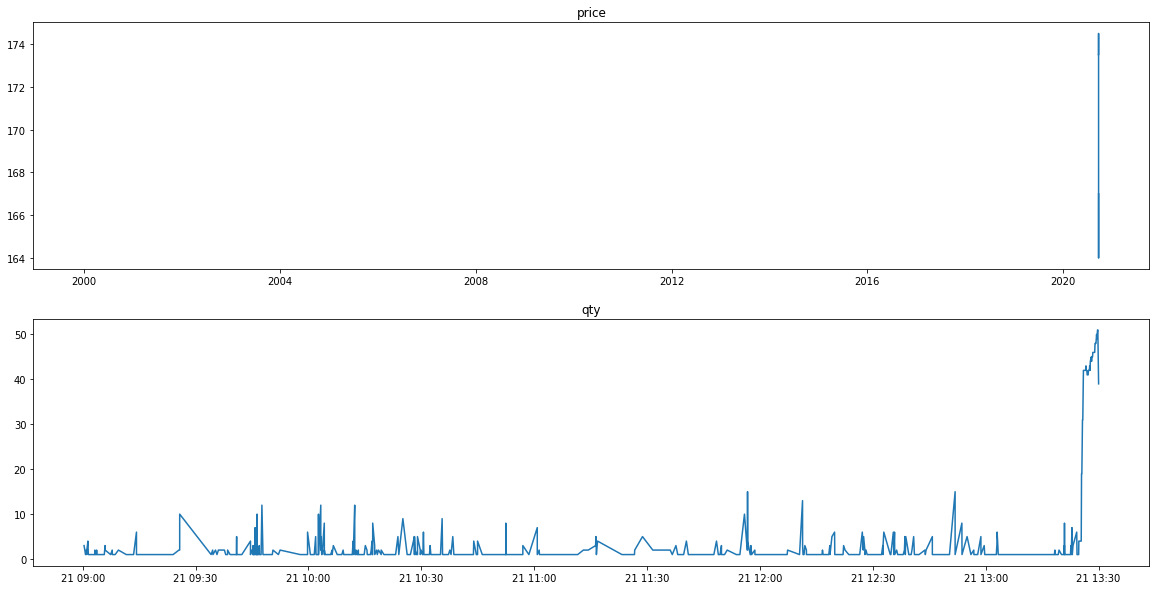

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-09/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90007702
*** bid1_p:  117.0
*** weighted_p:  116.65760869565217
ask1_p:  117.5
進場時間： 90626174 
  sell price at  117.0
*** bid1_p:  117.0
*** weighted_p:  116.6678445229682
ask1_p:  117.5
進場時間： 90708289 
  sell price at  117.0
stop profit
出場時間： 90721784
POSITION(pre):  [117. 117.]
Order_p(pre):  [116.5 116.5]
tick_row price:  116.5
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  116.0
*** weighted_p:  115.88204393505254
ask1_p:  116.5
進場時間： 91547780 
  sell price at  116.0
*** bid1_p:  116.0
*** weighted_p:  115.88238095238096
ask1_p:  116.5
進場時間： 91600626 
  sell price at  116.0
stop profit
出場時間： 91644689
POSITION(pre):  [116. 116.]
Order_p(pre):  [115.5 115.5]
tick_row price:  115.5
qualif

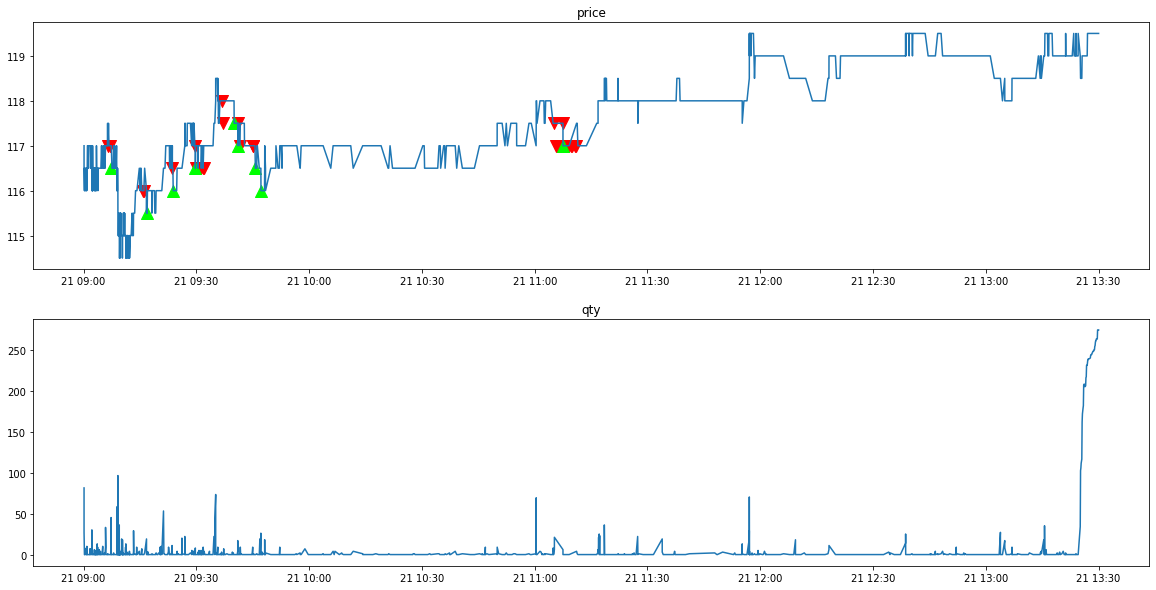

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-10/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90009523
*** bid1_p:  121.0
*** weighted_p:  120.69642857142857
ask1_p:  121.5
進場時間： 90741683 
  sell price at  121.0
*** bid1_p:  121.0
*** weighted_p:  120.701171875
ask1_p:  121.5
進場時間： 90800341 
  sell price at  121.0
stop profit
出場時間： 90803220
POSITION(pre):  [121. 121.]
Order_p(pre):  [120.5 120.5]
tick_row price:  120.5
qualified index:  [[0]
 [1]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  121.5
*** weighted_p:  120.916142557652
ask1_p:  122.0
進場時間： 91251191 
  sell price at  121.5
stop profit
出場時間： 91251191
POSITION(pre):  [121.5]
Order_p(pre):  [121.]
tick_row price:  121.0
qualified index:  [[0]]
POSITION(post):  []
Order_p(post):  []

*** bid1_p:  121.0
*** weighted_p:  120.84287454323996
ask1_p:  121.

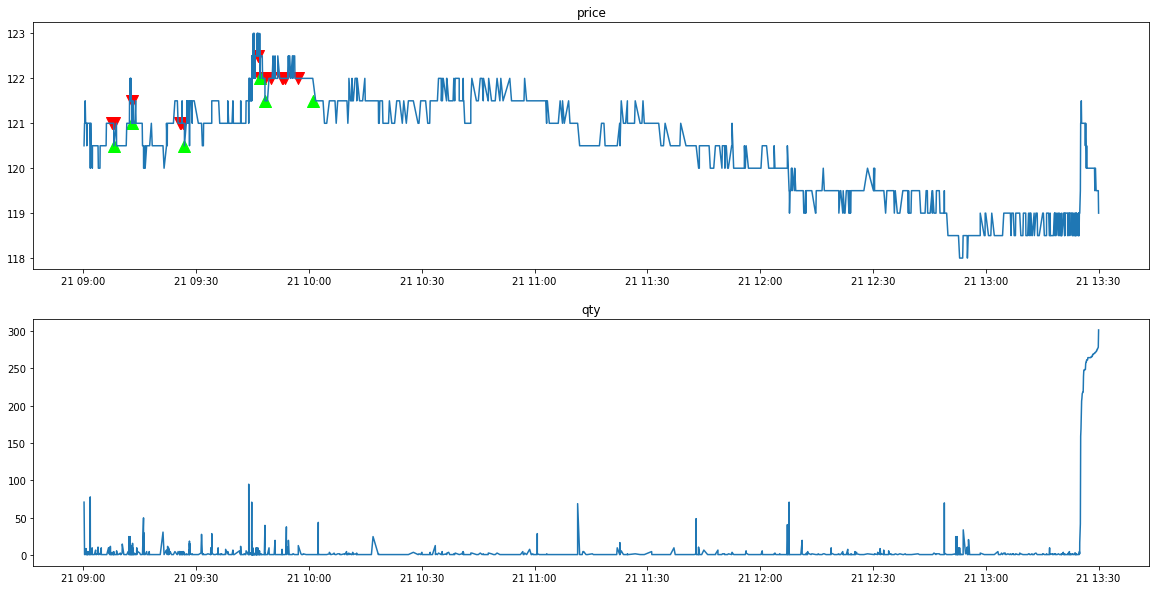

<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/6278/tse_lob_6278.csv' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/content/gdrive/Shared drives/marketdata/stock/2020-09-11/6278/tse_tick_6278.csv' mode='r' encoding='UTF-8'>
90008401
*** bid1_p:  119.0
*** weighted_p:  118.57801418439716
ask1_p:  119.5
進場時間： 91021498 
  sell price at  119.0
*** bid1_p:  119.0
*** weighted_p:  118.58680555555556
ask1_p:  119.5
進場時間： 91056368 
  sell price at  119.0
*** bid1_p:  119.0
*** weighted_p:  118.59726962457339
ask1_p:  119.5
進場時間： 91123379 
  sell price at  119.0
*** bid1_p:  119.0
*** weighted_p:  118.59863945578232
ask1_p:  119.5
進場時間： 91155082 
  sell price at  119.0
*** bid1_p:  119.0
*** weighted_p:  118.59863945578232
ask1_p:  119.5
進場時間： 91200368 
  sell price at  119.0
*** bid1_p:  119.0
*** weighted_p:  118.77913279132791
ask1_p:  119.5
進場時間： 91308563 
  sell price at  119.0
*** bid1_p:  119.5
*** weighted_p:  118.87349397590361
ask1_p:  120.0


In [ ]:
STOCK_LIST = ["6462", "6278", "6488", "3037", "2330", "3406", "2317", "6505", "2412", "1301", "1326", "2882", "1303", "2881", "3008", "1216", "2891", "2002", "3045", "2454", "2886", "2912", "2308", "3711", "2892"]
SEC = 1000
MIN = 100000
COOL_DOWN_MIN_LIST = [30*SEC, 45*SEC, 1*MIN, (2*MIN + 30*SEC) , 5*MIN, 10*MIN]
THETA_LIST = [1.001, 1.002, 1.003, 1.004, 1.005, 1.006, 1.007, 1.008, 1.009,1.01] 

for sid in STOCK_LIST:
    for theta in THETA_LIST[:1]:
        for cool in COOL_DOWN_MIN_LIST[:1]:
            para = {"sid": sid, "beta":2, "time_out": 2000000, "gamma": 0.75, "cool_down_min": cool, "stop_loss_factor": 1.02, "theta": theta, "position_max_q": 10}
            res = back_test(dt.datetime(2020, 9, 9), dt.datetime(2020, 9, 25), **para)
            profit, cost = calculate_profit(res)